# Citations:

In [1]:
# @Misc{devos2015,
  #author = {Nelis J. de Vos},
  # title = {kmodes categorical clustering library},
  # howpublished = {\url{https://github.com/nicodv/kmodes}},
  # year = {2015--2021}
# }

# Importing libraries

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10, 8)
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from kmodes.kmodes import KModes
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.utils import resample

# Data Reading and Exploration

In [2]:
fen_df = pd.read_csv('Updated.csv')
fen_df.shape

(72236, 33)

In [3]:
#Replacing NaN values in categorical columns with 'Unknown' and numerical columns with '0'
#https://saturncloud.io/blog/how-to-replace-nan-values-with-the-average-of-columns-in-pandas-dataframe/
for col in fen_df.select_dtypes(include=np.number).columns:
    fen_df[col].fillna(0, inplace=True)

for col in fen_df.select_dtypes(exclude=np.number).columns:
    fen_df[col].fillna('Unknown', inplace=True)

In [4]:
#See if there's any remaining Nan values
fen_df.isnull().sum().sum()

0

In [5]:
#Dropping Age code because they are all 1. Dropping Year because they are all 2021
fen_df = fen_df.drop(['AgeCode', 'Year'], axis=1)

In [6]:
col_999 = fen_df.loc[fen_df['Age'] == 999, ['Race', 'Education', 'Death']]
print(col_999)

          Race Education                        Death
2798     White   Unknown    Accidental Drug Poisoning
4499     White   Unknown    Accidental Drug Poisoning
5040     White   Unknown    Accidental Drug Poisoning
5988     White   Unknown    Accidental Drug Poisoning
7749   Chinese   Unknown    Accidental Drug Poisoning
9551     White   Unknown    Accidental Drug Poisoning
9576     White   Unknown    Accidental Drug Poisoning
18021    White   Unknown    Accidental Drug Poisoning
21274    White   Unknown    Accidental Drug Poisoning
21888    White   Unknown    Accidental Drug Poisoning
32896    White   Unknown  Undetermined Drug Poisoning
45222    White   Unknown    Accidental Drug Poisoning
53320    White   Unknown       Suicide Drug Poisoning


In [7]:
#Remove Age 999 as most of their information was unknown
fen_df = fen_df[fen_df['Age'] <= 150]

In [8]:
#Checking the highest age in the dataframe
fen_df['Age'].max()

98

In [9]:
#Describing the columns
columns = fen_df.columns
for c in columns:
    print('****', c, '****')
    print(fen_df[c].describe())

**** Education ****
count                                     72223
unique                                        9
top       High school graduate or GED completed
freq                                      37015
Name: Education, dtype: object
**** Month of Death ****
count     72223
unique       12
top       April
freq       6397
Name: Month of Death, dtype: object
**** Sex ****
count     72223
unique        2
top           M
freq      52195
Name: Sex, dtype: object
**** Age ****
count    72223.000000
mean        41.308157
std         12.977409
min          1.000000
25%         31.000000
50%         40.000000
75%         51.000000
max         98.000000
Name: Age, dtype: float64
**** AgeCategory ****
count             72223
unique               24
top       30 - 34 years
freq              10722
Name: AgeCategory, dtype: object
**** Marital Status ****
count                     72223
unique                        5
top       Never married, single
freq                      43313
Name: Mar

In [10]:
#Checking counts of each object in the Education feature
fen_df.groupby("Education").size().sort_values()

Education
Doctorate or professional degree           193
Masters degree                             564
Unknown                                   2298
8th grade or less                         2347
Bachelors degree                          3348
Associate degree                          3617
Some college credit, but no degree       10225
9 - 12th grade, no diploma               12616
High school graduate or GED completed    37015
dtype: int64

In [11]:
#Binning Race into specific categories 
fen_df.groupby("Race").size().sort_values()

Race
AIAN and NHOPI                                                     1
Black, AIAN and Asian                                              2
AIAN, Asian and White                                              2
Black, Asian and NHOPI                                             2
Black, Asian and White                                             6
Guamanian                                                          9
Black and Native Hawaiian or Other Pacific Islander (NHOPI)        9
Asian and NHOPI                                                   10
AIAN and Asian                                                    14
Asian, NHOPI and White                                            14
Black and Asian                                                   19
Japanese                                                          20
Hawaiian                                                          20
Black, AIAN and White                                             20
Samoan                       

In [12]:
#Group all mixed in 1 category and put Asians in 1 category and others in 1 category. We are using a mapping function for this task
def fixrace(race):
    mixed = ['AIAN, Asian, NHOPI and White', 'Black, AIAN, NHOPI and White', 'AIAN and NHOPI',
                 'Black, NHOPI and White', 'Black, Asian and NHOPI', 'Black, AIAN, Asian and White',
                 'Black, AIAN and Asian', 'AIAN, Asian and White', 'Black, Asian and White',
                 'Black and Native Hawaiian or Other Pacific Islander (NHOPI)', 'AIAN and Asian',
                 'Black, AIAN and White', 'Black and Asian', 'Asian and NHOPI', 'Asian, NHOPI and White',
                 'NHOPI and White', 'Black and AIAN', 'Asian and White', 'AIAN and White', 'Black and White']
    asian = ['Japanese', 'Chinese', 'Korean', 'Vietnamese', 'Asian Indian', 'Filipino', 'Other or Multiple Asian']
    other = ['Guamanian', 'Samoan', 'Hawaiian', 'Other or Multiple Pacific Islander', 'American Indian or Alaskan Native (AIAN)']

    if race in mixed:
        return 'Mixed'
    elif race in asian:
        return 'Asian'
    elif race in other:
        return 'Other/ Islanders'
    else:
        return race

In [13]:
fen_df['Race'] = fen_df['Race'].apply(fixrace)

In [14]:
fen_df.groupby("Race").size().sort_values()

Race
Asian                 525
Mixed                 987
Other/ Islanders      993
Black               14277
White               55441
dtype: int64

In [15]:
fen_df.head()

Education Month of Death Sex  Age  \
0     Some college credit, but no degree        January   M   62   
1             9 - 12th grade, no diploma        January   M   17   
2     Some college credit, but no degree        January   M   35   
3  High school graduate or GED completed        January   M   30   
4                      8th grade or less        January   M   68   

     AgeCategory         Marital Status Manner of Death              Race  \
0  60 - 64 years               Divorced        Accident  Other/ Islanders   
1  15 - 19 years  Never married, single        Accident             White   
2  35 - 39 years  Never married, single        Accident             White   
3  30 - 34 years  Never married, single        Accident  Other/ Islanders   
4  65 - 69 years               Divorced        Accident             White   

                                 Occupation                      Death  ...  \
0                    Management Occupations  Accidental Drug Poisoning  ...   
1               Other, Misc (exc Housewife)  Accidental Drug Poisoning  ...   
2                    Management Occupations  Accidental Drug Poisoning  ...   
3  Farming, Fishing, & Forestry Occupations  Accidental Drug Poisoning  ...   
4                    Management Occupations  Accidental Drug Poisoning  ...   

  Condition11 Condition12 Condition13 Condition14 Condition15 Condition16  \
0     Unknown     Unknown     Unknown     Unknown         0.0         0.0   
1     Unknown     Unknown     Unknown     Unknown         0.0         0.0   
2     Unknown     Unknown     Unknown     Unknown         0.0         0.0   
3     Unknown     Unknown     Unknown     Unknown         0.0         0.0   
4     Unknown     Unknown     Unknown     Unknown         0.0         0.0   

  Condition17 Condition18 Condition19 Condition20  
0         0.0         0.0         0.0         0.0  
1         0.0         0.0         0.0         0.0  
2         0.0         0.0         0.0         0.0  
3         0.0         0.0         0.0         0.0  
4         0.0         0.0         0.0         0.0  

[5 rows x 31 columns]

In [16]:
#Using cut to bin ages into specific categories. Lets drop age category and make a new one with binned ages.
#https://pbpython.com/pandas-qcut-cut.html

fen_df['Age'].describe()

age_labels = ['18 and under', '19 to 30', '31 to 40', '41 to 50', '51 to 65', '65 and up']

age_bins = [0, 18, 30, 40, 50, 65, 100]

fen_df['AgeCategory'] = pd.cut(fen_df['Age'], bins=age_bins, labels=age_labels, right=True)

In [17]:
fen_df.head()

Education Month of Death Sex  Age  \
0     Some college credit, but no degree        January   M   62   
1             9 - 12th grade, no diploma        January   M   17   
2     Some college credit, but no degree        January   M   35   
3  High school graduate or GED completed        January   M   30   
4                      8th grade or less        January   M   68   

    AgeCategory         Marital Status Manner of Death              Race  \
0      51 to 65               Divorced        Accident  Other/ Islanders   
1  18 and under  Never married, single        Accident             White   
2      31 to 40  Never married, single        Accident             White   
3      19 to 30  Never married, single        Accident  Other/ Islanders   
4     65 and up               Divorced        Accident             White   

                                 Occupation                      Death  ...  \
0                    Management Occupations  Accidental Drug Poisoning  ...   
1               Other, Misc (exc Housewife)  Accidental Drug Poisoning  ...   
2                    Management Occupations  Accidental Drug Poisoning  ...   
3  Farming, Fishing, & Forestry Occupations  Accidental Drug Poisoning  ...   
4                    Management Occupations  Accidental Drug Poisoning  ...   

  Condition11 Condition12 Condition13 Condition14 Condition15 Condition16  \
0     Unknown     Unknown     Unknown     Unknown         0.0         0.0   
1     Unknown     Unknown     Unknown     Unknown         0.0         0.0   
2     Unknown     Unknown     Unknown     Unknown         0.0         0.0   
3     Unknown     Unknown     Unknown     Unknown         0.0         0.0   
4     Unknown     Unknown     Unknown     Unknown         0.0         0.0   

  Condition17 Condition18 Condition19 Condition20  
0         0.0         0.0         0.0         0.0  
1         0.0         0.0         0.0         0.0  
2         0.0         0.0         0.0         0.0  
3         0.0         0.0         0.0         0.0  
4         0.0         0.0         0.0         0.0  

[5 rows x 31 columns]

In [18]:
# Changing Undetermined/ Suicide/ Unknown Deaths into 1 type: Other

fen_df['Death'] = fen_df['Death'].replace(['Undetermined Drug Poisoning', 'Suicide Drug Poisoning', 'Unknown'], 'Other')

In [19]:
fen_df['Death'].value_counts()

Accidental Drug Poisoning    67848
Other                         4375
Name: Death, dtype: int64

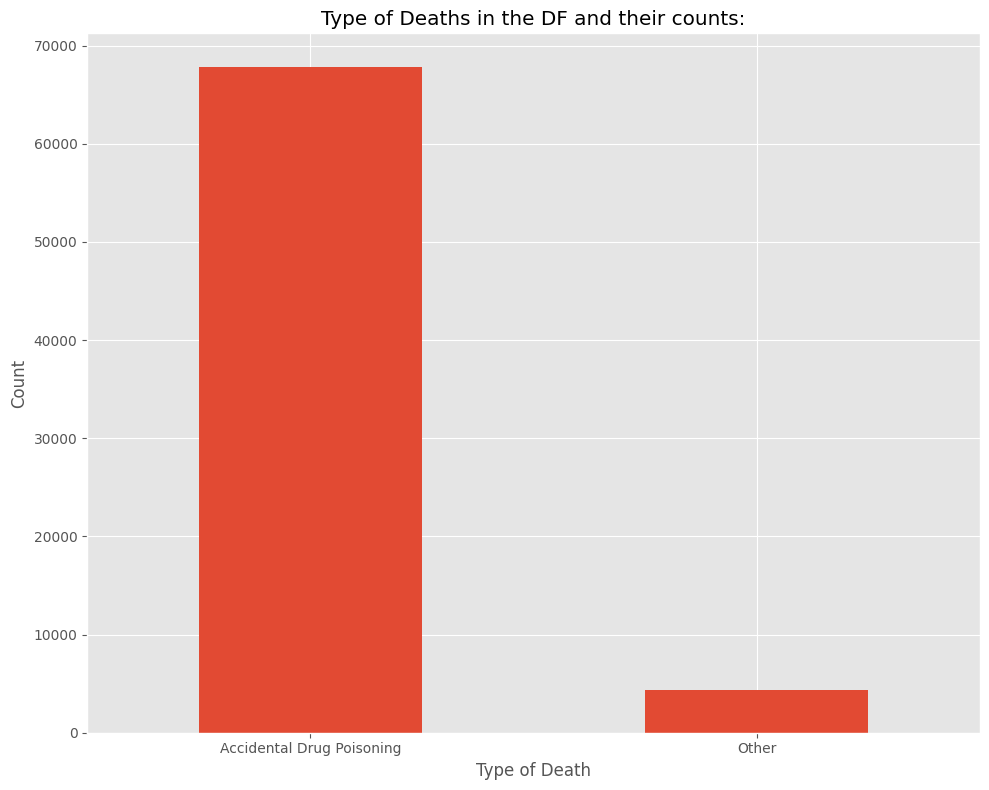

In [20]:
#Creating bar graph for the value counts for the Death column:
death_count = fen_df['Death'].value_counts()

death_count.plot(kind='bar')
plt.title('Type of Deaths in the DF and their counts:')
plt.xlabel('Type of Death')
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.tight_layout()
#plt.savefig('TypesofDeathsAccidentalandother.png')

plt.show()

In [21]:
education_count = fen_df['Education'].value_counts()
height = education_count.values
bars = ('H.S. Diploma/GED', '9th-12th No Diploma', 'Some College', 'Associate Degree', 'Bachelors Degree', 
        '8th grade or less', 'Unknown', 'Masters Degree', 'PHD')

print(height)

[37015 12616 10225  3617  3348  2347  2298   564   193]


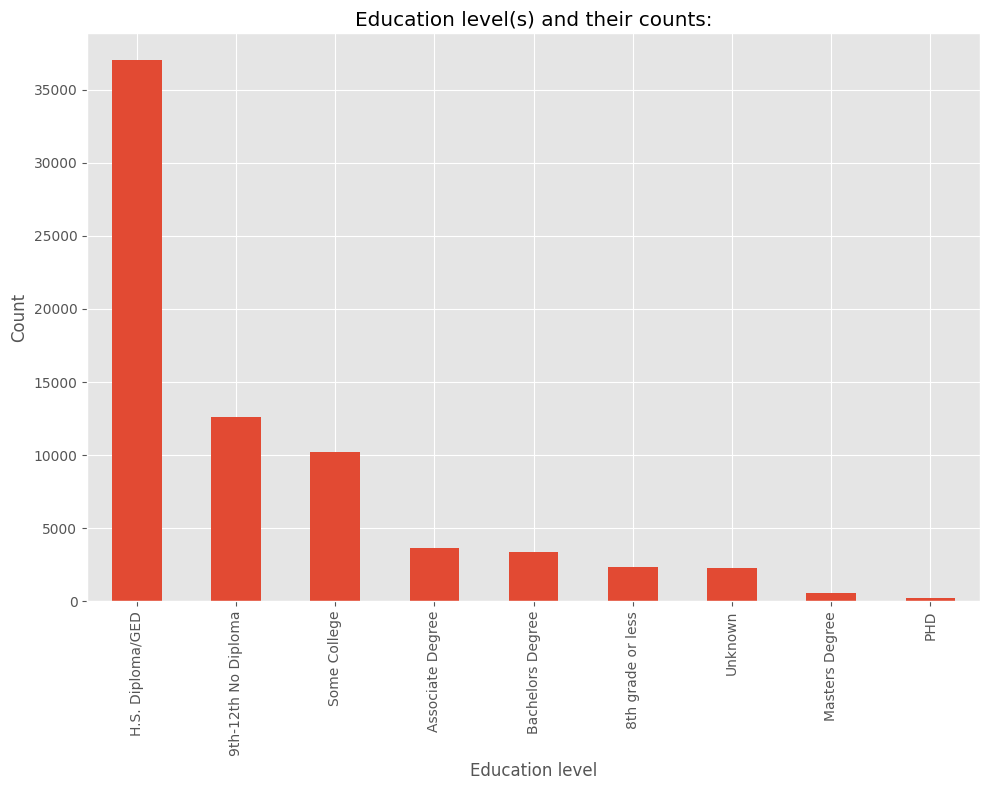

In [22]:
education_count.plot(kind='bar')
plt.title('Education level(s) and their counts:')
plt.xlabel('Education level')
plt.xticks(ticks = np.arange(len(height)), labels=bars)
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# K-Mode clusting (Parameter tuning)

In [23]:
fen_df_mode = fen_df
col_to_drop = [col for col in fen_df_mode.columns if 'Condition' in col]

fen_df_mode = fen_df_mode.drop(columns=col_to_drop)
fen_df_mode = fen_df_mode.drop(columns=['Death Recode', 'Month of Death', 'Manner of Death', 'Age'], axis=1)

fen_df_mode.head()

Education Sex   AgeCategory  \
0     Some college credit, but no degree   M      51 to 65   
1             9 - 12th grade, no diploma   M  18 and under   
2     Some college credit, but no degree   M      31 to 40   
3  High school graduate or GED completed   M      19 to 30   
4                      8th grade or less   M     65 and up   

          Marital Status              Race  \
0               Divorced  Other/ Islanders   
1  Never married, single             White   
2  Never married, single             White   
3  Never married, single  Other/ Islanders   
4               Divorced             White   

                                 Occupation                      Death  
0                    Management Occupations  Accidental Drug Poisoning  
1               Other, Misc (exc Housewife)  Accidental Drug Poisoning  
2                    Management Occupations  Accidental Drug Poisoning  
3  Farming, Fishing, & Forestry Occupations  Accidental Drug Poisoning  
4                    Management Occupations  Accidental Drug Poisoning

In [24]:
#Silhoutte analysis to get K and plot clusters. We modify to use mode for the categorical data
#Silhoutte analysis displays a measure of how close each point in one cluster is to points in the neighboring clusters and allows us to determine the number of clusters we should use visually.
#1 - a/b where a is average distance of a point to other points in a cluster, while B is minimum of average distance of a point to other points in another cluster
#however, since we are performing K mode, we'll write a custom function 
#Modify the silhouette_samples function by using the mode (from scipy.stats) rather than mean (there's two instances where this is needed). Pass the precomputed distances (based on the dissimilarity metric) matrix to the function.
#The dissimilarity metric used is either a simple dissimilarity metric (obtained using the hamming distance) or the jaccard distance. Both are available through scipy.spatial.distance

#def silhoutte_mode(x, labels, 

Cost for init method: Huang: 141086.0
Cost for init method: Random: 145771.0
Cost for init method: Cao: 152739.0


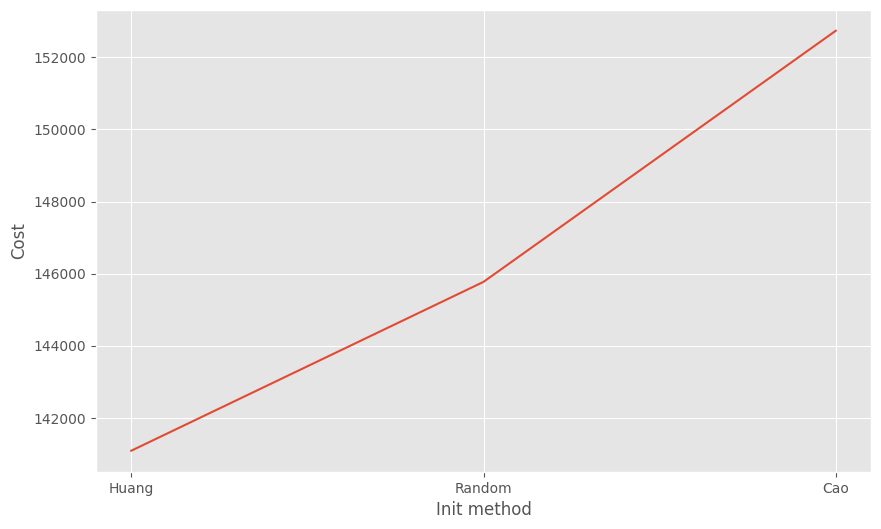

In [25]:
def find_init(data):
    init_tuning = ['Huang', 'Random', 'Cao']
    cost = []
    
    #Looping through the number of max features and finding the best
    for init in init_tuning:
        kmode = KModes(init=init, random_state=34)
        kmode.fit_predict(data)
        cost.append(kmode.cost_)
        print(f'Cost for init method: {init}: {kmode.cost_}')
    
    plt.figure(figsize=(10,6))
    plt.plot(init_tuning,cost)
    plt.xlabel('Init method')
    plt.ylabel('Cost')
    plt.grid(True)
    plt.show()

find_init(fen_df_mode)

Cost for ninit method: 4: 148707.0
Cost for ninit method: 8: 147845.0
Cost for ninit method: 12: 141086.0
Cost for ninit method: 16: 141086.0
Cost for ninit method: 20: 141086.0


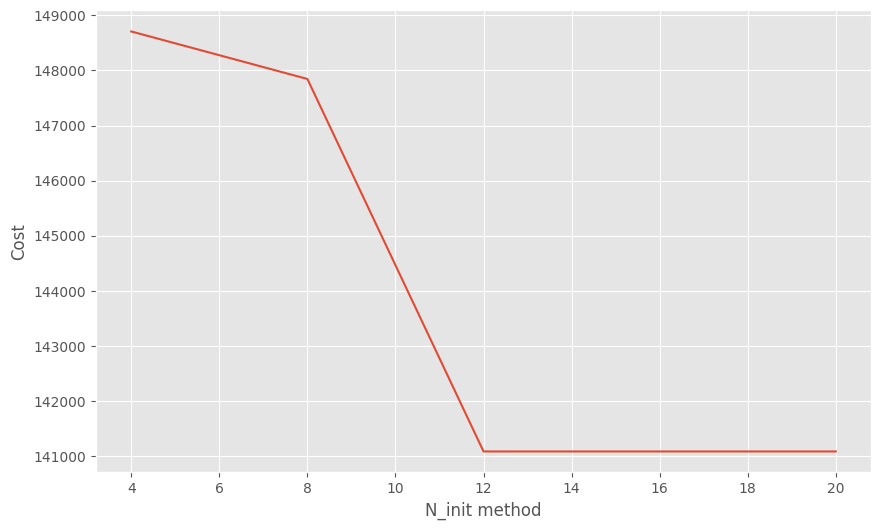

In [26]:
def find_ninit(data):
    ninit_tuning = [4, 8, 12, 16, 20]
    cost = []
    
    #Looping through the number of max features and finding the best
    for ninit in ninit_tuning:
        kmode = KModes(init='Huang', n_init=ninit, random_state=34)
        kmode.fit_predict(data)
        cost.append(kmode.cost_)
        print(f'Cost for ninit method: {ninit}: {kmode.cost_}')
    
    plt.figure(figsize=(10,6))
    plt.plot(ninit_tuning,cost)
    plt.xlabel('N_init method')
    plt.ylabel('Cost')
    plt.grid(True)
    plt.show()

find_ninit(fen_df_mode)

Cost for Max iterations: 100: 141086.0
Cost for Max iterations: 200: 141086.0
Cost for Max iterations: 300: 141086.0


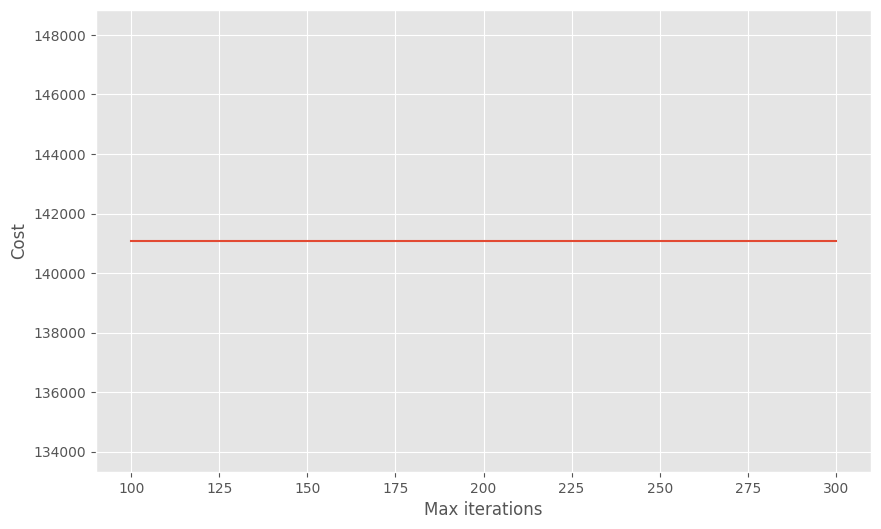

In [27]:
def find_max(data):
    max_tuning= [100, 200, 300]
    cost = []
    
    #Looping through the number of max features and finding the best
    for max in max_tuning:
        kmode = KModes(init='Huang', n_init=12, max_iter=max, random_state=34)
        kmode.fit_predict(data)
        cost.append(kmode.cost_)
        print(f'Cost for Max iterations: {max}: {kmode.cost_}')
    
    plt.figure(figsize=(10,6))
    plt.plot(max_tuning,cost)
    plt.xlabel('Max iterations')
    plt.ylabel('Cost')
    plt.grid(True)
    plt.show()

find_max(fen_df_mode)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 214724.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 214724.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 214724.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 214724.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 214724.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 6, iteration: 1/100, moves: 0, cost: 214724.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 7, iteration: 1/100, moves: 0, cost: 214724.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 8, ite

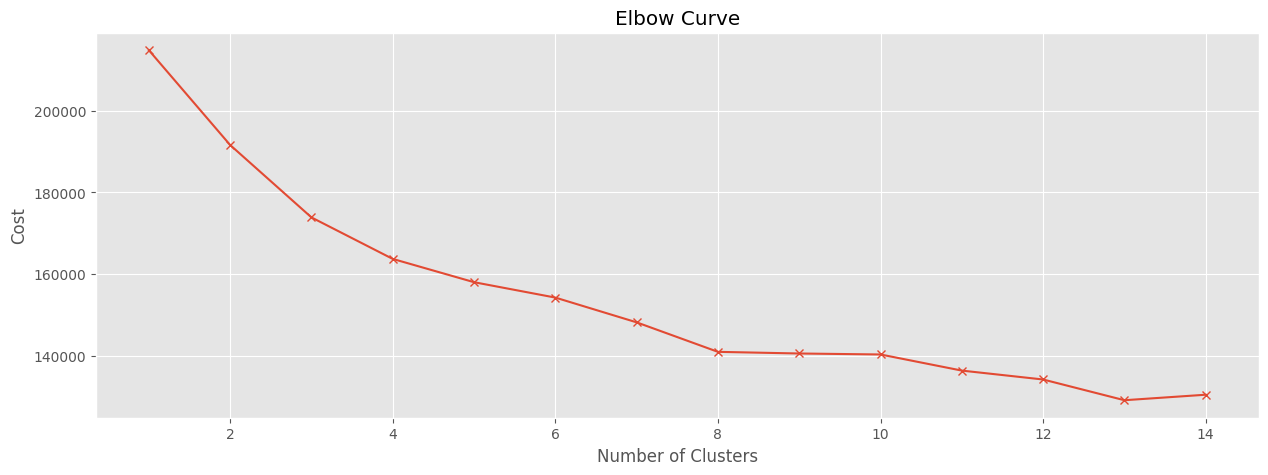

Elbow is at k = 4.000000 clusters


In [57]:
#Elbow method to find the number of clusters or k we are going to implement. Use KneeLocator to get the K value. Detects elbows if curve is convex. We use the tuned parameters from above.
def find_num_clusters(data, k):
    iters = range(1,k)
    
    cost = [] 
    for i in list(iters):
        kmode = KModes(n_clusters=i, init='Huang', n_init=12, max_iter=100, random_state=34, verbose=1) #init='Huang', n_init = 5, verbose = 1,
        kmode.fit_predict(data)
        cost.append(kmode.cost_)
        print('Fit {} clusters'.format(i))

    plt.plot(iters, cost, 'x-')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Cost')
    plt.title('Elbow Curve')
    plt.show()

    #Get the K value. Detects elbows if curve is convex.
    knee = KneeLocator(x=iters, y=cost, S=0.1, curve='convex', direction='decreasing')
    K_knee = knee.elbow
    print('Elbow is at k =', f'{K_knee:0f} clusters')
    
find_num_clusters(fen_df_mode, 15)

# K mode clustering without the Death Column: 

In [28]:
fen_df_mode

Education Sex   AgeCategory  \
0         Some college credit, but no degree   M      51 to 65   
1                 9 - 12th grade, no diploma   M  18 and under   
2         Some college credit, but no degree   M      31 to 40   
3      High school graduate or GED completed   M      19 to 30   
4                          8th grade or less   M     65 and up   
...                                      ...  ..           ...   
72231                      8th grade or less   M      41 to 50   
72232  High school graduate or GED completed   F      51 to 65   
72233  High school graduate or GED completed   M      41 to 50   
72234  High school graduate or GED completed   M      51 to 65   
72235  High school graduate or GED completed   M      41 to 50   

               Marital Status              Race  \
0                    Divorced  Other/ Islanders   
1       Never married, single             White   
2       Never married, single             White   
3       Never married, single  Other/ Islanders   
4                    Divorced             White   
...                       ...               ...   
72231  Marital Status unknown             White   
72232                Divorced             White   
72233                Divorced             Black   
72234   Never married, single             White   
72235                 Married             Black   

                                         Occupation                      Death  
0                            Management Occupations  Accidental Drug Poisoning  
1                       Other, Misc (exc Housewife)  Accidental Drug Poisoning  
2                            Management Occupations  Accidental Drug Poisoning  
3          Farming, Fishing, & Forestry Occupations  Accidental Drug Poisoning  
4                            Management Occupations  Accidental Drug Poisoning  
...                                             ...                        ...  
72231         Construction & Extraction Occupations  Accidental Drug Poisoning  
72232                              Other, Housewife  Accidental Drug Poisoning  
72233  Transportation & Material Moving Occupations  Accidental Drug Poisoning  
72234                   Other, Misc (exc Housewife)  Accidental Drug Poisoning  
72235           Personal Care & Service Occupations  Accidental Drug Poisoning  

[72223 rows x 7 columns]

In [29]:
cost=[] #For testing 
k=4
kmode= KModes(n_clusters=k, init='Huang', n_init=12, max_iter=100, random_state=34)
clusters=kmode.fit_predict(fen_df_mode[['Education','Sex', 'AgeCategory', 'Marital Status', 'Race', 'Occupation']])
cost.append(kmode.cost_)
print(cost)

clusters_dict = []

for c in clusters:
    clusters_dict.append(c)

fen_df_mode['Clusters'] = clusters_dict

[161943.0]


In [30]:
print(kmode.cluster_centroids_)

[['High school graduate or GED completed' 'M' '31 to 40'
  'Never married, single' 'White'
  'Food Preparation & Serving Related Occupations']
 ['9 - 12th grade, no diploma' 'M' '41 to 50' 'Married' 'White'
  'Other, Misc (exc Housewife)']
 ['High school graduate or GED completed' 'M' '51 to 65' 'Divorced'
  'White' 'Construction & Extraction Occupations']
 ['High school graduate or GED completed' 'M' '19 to 30'
  'Never married, single' 'White' 'Other, Misc (exc Housewife)']]


In [31]:
fen_df_mode['Clusters'].value_counts()

0    32040
3    15029
2    12899
1    12255
Name: Clusters, dtype: int64

In [32]:
#Adding 1 to cluster for clarity on the paper. The Clusters are going to change from 0, 1, 2, 3 to 1, 2, 3, 4.
fen_df_mode['Clusters'] = fen_df_mode['Clusters'] + 1

In [33]:
fen_df_mode['Clusters'].value_counts()

1    32040
4    15029
3    12899
2    12255
Name: Clusters, dtype: int64

In [34]:
fen_df_mode.head()

Education Sex   AgeCategory  \
0     Some college credit, but no degree   M      51 to 65   
1             9 - 12th grade, no diploma   M  18 and under   
2     Some college credit, but no degree   M      31 to 40   
3  High school graduate or GED completed   M      19 to 30   
4                      8th grade or less   M     65 and up   

          Marital Status              Race  \
0               Divorced  Other/ Islanders   
1  Never married, single             White   
2  Never married, single             White   
3  Never married, single  Other/ Islanders   
4               Divorced             White   

                                 Occupation                      Death  \
0                    Management Occupations  Accidental Drug Poisoning   
1               Other, Misc (exc Housewife)  Accidental Drug Poisoning   
2                    Management Occupations  Accidental Drug Poisoning   
3  Farming, Fishing, & Forestry Occupations  Accidental Drug Poisoning   
4                    Management Occupations  Accidental Drug Poisoning   

   Clusters  
0         3  
1         2  
2         1  
3         4  
4         3

In [35]:
#Aggfuns specifies we are counting. Race
frequency_edu = fen_df_mode.pivot_table(index='Clusters', columns='Education', aggfunc='size')

frequency_edu

Education  8th grade or less  9 - 12th grade, no diploma  Associate degree  \
Clusters                                                                     
1                       1092                        4110              1759   
2                        507                        5034               789   
3                        376                        1210               551   
4                        372                        2262               518   

Education  Bachelors degree  Doctorate or professional degree  \
Clusters                                                        
1                      1690                                76   
2                       696                                66   
3                       466                                31   
4                       496                                20   

Education  High school graduate or GED completed  Masters degree  \
Clusters                                                           
1                                          17712             283   
2                                           1981             142   
3                                           8601              99   
4                                           8721              40   

Education  Some college credit, but no degree  Unknown  
Clusters                                                
1                                        4835      483  
2                                        1768     1272  
3                                        1367      198  
4                                        2255      345

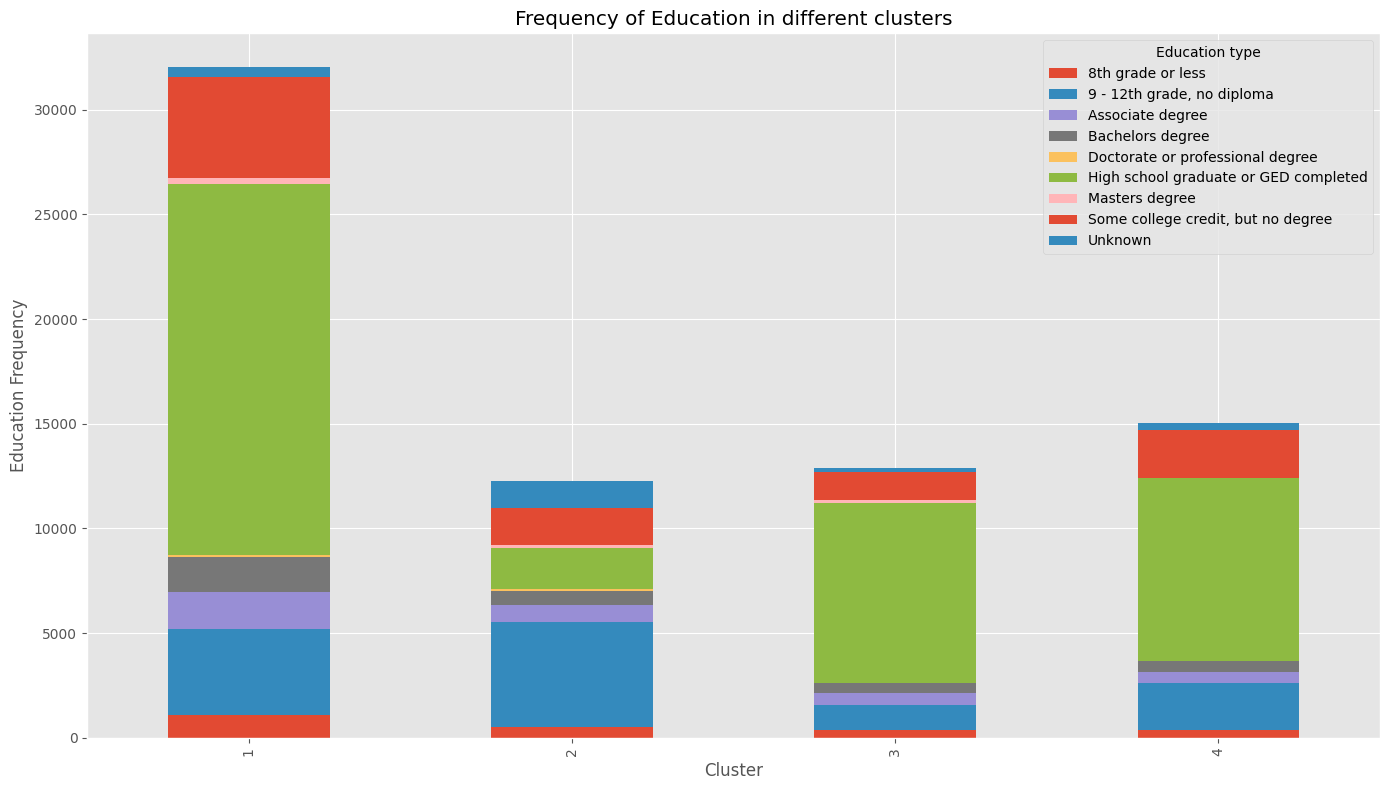

In [36]:
frequency_edu.plot(kind='bar', figsize=(14, 8), stacked=True) #color=['#DAA520', '#4682B4', '#20B2AA', '#C71585', '#FF4500']) #width=0.8 
plt.title('Frequency of Education in different clusters')
plt.ylabel('Education Frequency')
plt.xlabel('Cluster')
plt.legend(title='Education type') 
plt.tight_layout() #optimizes the spacing of everything
#plt.savefig('Education_without_death.png')
plt.show()

In [37]:
#Aggfuns specifies we are counting. Race/ Deaths
frequency_death = fen_df_mode.pivot_table(index='Clusters', columns='Death', aggfunc='size')

frequency_death

Death     Accidental Drug Poisoning  Other
Clusters                                  
1                             30070   1970
2                             11473    782
3                             12064    835
4                             14241    788

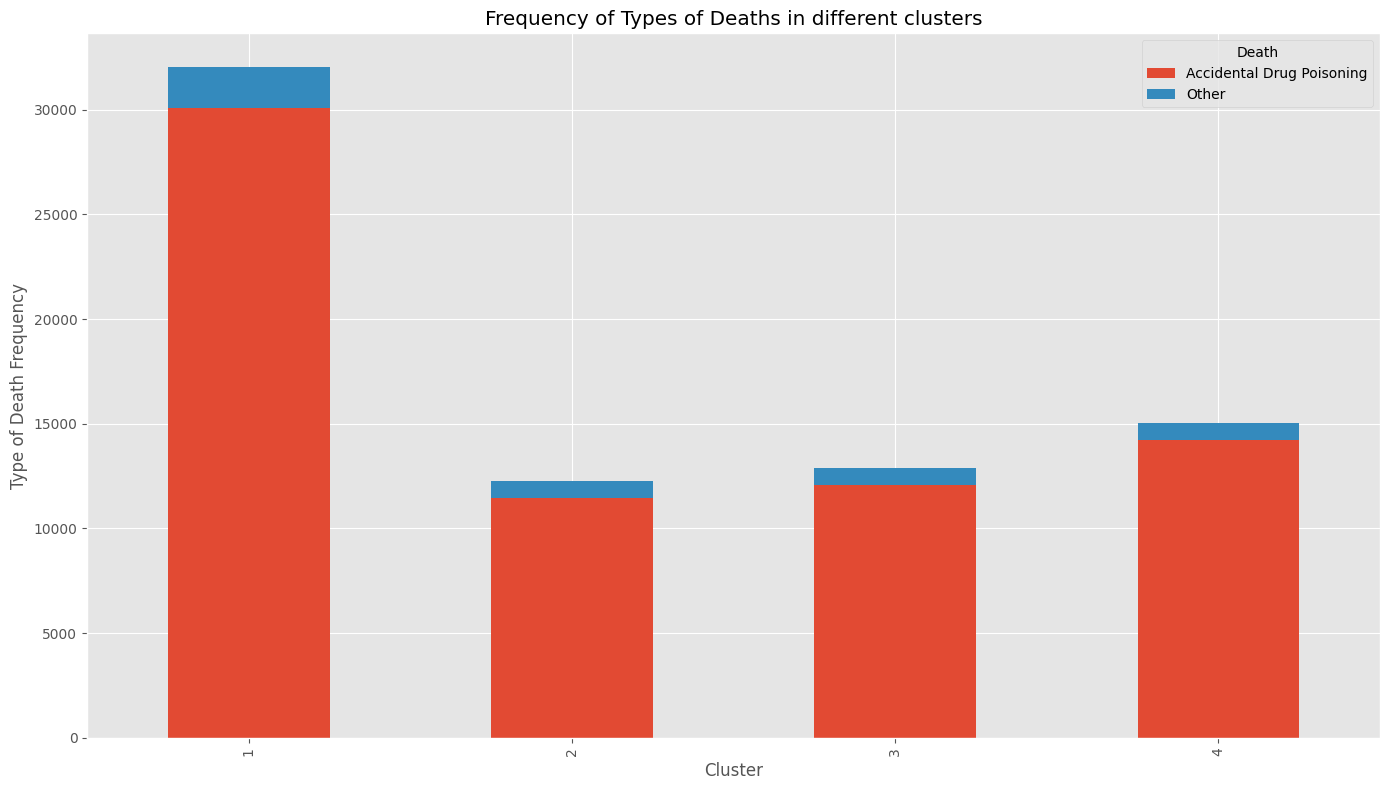

In [38]:
frequency_death.plot(kind='bar', figsize=(14, 8), stacked=True)
plt.title('Frequency of Types of Deaths in different clusters')
plt.ylabel('Type of Death Frequency')
plt.xlabel('Cluster')
plt.legend(title='Death') 
plt.tight_layout() #optimizes the spacing of everything
#plt.savefig('death_without_death.png')
plt.show()

In [39]:
#Pivot tables allow you to perform calculations such as sums, averages, and standard deviations, while Crosstab does not.
heat_edu = fen_df_mode.pivot_table(index='Education', columns='Clusters', aggfunc='size')
heat_edu

Clusters                                   1     2     3     4
Education                                                     
8th grade or less                       1092   507   376   372
9 - 12th grade, no diploma              4110  5034  1210  2262
Associate degree                        1759   789   551   518
Bachelors degree                        1690   696   466   496
Doctorate or professional degree          76    66    31    20
High school graduate or GED completed  17712  1981  8601  8721
Masters degree                           283   142    99    40
Some college credit, but no degree      4835  1768  1367  2255
Unknown                                  483  1272   198   345

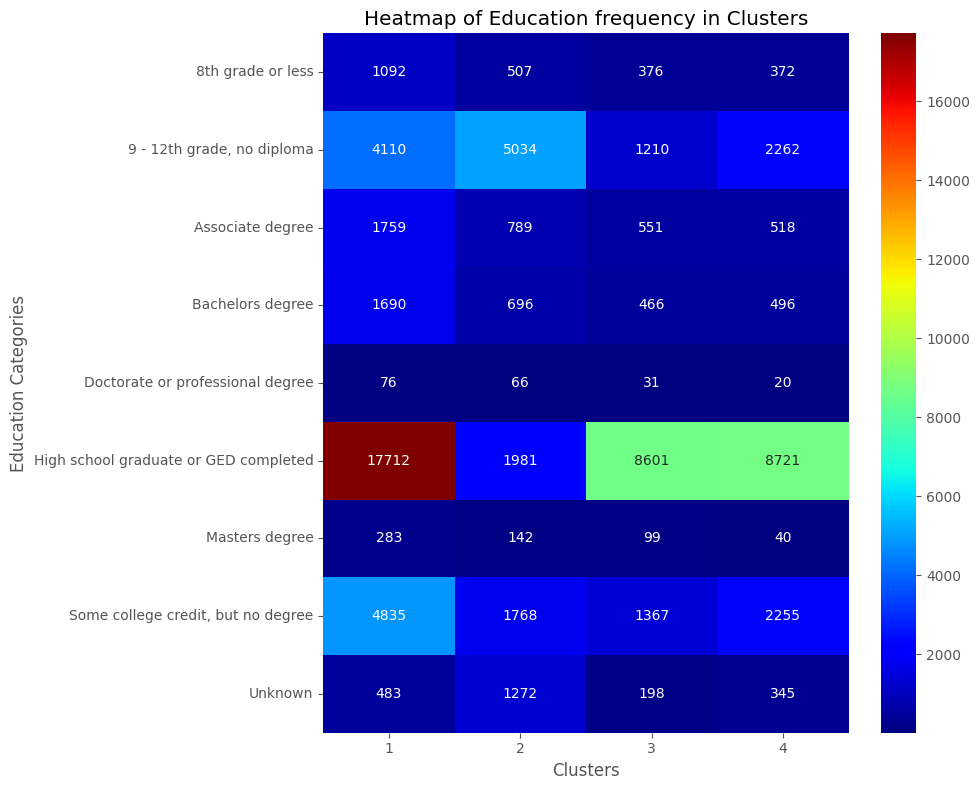

In [40]:
plt.figure(figsize=(10, 8))
sns.heatmap(heat_edu, annot=True, fmt="d", cmap="jet") #annot = annotations on each cell/ fmt = integer 
plt.title('Heatmap of Education frequency in Clusters')
plt.ylabel('Education Categories')
plt.xlabel('Clusters')
plt.tight_layout()
plt.savefig('edu_without_death.png')
plt.show()

# K mode clustering with rebalanced features 

In [196]:
fen_df_mode

Education Sex   AgeCategory  \
0         Some college credit, but no degree   M      51 to 65   
1                 9 - 12th grade, no diploma   M  18 and under   
2         Some college credit, but no degree   M      31 to 40   
3      High school graduate or GED completed   M      19 to 30   
4                          8th grade or less   M     65 and up   
...                                      ...  ..           ...   
72231                      8th grade or less   M      41 to 50   
72232  High school graduate or GED completed   F      51 to 65   
72233  High school graduate or GED completed   M      41 to 50   
72234  High school graduate or GED completed   M      51 to 65   
72235  High school graduate or GED completed   M      41 to 50   

               Marital Status              Race  \
0                    Divorced  Other/ Islanders   
1       Never married, single             White   
2       Never married, single             White   
3       Never married, single  Other/ Islanders   
4                    Divorced             White   
...                       ...               ...   
72231  Marital Status unknown             White   
72232                Divorced             White   
72233                Divorced             Black   
72234   Never married, single             White   
72235                 Married             Black   

                                         Occupation                      Death  
0                            Management Occupations  Accidental Drug Poisoning  
1                       Other, Misc (exc Housewife)  Accidental Drug Poisoning  
2                            Management Occupations  Accidental Drug Poisoning  
3          Farming, Fishing, & Forestry Occupations  Accidental Drug Poisoning  
4                            Management Occupations  Accidental Drug Poisoning  
...                                             ...                        ...  
72231         Construction & Extraction Occupations  Accidental Drug Poisoning  
72232                              Other, Housewife  Accidental Drug Poisoning  
72233  Transportation & Material Moving Occupations  Accidental Drug Poisoning  
72234                   Other, Misc (exc Housewife)  Accidental Drug Poisoning  
72235           Personal Care & Service Occupations  Accidental Drug Poisoning  

[72223 rows x 7 columns]

In [216]:
fen_df_mode['Death'].value_counts()

Accidental Drug Poisoning    67848
Other                         4375
Name: Death, dtype: int64

In [217]:
#Function to find the required number of resampled records. We're going to ensure both undersampling and oversampling can be done.
def determine_num_samples(records, unique_records, proportion):
    samples = int(records * proportion / (1 - proportion + proportion * unique_records / records))
    return samples

In [222]:
num_samples_long_duration = determine_num_samples(len(fen_df_mode), 67848, 0.0604)
print("Long Duration Upsample samples to add: ", num_samples_long_duration)

Long Duration Upsample samples to add:  4378


In [223]:
to_resample = fen_df_mode.loc[fen_df_mode['Death'] =="Accidental Drug Poisoning"]

In [224]:
our_resample = to_resample.sample(n = x , random_state=1)
fen_df_rebal = pd.concat([fen_df_mode.loc[fen_df_mode['Death'] != 'Accidental Drug Poisoning'], our_resample])

In [225]:
fen_df_rebal['Death'].value_counts()

Accidental Drug Poisoning    4378
Other                        4375
Name: Death, dtype: int64

In [226]:
cost=[] #For testing 
k=4
kmode= KModes(n_clusters=k, init='Huang', n_init=12, max_iter=100, random_state=34)
clusters=kmode.fit_predict(fen_df_rebal)
cost.append(kmode.cost_)
print(cost)
#clusters = kmode.fit_predict(x) #remove

clusters_dict = []

for c in clusters:
    clusters_dict.append(c)

fen_df_rebal['Clusters'] = clusters_dict
#df_dummy['Clusters'] = clusters_dict #remove

[23352.0]


In [227]:
#Gives mode for each profile for each cluster
print(kmode.cluster_centroids_)

[['High school graduate or GED completed' 'F' '31 to 40'
  'Never married, single' 'White' 'Construction & Extraction Occupations'
  'Other']
 ['High school graduate or GED completed' 'M' '31 to 40'
  'Never married, single' 'White' 'Other, Misc (exc Housewife)'
  'Accidental Drug Poisoning']
 ['High school graduate or GED completed' 'M' '41 to 50' 'Divorced'
  'White' 'Construction & Extraction Occupations'
  'Accidental Drug Poisoning']
 ['High school graduate or GED completed' 'M' '51 to 65'
  'Never married, single' 'Black' 'Construction & Extraction Occupations'
  'Other']]


In [228]:
fen_df_rebal['Clusters'].value_counts()

0    3208
1    2931
2    1385
3    1229
Name: Clusters, dtype: int64

# K mode clustering on entire DF with Death column without rebalancing

In [83]:
#https://github.com/nicodv/kmodes/blob/master/kmodes/kmodes.py
cost=[] #For testing 
k=4
kmode= KModes(n_clusters=k, init='Huang', n_init=12, max_iter=100, random_state=34)
clusters=kmode.fit_predict(fen_df_mode)
cost.append(kmode.cost_)
print(cost)
#clusters = kmode.fit_predict(x) #remove

clusters_dict = []

for c in clusters:
    clusters_dict.append(c)

fen_df_mode['Clusters'] = clusters_dict
#df_dummy['Clusters'] = clusters_dict #remove

[163772.0]


In [84]:
#Gives mode for each profile for each cluster
print(kmode.cluster_centroids_)

[['High school graduate or GED completed' 'M' '51 to 65' 'Divorced'
  'White' 'Construction & Extraction Occupations'
  'Accidental Drug Poisoning']
 ['High school graduate or GED completed' 'M' '41 to 50'
  'Never married, single' 'White' 'Other, Misc (exc Housewife)'
  'Accidental Drug Poisoning']
 ['High school graduate or GED completed' 'F' '31 to 40'
  'Never married, single' 'White' 'Other, Misc (exc Housewife)'
  'Accidental Drug Poisoning']
 ['High school graduate or GED completed' 'M' '31 to 40'
  'Never married, single' 'White' 'Construction & Extraction Occupations'
  'Accidental Drug Poisoning']]


In [85]:
fen_df_mode['Clusters'].value_counts()

1    23848
0    22701
3    13335
2    12339
Name: Clusters, dtype: int64

In [86]:
fen_df_mode[fen_df_mode['Clusters'] == 0].head(5)

Education Sex AgeCategory Marital Status  \
0      Some college credit, but no degree   M    51 to 65       Divorced   
4                       8th grade or less   M   65 and up       Divorced   
7   High school graduate or GED completed   M    51 to 65       Divorced   
11  High school graduate or GED completed   F    51 to 65       Divorced   
13  High school graduate or GED completed   M   65 and up        Married   

                Race                                      Occupation  \
0   Other/ Islanders                          Management Occupations   
4              White                          Management Occupations   
7              White     Office & Administrative Support Occupations   
11             White  Food Preparation & Serving Related Occupations   
13  Other/ Islanders           Construction & Extraction Occupations   

                        Death  Clusters  
0   Accidental Drug Poisoning         0  
4   Accidental Drug Poisoning         0  
7   Accidental Drug Poisoning         0  
11  Accidental Drug Poisoning         0  
13  Accidental Drug Poisoning         0

In [87]:
#Aggfuns specifies we are counting. Race
frequency_race = fen_df_mode.pivot_table(index='Clusters', columns='Race', aggfunc='size')

frequency_race

Race      Asian  Black  Mixed  Other/ Islanders  White
Clusters                                              
0            92   4727    178               236  17468
1           239   5130    372               336  17771
2            84   2562    237               232   9224
3           110   1858    200               189  10978

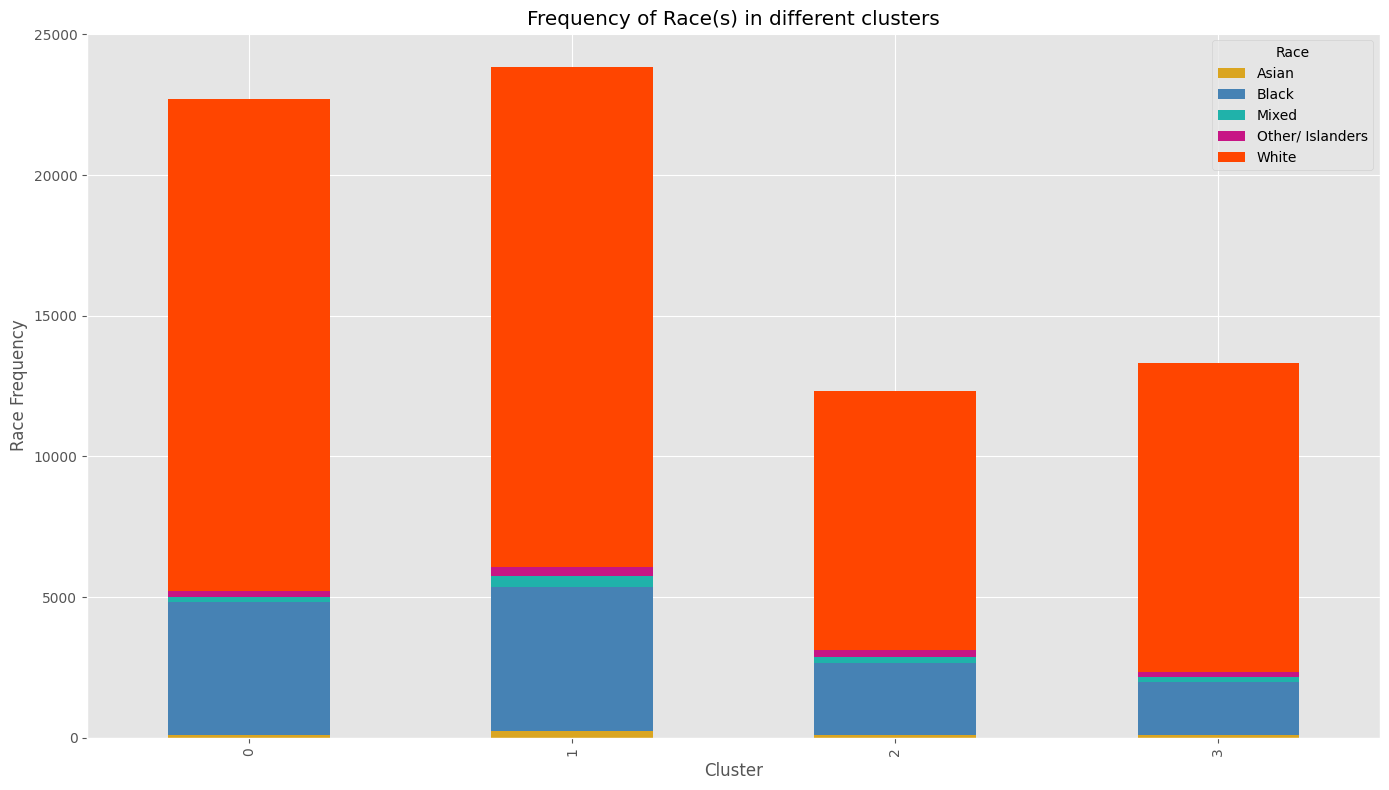

In [88]:
frequency_race.plot(kind='bar', figsize=(14, 8), stacked=True, color=['#DAA520', '#4682B4', '#20B2AA', '#C71585', '#FF4500']) #width=0.8 
plt.title('Frequency of Race(s) in different clusters')
plt.ylabel('Race Frequency')
plt.xlabel('Cluster')
plt.legend(title='Race') 
plt.tight_layout() #optimizes the spacing of everything

plt.show()

In [89]:
#Aggfuns specifies we are counting. Race/ Deaths
frequency_death = fen_df_mode.pivot_table(index='Clusters', columns='Death', aggfunc='size')

frequency_death

Death     Accidental Drug Poisoning  Other
Clusters                                  
0                             21236   1465
1                             22538   1310
2                             11422    917
3                             12652    683

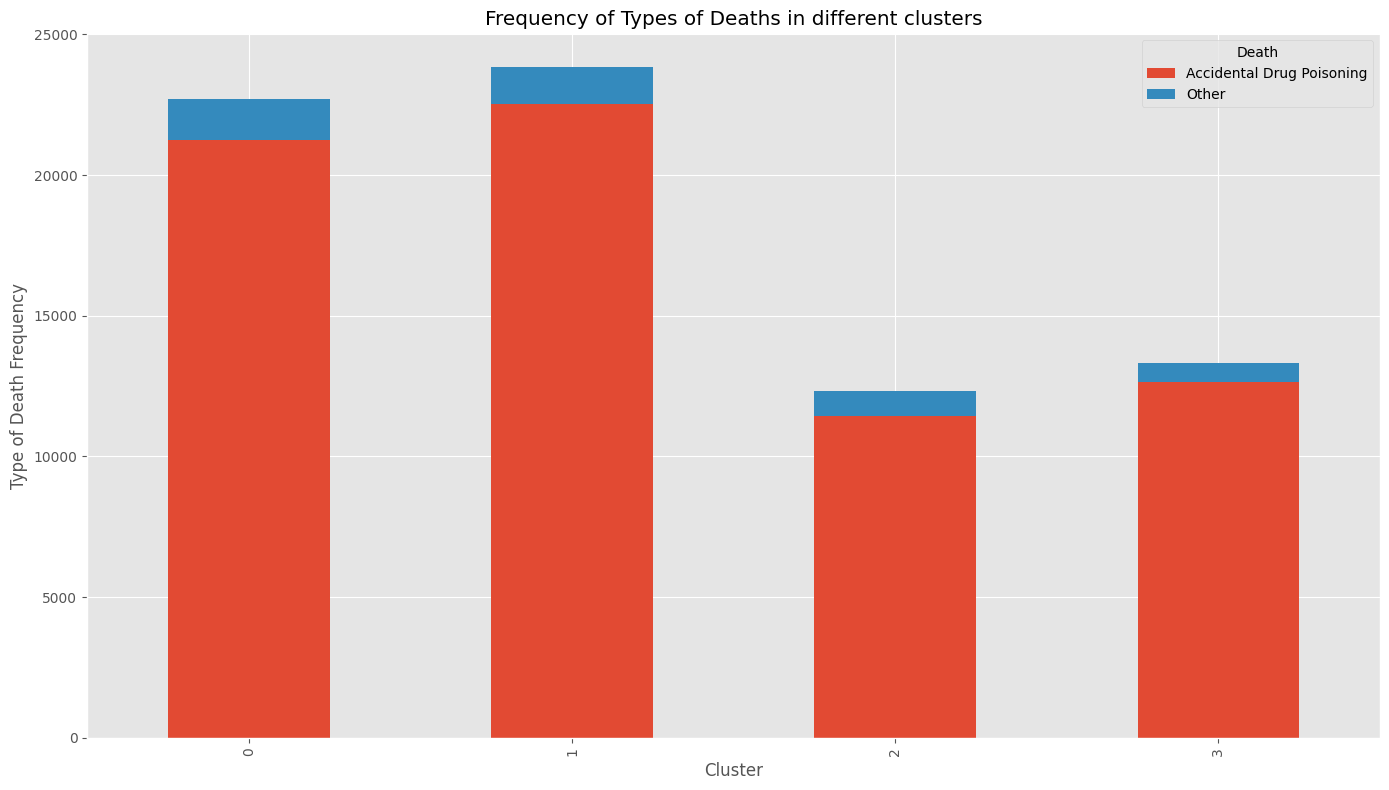

In [90]:
frequency_death.plot(kind='bar', figsize=(14, 8), stacked=True)
plt.title('Frequency of Types of Deaths in different clusters')
plt.ylabel('Type of Death Frequency')
plt.xlabel('Cluster')
plt.legend(title='Death') 
plt.tight_layout() #optimizes the spacing of everything

plt.show()

In [91]:
#Pivot tables allow you to perform calculations such as sums, averages, and standard deviations, while Crosstab does not.
heat_age = fen_df_mode.pivot_table(index='AgeCategory', columns='Clusters', aggfunc='size')
heat_age

Clusters          0      1     2      3
AgeCategory                            
18 and under      1    643   363     23
19 to 30        942   8529  4120   1848
31 to 40       1886   2031  5832  11397
41 to 50       4256  11068     0      0
51 to 65      14427   1046  1632      0
65 and up      1189    531   392     67

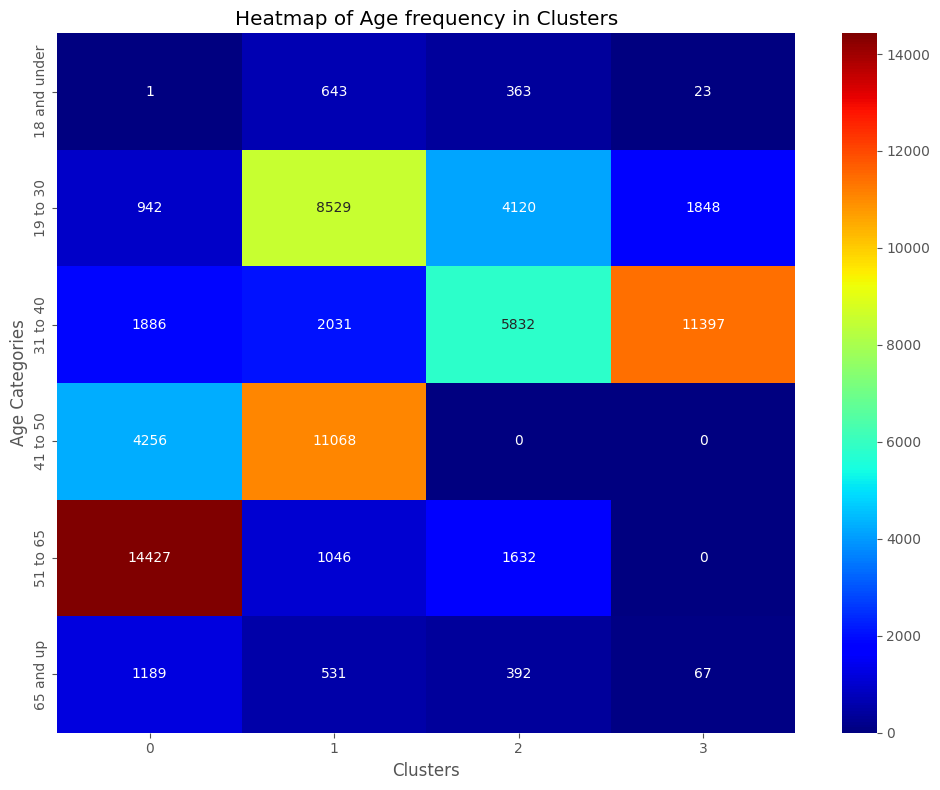

In [92]:
plt.figure(figsize=(10, 8))
sns.heatmap(heat_age, annot=True, fmt="d", cmap="jet") #annot = annotations on each cell/ fmt = integer 
plt.title('Heatmap of Age frequency in Clusters')
plt.ylabel('Age Categories')
plt.xlabel('Clusters')
plt.tight_layout()

plt.show()

# PCA Scatterplot

In [36]:
#df_pca = df_dummy.iloc[:, :-1]
#scaler = StandardScaler()
#scaled_df = df_pca.copy()
#scaled_df=pd.DataFrame(scaler.fit_transform(scaled_df), columns=scaled_df.columns)

In [48]:
#pca = PCA(n_components=50)

#fit PCA model to data
#pca_fit = pca.fit(scaled_df)

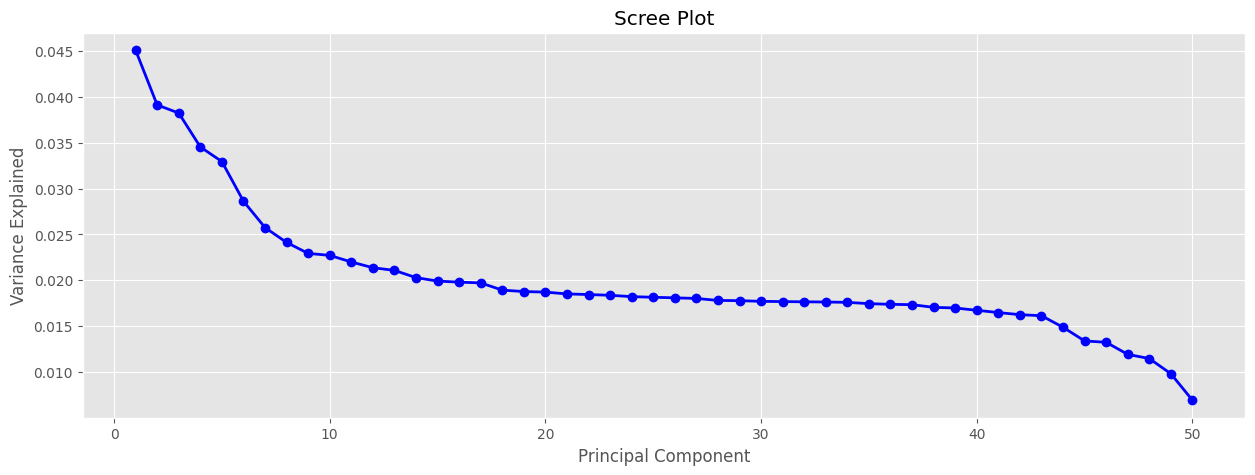

[0.04506175 0.03909845 0.03822045 0.03452738 0.03293613 0.02862007
 0.02574622 0.02412728 0.02293502 0.02271851 0.02200152 0.02137483
 0.02108505 0.02029529 0.0199204  0.01980219 0.01972181 0.01893463
 0.01877997 0.01871887 0.01852182 0.01845359 0.01837212 0.0182252
 0.01815738 0.01809474 0.01802903 0.01781212 0.01778651 0.01771275
 0.0176865  0.01766208 0.01763945 0.01760209 0.01746223 0.01738641
 0.01735051 0.01706018 0.01698991 0.01673734 0.01649038 0.01626039
 0.01614758 0.0148908  0.01339857 0.01325273 0.01193677 0.01148189
 0.00982921 0.00694387]


In [49]:
#PC_values = np.arange(pca.n_components_) + 1
#plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
#plt.title('Scree Plot')
#plt.xlabel('Principal Component')
#plt.ylabel('Variance Explained')
#plt.show()
#print(pca.explained_variance_ratio_)

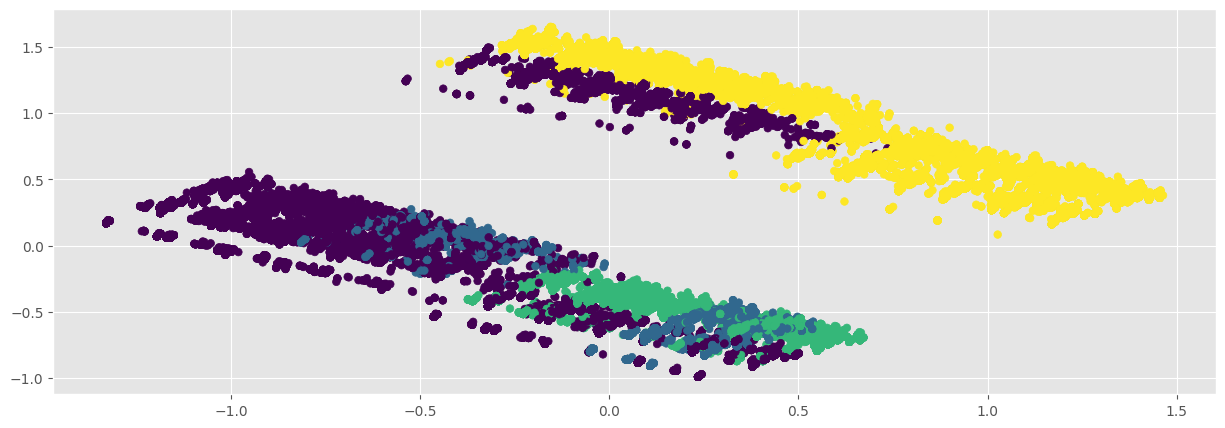

In [62]:
#pca = PCA(n_components=45)
# Turn the dummified df into two columns with PCA
#plot_columns = pca.fit_transform(df_dummy.iloc[:,:-1])

# Plot based on the two dimensions, and shade by cluster label
#plt.scatter(x=plot_columns[:,1], y=plot_columns[:,0], c=df_dummy["Clusters"], s=30)
#plt.show()

In [ ]:
#Analysis on minority groups - Remove majority groups (White/ Low educated/ etc) and only do analysis on groups that are not represented as much

# K-Means

In [304]:
fen_df2 = pd.get_dummies(fen_df, columns = ['Education', 'Sex', 'AgeCategory', 'Marital Status', 'Race', 'Occupation'], prefix=['dummy', 'dummy', 'dummy','dummy', 'dummy', 'dummy'])

#Dropping Condition columns as they aren't required.
col_to_drop = [c for c in fen_df2.columns if 'Condition' in c]

fen_df2 = fen_df2.drop(columns=col_to_drop)
fen_df2 = fen_df2.drop(columns=['Death Recode', 'Month of Death', 'Manner of Death', 'Age'], axis=1)

In [305]:
fen_df2.head()

Death  dummy_8th grade or less  \
0  Accidental Drug Poisoning                        0   
1  Accidental Drug Poisoning                        0   
2  Accidental Drug Poisoning                        0   
3  Accidental Drug Poisoning                        0   
4  Accidental Drug Poisoning                        1   

   dummy_9 - 12th grade, no diploma  dummy_Associate degree  \
0                                 0                       0   
1                                 1                       0   
2                                 0                       0   
3                                 0                       0   
4                                 0                       0   

   dummy_Bachelors degree  dummy_Doctorate or professional degree  \
0                       0                                       0   
1                       0                                       0   
2                       0                                       0   
3                       0                                       0   
4                       0                                       0   

   dummy_High school graduate or GED completed  dummy_Masters degree  \
0                                            0                     0   
1                                            0                     0   
2                                            0                     0   
3                                            1                     0   
4                                            0                     0   

   dummy_Some college credit, but no degree  dummy_Unknown  ...  \
0                                         1              0  ...   
1                                         0              0  ...   
2                                         1              0  ...   
3                                         0              0  ...   
4                                         0              0  ...   

   dummy_Military  dummy_Office & Administrative Support Occupations  \
0               0                                                  0   
1               0                                                  0   
2               0                                                  0   
3               0                                                  0   
4               0                                                  0   

   dummy_Other, Housewife  dummy_Other, Misc (exc Housewife)  \
0                       0                                  0   
1                       0                                  1   
2                       0                                  0   
3                       0                                  0   
4                       0                                  0   

   dummy_Personal Care & Service Occupations  dummy_Production Occupations  \
0                                          0                             0   
1                                          0                             0   
2                                          0                             0   
3                                          0                             0   
4                                          0                             0   

   dummy_Protective Service Occupations  dummy_Sales & Related Occupations  \
0                                     0                                  0   
1                                     0                                  0   
2                                     0                                  0   
3                                     0                                  0   
4                                     0                                  0   

   dummy_Transportation & Material Moving Occupations  dummy_Unknown  
0                                                  0               0  
1                                                  0               0  
2                                                  0               0  
3         

In [306]:
#Scales each feature and gives it a value between [0,1]
scaler = preprocessing.MinMaxScaler()
scaled_data = scaler.fit_transform(fen_df2.drop('Death', axis=1))

Fit 2 clusters
Fit 7 clusters
Fit 12 clusters
Fit 17 clusters
Fit 22 clusters
Fit 27 clusters
Fit 32 clusters
Fit 37 clusters
Fit 42 clusters
Fit 47 clusters
Fit 52 clusters
Fit 57 clusters
Fit 62 clusters
Fit 67 clusters
Fit 72 clusters
Fit 77 clusters
Fit 82 clusters
Fit 87 clusters
Fit 92 clusters
Fit 97 clusters


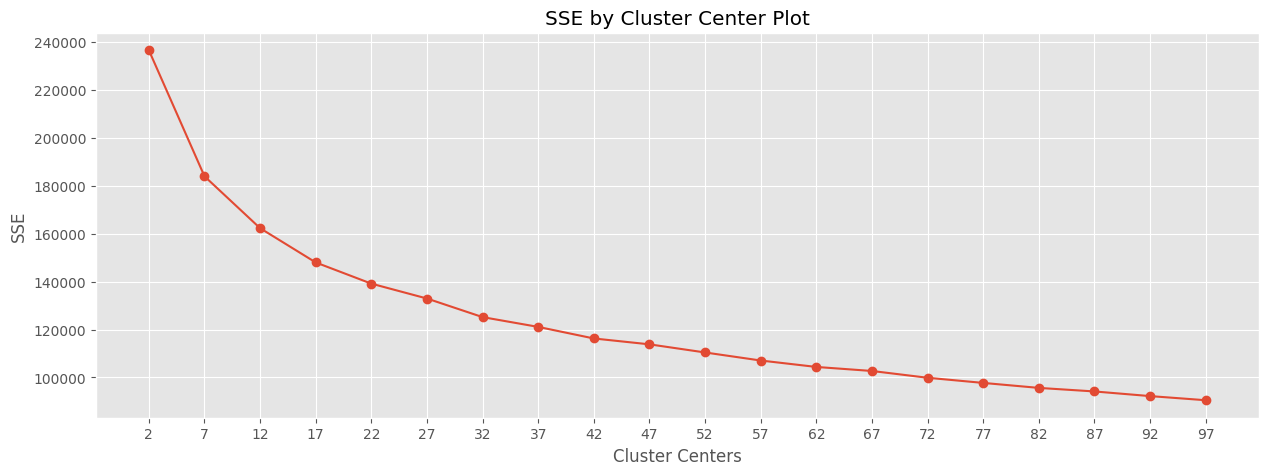

In [307]:
#Elbow method to find the number of clusters or k we are going to implement
def find_num_clusters(data, k):
    iters = range(2, k+1, 5)
    
    sse = [] #sum of squared error
    for i in iters:
        sse.append(KMeans(n_clusters=i, n_init = 10, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(i))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_num_clusters(fen_df2.drop('Death',axis=1), 100)

In [308]:
k=12
km = KMeans(n_clusters=k, n_init = 10, random_state=20).fit(fen_df2.drop('Death',axis=1))

fen_df2['Clusters'] = km.labels_

profiles_arr = []

profiles_arr = km.labels_

profiles_arr[:10]

array([11,  4,  3,  2, 10,  3,  3, 11,  9,  2], dtype=int32)

In [309]:
fen_df2['Clusters'].value_counts()

3     9407
2     8881
8     7568
6     7457
7     5846
10    5718
9     5281
11    4961
5     4699
4     4302
1     4193
0     3910
Name: Clusters, dtype: int64

In [ ]:
#top key features
def get_keyfeatures(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()

    for i, x in df.iterrows():
        print('\n Mode Clusters {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(x)[-n_terms:]]))

get_keyfeatures(fen_df2, clusters, fen_df2.get_feature_names_out(), 10)

# Splitting DataFrame based on clusters

In [42]:
cluster_1 = fen_df_mode[fen_df_mode['Clusters'] == 1]

In [43]:
cluster_2 = fen_df_mode[fen_df_mode['Clusters'] == 2]

In [44]:
cluster_3 = fen_df_mode[fen_df_mode['Clusters'] == 3]

In [45]:
cluster_4 = fen_df_mode[fen_df_mode['Clusters'] == 4]

In [46]:
clusters = [cluster_1, cluster_2, cluster_3, cluster_4]

for c in clusters:
    print(c['Death'].value_counts())
    c.reset_index(drop=True, inplace=True)

Accidental Drug Poisoning    30070
Other                         1970
Name: Death, dtype: int64
Accidental Drug Poisoning    11473
Other                          782
Name: Death, dtype: int64
Accidental Drug Poisoning    12064
Other                          835
Name: Death, dtype: int64
Accidental Drug Poisoning    14241
Other                          788
Name: Death, dtype: int64


# Cluster 1: RF Modeling/ OverSampling 45%/ Tuning.

In [250]:
cluster_1 = cluster_1.drop('Clusters', axis=1)
cluster_1.head()

Education Sex AgeCategory  \
0     Some college credit, but no degree   M    31 to 40   
1  High school graduate or GED completed   M    31 to 40   
2                                Unknown   M    31 to 40   
3             9 - 12th grade, no diploma   F    31 to 40   
4  High school graduate or GED completed   F    19 to 30   

          Marital Status              Race  \
0  Never married, single             White   
1  Never married, single  Other/ Islanders   
2  Never married, single  Other/ Islanders   
3               Divorced  Other/ Islanders   
4  Never married, single             White   

                                       Occupation                      Death  
0                          Management Occupations  Accidental Drug Poisoning  
1  Food Preparation & Serving Related Occupations  Accidental Drug Poisoning  
2           Construction & Extraction Occupations  Accidental Drug Poisoning  
3                                Other, Housewife  Accidental Drug Poisoning  
4  Food Preparation & Serving Related Occupations  Accidental Drug Poisoning

In [251]:
cluster_1 = pd.get_dummies(cluster_1, columns=['Education', 'Sex', 'AgeCategory', 'Marital Status', 'Race', 'Occupation', 'Death'], prefix=['dummy_edu','dummy_sex','dummy_age', 'dummy_marital', 'dummy_race', 'dummy_occupation', 'dummy_death'])
cluster_1.head()

dummy_edu_8th grade or less  dummy_edu_9 - 12th grade, no diploma  \
0                            0                                     0   
1                            0                                     0   
2                            0                                     0   
3                            0                                     1   
4                            0                                     0   

   dummy_edu_Associate degree  dummy_edu_Bachelors degree  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           0                           0   

   dummy_edu_Doctorate or professional degree  \
0                                           0   
1                                           0   
2                                           0   
3                                           0   
4                                           0   

   dummy_edu_High school graduate or GED completed  dummy_edu_Masters degree  \
0                                                0                         0   
1                                                1                         0   
2                                                0                         0   
3                                                0                         0   
4                                                1                         0   

   dummy_edu_Some college credit, but no degree  dummy_edu_Unknown  \
0                                             1                  0   
1                                             0                  0   
2                                             0                  1   
3                                             0                  0   
4                                             0                  0   

   dummy_sex_F  ...  dummy_occupation_Other, Housewife  \
0            0  ...                                  0   
1            0  ...                                  0   
2            0  ...                                  0   
3            1  ...                                  1   
4            1  ...                                  0   

   dummy_occupation_Other, Misc (exc Housewife)  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             0   

   dummy_occupation_Personal Care & Service Occupations  \
0                                                  0      
1                                                  0      
2                                                  0      
3                                                  0      
4                                                  0      

   dummy_occupation_Production Occupations  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

   dummy_occupation_Protective Service Occupations  \
0                                                0   
1                                                0   
2                                                0   
3                                                0   
4                                                0   

   dummy_occupation_Sales & Related Occupations  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             0   

   dummy_occupation_Transportation & Material Moving Occupations  \
0                 

In [252]:
# Death attribute has two values only so we can drop one of them since they are considered redundant. We are predicting Accidental or not, so only 1 column is suffice. 
cluster_1.drop('dummy_death_Other', axis=1, inplace=True)
cluster_1.rename(columns={'dummy_death_Accidental Drug Poisoning': 'Death'}, inplace=True)
cluster_1.drop('dummy_sex_F', axis=1, inplace=True)
#1 = Accidental, 0 = Other

In [253]:
clus_train, clus_test = train_test_split(cluster_1, test_size=0.25, random_state=34)
print(clus_train.shape)
print(clus_test.shape)

(24030, 53)
(8010, 53)


In [254]:
kfold = StratifiedKFold(n_splits= 10, shuffle=True, random_state=34)

In [255]:
print(clus_train["Death"].count())
print(clus_train["Death"].value_counts(normalize = True))
clus_train["Death"].value_counts()

24030
1    0.937703
0    0.062297
Name: Death, dtype: float64


1    22533
0     1497
Name: Death, dtype: int64

In [256]:
def determine_num_samples(records, unique_records, proportion):
    x = int((proportion * records - unique_records) / (1 - proportion))
    return x

In [257]:
num_samples_other_deaths = determine_num_samples(len(clus_train), 1497, 0.2)
print("Other Deaths Upsample samples to add: ", num_samples_other_deaths)

Other Deaths Upsample samples to add:  4136


In [258]:
to_resample = clus_train.loc[clus_train['Death'] == 0]

In [259]:
our_resample = to_resample.sample(n = 4136 , replace = True)
clus_train_rebal = pd.concat([clus_train, our_resample])

In [260]:
clus_train_rebal['Death'].value_counts()

1    22533
0     5633
Name: Death, dtype: int64

In [261]:
x_train = clus_train_rebal.drop('Death', axis=1)
y_train = clus_train_rebal['Death']

In [262]:
x_test = clus_test.drop('Death', axis=1)
y_test = clus_test['Death']

In [263]:
#Using CrossValidation for model selection: 
models_dict = {'RandomForest': RandomForestClassifier(n_estimators = 10, criterion='gini', random_state = 34), 
               'NaiveBayes': MultinomialNB(alpha=1.0, fit_prior=True), 
               'XGBoost': XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic'),
               'Decision Tree': DecisionTreeClassifier(criterion="entropy",max_leaf_nodes=5, random_state = 34)}

model_cv_score = {}

for name, model in models_dict.items():
    score = cross_val_score(model, x_train, y_train, cv=kfold)
    model_cv_score[name] = score.mean()

print(f'Model Scores: {model_cv_score}\n')

Model Scores: {'RandomForest': 0.8238299402773743, 'NaiveBayes': 0.8006817375028238, 'XGBoost': 0.8118299609513666, 'Decision Tree': 0.8103033757099751}



In [137]:
#We are going to use XGBoost or DecisionTree as they have the highest accuracies (using stratified k fold cv)
params = {
    "n_estimators": [100, 200, 300, 400, 500],  # Number of trees in the forest
    "max_depth": [10, 15, 20, 30, 40],  # Maximum depth of the tree
    "min_samples_split": [2, 4, 6, 8, 10],  # Minimum number of samples required to split an internal node
    "criterion": ["gini", "entropy"],  # Function to measure the quality of a split
}

rf01 = GridSearchCV(RandomForestClassifier(), param_grid = params, cv = kfold, n_jobs = -1, verbose = 1)
rf01.fit(x_train, y_train)

print("Best Parameters : ", rf01.best_params_)
print("Best Accuracy through grid search : %.3f"%rf01.best_score_)

Fitting 10 folds for each of 250 candidates, totalling 2500 fits


KeyboardInterrupt: 

In [264]:


print(f'Our baseline model is {y_train.value_counts(normalize = True)[0] * 100}% accurate')
print(f'Our baseline model based on the testing partition is {y_test.value_counts(normalize = True)[0] * 100}% accurate')

Our baseline model is 19.99928992402187% accurate
Our baseline model based on the testing partition is 5.905118601747815% accurate


In [265]:
rf02 = RandomForestClassifier(criterion = 'gini', max_depth = 40, min_samples_split = 2, n_estimators = 100, random_state=34, class_weight = 'balanced').fit(x_train, y_train)
rf02_score = cross_val_score(rf02, x_train, y_train, cv=kfold)

In [266]:


print(f"Our CART Classification Decision Tree model with the best optimized parameters on the Testing set is : {rf02.score(x_test, y_test) * 100}% accurate")
print(f"Our CART Classification Decision model with the best optimal parameters with stratified k-fold cross validation on the training dataset is on average : {rf02_score.mean() * 100}% accurate")

Our CART Classification Decision Tree model with the best optimized parameters on the Testing set is : 67.71535580524345% accurate
Our CART Classification Decision model with the best optimal parameters with stratified k-fold cross validation on the training dataset is on average : 69.1685689260819% accurate


In [267]:
prediction_rf = rf02.predict(x_test)

print("Classification Report")
print(classification_report(y_test, prediction_rf))
print("===========")
print("Confusion Matrix")
print(confusion_matrix(y_test, prediction_rf))
print("============")
print("Accuracy Score is : ", accuracy_score(prediction_rf, y_test))
print("==============")

test_predictions_proba = rf02.predict_proba(x_test)
ll = log_loss(y_test, test_predictions_proba)
print("Log Loss: {:.4}".format(ll))
print("===============")

Classification Report
              precision    recall  f1-score   support

           0       0.06      0.32      0.11       473
           1       0.94      0.70      0.80      7537

    accuracy                           0.68      8010
   macro avg       0.50      0.51      0.45      8010
weighted avg       0.89      0.68      0.76      8010

Confusion Matrix
[[ 152  321]
 [2265 5272]]
Accuracy Score is :  0.6771535580524345
Log Loss: 0.8011


# Cluster 1: RF Modeling (Oversample) & Categorical Target Feature. No tuning

In [269]:
cluster_1 = cluster_1.drop('Clusters', axis=1)
cluster_1.head()

Education Sex AgeCategory  \
2      Some college credit, but no degree   M    31 to 40   
5   High school graduate or GED completed   M    31 to 40   
6                                 Unknown   M    31 to 40   
10             9 - 12th grade, no diploma   F    31 to 40   
14  High school graduate or GED completed   F    19 to 30   

           Marital Status              Race  \
2   Never married, single             White   
5   Never married, single  Other/ Islanders   
6   Never married, single  Other/ Islanders   
10               Divorced  Other/ Islanders   
14  Never married, single             White   

                                        Occupation                      Death  
2                           Management Occupations  Accidental Drug Poisoning  
5   Food Preparation & Serving Related Occupations  Accidental Drug Poisoning  
6            Construction & Extraction Occupations  Accidental Drug Poisoning  
10                                Other, Housewife  Accidental Drug Poisoning  
14  Food Preparation & Serving Related Occupations  Accidental Drug Poisoning

In [270]:
cluster_1 = pd.get_dummies(cluster_1, columns=['Education', 'Sex', 'AgeCategory', 'Marital Status', 'Race', 'Occupation'], prefix=['dummy_edu','dummy_sex','dummy_age', 'dummy_marital', 'dummy_race', 'dummy_occupation'])
cluster_1.head()

Death  dummy_edu_8th grade or less  \
2   Accidental Drug Poisoning                            0   
5   Accidental Drug Poisoning                            0   
6   Accidental Drug Poisoning                            0   
10  Accidental Drug Poisoning                            0   
14  Accidental Drug Poisoning                            0   

    dummy_edu_9 - 12th grade, no diploma  dummy_edu_Associate degree  \
2                                      0                           0   
5                                      0                           0   
6                                      0                           0   
10                                     1                           0   
14                                     0                           0   

    dummy_edu_Bachelors degree  dummy_edu_Doctorate or professional degree  \
2                            0                                           0   
5                            0                                           0   
6                            0                                           0   
10                           0                                           0   
14                           0                                           0   

    dummy_edu_High school graduate or GED completed  dummy_edu_Masters degree  \
2                                                 0                         0   
5                                                 1                         0   
6                                                 0                         0   
10                                                0                         0   
14                                                1                         0   

    dummy_edu_Some college credit, but no degree  dummy_edu_Unknown  ...  \
2                                              1                  0  ...   
5                                              0                  0  ...   
6                                              0                  1  ...   
10                                             0                  0  ...   
14                                             0                  0  ...   

    dummy_occupation_Military  \
2                           0   
5                           0   
6                           0   
10                          0   
14                          0   

    dummy_occupation_Office & Administrative Support Occupations  \
2                                                   0              
5                                                   0              
6                                                   0              
10                                                  0              
14                                                  0              

    dummy_occupation_Other, Housewife  \
2                                   0   
5                                   0   
6                                   0   
10                                  1   
14                                  0   

    dummy_occupation_Other, Misc (exc Housewife)  \
2                                              0   
5                                              0   
6                                              0   
10                                             0   
14                                             0   

    dummy_occupation_Personal Care & Service Occupations  \
2                                                   0      
5                                                   0      
6                                                   0      
10                                                  0      
14                                                  0      

    dummy_occupation_Production Occupations  \
2                                         0   
5                                         0   
6                                         0   
10                                        0   
14                                       

In [271]:
clus_train, clus_test = train_test_split(cluster_1, test_size=0.25, random_state=34)
print(clus_train.shape)
print(clus_test.shape)

(24030, 54)
(8010, 54)


In [272]:
kfold = StratifiedKFold(n_splits= 10, shuffle=True, random_state=34)

In [273]:
print(clus_train["Death"].count())
print(clus_train["Death"].value_counts(normalize = True))
clus_train["Death"].value_counts()

24030
Accidental Drug Poisoning    0.937703
Other                        0.062297
Name: Death, dtype: float64


Accidental Drug Poisoning    22533
Other                         1497
Name: Death, dtype: int64

In [274]:
def determine_num_samples(records, unique_records, proportion):
    x = int((proportion * records - unique_records) / (1 - proportion))
    return x

In [275]:
num_samples_other_deaths = determine_num_samples(len(clus_train), 1497, 0.45)
print("Other Deaths Upsample samples to add: ", num_samples_other_deaths)

Other Deaths Upsample samples to add:  16939


In [276]:
to_resample = clus_train.loc[clus_train['Death'] =='Other']

In [277]:
our_resample = to_resample.sample(n = 16939 , replace = True)
clus_train_rebal = pd.concat([clus_train, our_resample])

In [278]:
clus_train_rebal['Death'].value_counts()

Accidental Drug Poisoning    22533
Other                        18436
Name: Death, dtype: int64

In [279]:
x_train = clus_train_rebal.drop('Death', axis=1)
y_train = clus_train_rebal['Death']

In [280]:
x_test = clus_test.drop('Death', axis=1)
y_test = clus_test['Death']

In [281]:


print(f'Our baseline model is {y_train.value_counts(normalize = True)[0] * 100}% accurate')
print(f'Our baseline model based on the testing partition is {y_test.value_counts(normalize = True)[0] * 100}% accurate')

Our baseline model is 55.000122043496305% accurate
Our baseline model based on the testing partition is 94.09488139825218% accurate


In [282]:
cart02 = RandomForestClassifier(criterion = 'gini', max_depth = 30, min_samples_split = 2, n_estimators = 300, 
                                random_state=34, class_weight = 'balanced').fit(x_train, y_train)
cart02_score = cross_val_score(cart02, x_train, y_train, cv=kfold)

In [283]:


print(f"Our CART Classification Decision Tree model with the best optimized parameters on the Testing set is : {cart02.score(x_test, y_test) * 100}% accurate")
print(f"Our CART Classification Decision model with the best optimal parameters with stratified k-fold cross validation on the training dataset is on average : {cart02_score.mean() * 100}% accurate")

Our CART Classification Decision Tree model with the best optimized parameters on the Testing set is : 68.07740324594256% accurate
Our CART Classification Decision model with the best optimal parameters with stratified k-fold cross validation on the training dataset is on average : 69.71123533130186% accurate


In [284]:


prediction_cart02 = cart02.predict(x_test)

print("Classification Report")
print(classification_report(y_test, prediction_cart02))
print("===========")
print("Confusion Matrix")
print(confusion_matrix(y_test, prediction_cart02))
print("============")
print("Accuracy Score is : ", accuracy_score(prediction_cart02, y_test))
print("==============")

test_predictions_proba = cart02.predict_proba(x_test)
ll = log_loss(y_test, test_predictions_proba)
print("Log Loss: {:.4}".format(ll))
print("===============")

Classification Report
                           precision    recall  f1-score   support

Accidental Drug Poisoning       0.94      0.70      0.81      7537
                    Other       0.07      0.33      0.11       473

                 accuracy                           0.68      8010
                macro avg       0.50      0.52      0.46      8010
             weighted avg       0.89      0.68      0.76      8010

Confusion Matrix
[[5297 2240]
 [ 317  156]]
Accuracy Score is :  0.6807740324594257
Log Loss: 0.6032


# Cluster 1: DecisionTree Modeling/ Tuning/ No oversampling:

In [290]:
cluster_1 = cluster_1.drop('Clusters', axis=1)
cluster_1.head()

Education Sex AgeCategory  \
0     Some college credit, but no degree   M    31 to 40   
1  High school graduate or GED completed   M    31 to 40   
2                                Unknown   M    31 to 40   
3             9 - 12th grade, no diploma   F    31 to 40   
4  High school graduate or GED completed   F    19 to 30   

          Marital Status              Race  \
0  Never married, single             White   
1  Never married, single  Other/ Islanders   
2  Never married, single  Other/ Islanders   
3               Divorced  Other/ Islanders   
4  Never married, single             White   

                                       Occupation                      Death  
0                          Management Occupations  Accidental Drug Poisoning  
1  Food Preparation & Serving Related Occupations  Accidental Drug Poisoning  
2           Construction & Extraction Occupations  Accidental Drug Poisoning  
3                                Other, Housewife  Accidental Drug Poisoning  
4  Food Preparation & Serving Related Occupations  Accidental Drug Poisoning

In [291]:
cluster_1 = pd.get_dummies(cluster_1, columns=['Education', 'Sex', 'AgeCategory', 'Marital Status', 'Race', 'Occupation'], prefix=['dummy_edu','dummy_sex','dummy_age', 'dummy_marital', 'dummy_race', 'dummy_occupation'])
cluster_1.head()

Death  dummy_edu_8th grade or less  \
0  Accidental Drug Poisoning                            0   
1  Accidental Drug Poisoning                            0   
2  Accidental Drug Poisoning                            0   
3  Accidental Drug Poisoning                            0   
4  Accidental Drug Poisoning                            0   

   dummy_edu_9 - 12th grade, no diploma  dummy_edu_Associate degree  \
0                                     0                           0   
1                                     0                           0   
2                                     0                           0   
3                                     1                           0   
4                                     0                           0   

   dummy_edu_Bachelors degree  dummy_edu_Doctorate or professional degree  \
0                           0                                           0   
1                           0                                           0   
2                           0                                           0   
3                           0                                           0   
4                           0                                           0   

   dummy_edu_High school graduate or GED completed  dummy_edu_Masters degree  \
0                                                0                         0   
1                                                1                         0   
2                                                0                         0   
3                                                0                         0   
4                                                1                         0   

   dummy_edu_Some college credit, but no degree  dummy_edu_Unknown  ...  \
0                                             1                  0  ...   
1                                             0                  0  ...   
2                                             0                  1  ...   
3                                             0                  0  ...   
4                                             0                  0  ...   

   dummy_occupation_Military  \
0                          0   
1                          0   
2                          0   
3                          0   
4                          0   

   dummy_occupation_Office & Administrative Support Occupations  \
0                                                  0              
1                                                  0              
2                                                  0              
3                                                  0              
4                                                  0              

   dummy_occupation_Other, Housewife  \
0                                  0   
1                                  0   
2                                  0   
3                                  1   
4                                  0   

   dummy_occupation_Other, Misc (exc Housewife)  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             0   

   dummy_occupation_Personal Care & Service Occupations  \
0                                                  0      
1                                                  0      
2                                                  0      
3                                                  0      
4                                                  0      

   dummy_occupation_Production Occupations  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

   dummy_occupation_Protective Service Occupations  \
0   

In [292]:
# Death attribute has two values only so we can drop one of them since they are considered redundant. We are predicting Accidental or not, so only 1 column is suffice. 
#cluster_1.drop('dummy_death_Other', axis=1, inplace=True)
#cluster_1.rename(columns={'dummy_death_Accidental Drug Poisoning': 'Death'}, inplace=True)
cluster_1.drop('dummy_sex_F', axis=1, inplace=True)
#1 = Accidental, 0 = Other

In [293]:
x = cluster_1.drop('Death', axis=1)
y = cluster_1['Death']

In [294]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=34, stratify = y) 
print(x_train.shape)
print(y_train.shape)

(24030, 52)
(24030,)


In [295]:
#OverSample 0/ Non-accidental deaths on y_train.
y_train.value_counts()

Accidental Drug Poisoning    22553
Other                         1477
Name: Death, dtype: int64

In [296]:
kfold = StratifiedKFold(n_splits= 10, shuffle=True, random_state=34)

In [297]:
#Using CrossValidation for model selection: 
models_dict = {'RandomForest': RandomForestClassifier(n_estimators = 10, criterion='gini', random_state = 34), 
               'NaiveBayes': MultinomialNB(alpha=1.0, fit_prior=True), 
               'XGBoost': XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic'),
               'Decision Tree': DecisionTreeClassifier(criterion="entropy",max_leaf_nodes=5, random_state = 34)}

model_cv_score = {}

for name, model in models_dict.items():
    score = cross_val_score(model, x_train, y_train, cv=kfold)
    model_cv_score[name] = score.mean()

print(f'Model Scores: {model_cv_score}\n')

ValueError: 
All the 10 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/home/aryan/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/aryan/.local/lib/python3.8/site-packages/xgboost/core.py", line 730, in inner_f
    return func(**kwargs)
  File "/home/aryan/.local/lib/python3.8/site-packages/xgboost/sklearn.py", line 1471, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1], got ['Accidental Drug Poisoning' 'Other']


In [ ]:
#We are going to use XGBoost or DecisionTree as they have the highest accuracies (using stratified k fold cv)
params = {"max_leaf_nodes": [2, 4, 8, 16, 32, 64, 100, 200],
          "max_depth": [10, 15, 20, 30, 40, 50, 60, 80, 100],
          "min_samples_split": [2, 3, 4, 5, 6, 7, 8, 9, 10],
          "criterion": ["gini", "entropy"]}


cart01 = GridSearchCV(DecisionTreeClassifier(), param_grid = params, cv = kfold, n_jobs = -1, verbose = 1)
cart01.fit(x_train, y_train)

print("Best Parameters : ", cart01.best_params_)
print("Best Accuracy through grid search : %.3f"%cart01.best_score_)

In [298]:
y_train.value_counts()

Accidental Drug Poisoning    22553
Other                         1477
Name: Death, dtype: int64

In [299]:


print(f'Our baseline model is {y_train.value_counts(normalize = True)[0] * 100}% accurate')
print(f'Our baseline model based on the testing partition is {y_test.value_counts(normalize = True)[0] * 100}% accurate')

Our baseline model is 93.8535164377861% accurate
Our baseline model based on the testing partition is 93.84519350811486% accurate


In [300]:
cart02 = DecisionTreeClassifier(criterion = 'gini', max_depth = 10, max_leaf_nodes = 8, min_samples_split = 2, random_state=34).fit(x_train, y_train)
cart02_score = cross_val_score(cart02, x_train, y_train, cv=kfold)

In [301]:


print(f"Our CART Classification Decision Tree model with the best optimized parameters on the Testing set is : {cart02.score(x_test, y_test) * 100}% accurate")
print(f"Our CART Classification Decision model with the best optimal parameters with stratified k-fold cross validation on the training dataset is on average : {cart02_score.mean() * 100}% accurate")

Our CART Classification Decision Tree model with the best optimized parameters on the Testing set is : 93.82022471910112% accurate
Our CART Classification Decision model with the best optimal parameters with stratified k-fold cross validation on the training dataset is on average : 94.0407823553891% accurate


In [302]:


prediction_cart02 = cart02.predict(x_test)

print("Classification Report")
print(classification_report(y_test, prediction_cart02))
print("===========")
print("Confusion Matrix")
print(confusion_matrix(y_test, prediction_cart02))
print("============")
print("Accuracy Score is : ", accuracy_score(prediction_cart02, y_test))
print("==============")

test_predictions_proba = cart02.predict_proba(x_test)
ll = log_loss(y_test, test_predictions_proba)
print("Log Loss: {:.4}".format(ll))
print("===============")

Classification Report
                           precision    recall  f1-score   support

Accidental Drug Poisoning       0.94      1.00      0.97      7517
                    Other       0.48      0.04      0.08       493

                 accuracy                           0.94      8010
                macro avg       0.71      0.52      0.52      8010
             weighted avg       0.91      0.94      0.91      8010

Confusion Matrix
[[7493   24]
 [ 471   22]]
Accuracy Score is :  0.9382022471910112
Log Loss: 0.2315


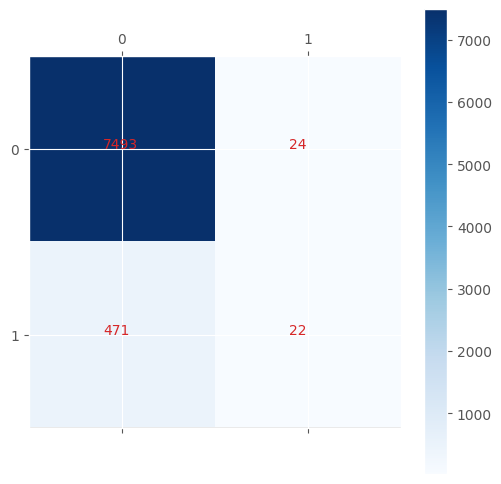

In [303]:
def plot_confusion_matrix(Y_test, Y_preds):
    conf_mat = confusion_matrix(Y_test, Y_preds)
    fig = plt.figure(figsize=(6,6))
    plt.matshow(conf_mat, cmap=plt.cm.Blues, fignum=1)
    plt.yticks(range(2), range(2))
    plt.xticks(range(2), range(2))
    plt.colorbar();
    for i in range(2):
        for j in range(2):
            plt.text(i-0.1,j, str(conf_mat[j, i]), color='tab:red')
    #plt.savefig('Cluster1ConfusionMatrix.png')
plot_confusion_matrix(y_test, prediction_cart02)

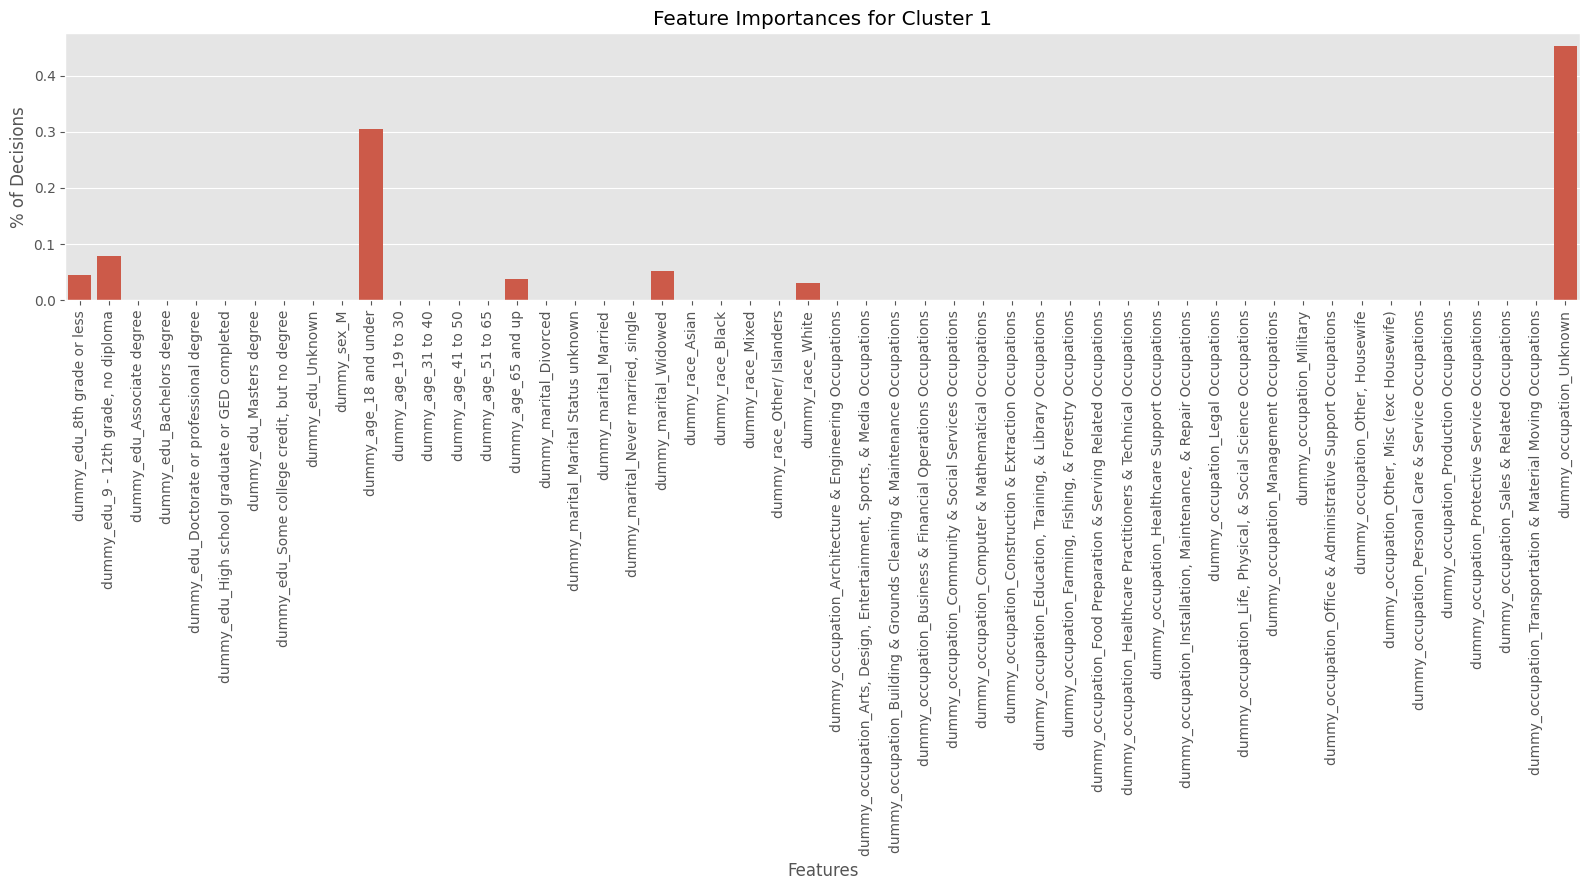

In [304]:
clus1_features = cart02.feature_importances_
def feature_importance(x, y, cluster):
    plt.figure(figsize = (16 , 9))
    sns.barplot(x = x.columns, y = y)
    plt.xlabel("Features")
    plt.xticks(rotation=90)
    plt.ylabel("% of Decisions")
    plt.title(f"Feature Importances for Cluster {cluster}")
    plt.tight_layout()
    #plt.savefig('Cluster1FeatureImportance.png')
    plt.show()
feature_importance(x_train, clus1_features, 1)

# Cluster 1: XGBoost/ Oversample 20%/ Tuned

In [47]:
cluster_1 = cluster_1.drop('Clusters', axis=1)
cluster_1.head()

Education Sex AgeCategory  \
0     Some college credit, but no degree   M    31 to 40   
1  High school graduate or GED completed   M    31 to 40   
2                                Unknown   M    31 to 40   
3             9 - 12th grade, no diploma   F    31 to 40   
4  High school graduate or GED completed   F    19 to 30   

          Marital Status              Race  \
0  Never married, single             White   
1  Never married, single  Other/ Islanders   
2  Never married, single  Other/ Islanders   
3               Divorced  Other/ Islanders   
4  Never married, single             White   

                                       Occupation                      Death  
0                          Management Occupations  Accidental Drug Poisoning  
1  Food Preparation & Serving Related Occupations  Accidental Drug Poisoning  
2           Construction & Extraction Occupations  Accidental Drug Poisoning  
3                                Other, Housewife  Accidental Drug Poisoning  
4  Food Preparation & Serving Related Occupations  Accidental Drug Poisoning

In [48]:
cluster_1 = pd.get_dummies(cluster_1, 
                           columns=['Education', 'Sex', 'AgeCategory', 'Marital Status', 'Race', 'Occupation', 'Death'], 
                           prefix=['dummy_edu','dummy_sex','dummy_age', 'dummy_marital', 'dummy_race', 'dummy_occupation', 'dummy_death'])
cluster_1.head()

dummy_edu_8th grade or less  dummy_edu_9 - 12th grade, no diploma  \
0                            0                                     0   
1                            0                                     0   
2                            0                                     0   
3                            0                                     1   
4                            0                                     0   

   dummy_edu_Associate degree  dummy_edu_Bachelors degree  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           0                           0   

   dummy_edu_Doctorate or professional degree  \
0                                           0   
1                                           0   
2                                           0   
3                                           0   
4                                           0   

   dummy_edu_High school graduate or GED completed  dummy_edu_Masters degree  \
0                                                0                         0   
1                                                1                         0   
2                                                0                         0   
3                                                0                         0   
4                                                1                         0   

   dummy_edu_Some college credit, but no degree  dummy_edu_Unknown  \
0                                             1                  0   
1                                             0                  0   
2                                             0                  1   
3                                             0                  0   
4                                             0                  0   

   dummy_sex_F  ...  dummy_occupation_Other, Housewife  \
0            0  ...                                  0   
1            0  ...                                  0   
2            0  ...                                  0   
3            1  ...                                  1   
4            1  ...                                  0   

   dummy_occupation_Other, Misc (exc Housewife)  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             0   

   dummy_occupation_Personal Care & Service Occupations  \
0                                                  0      
1                                                  0      
2                                                  0      
3                                                  0      
4                                                  0      

   dummy_occupation_Production Occupations  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

   dummy_occupation_Protective Service Occupations  \
0                                                0   
1                                                0   
2                                                0   
3                                                0   
4                                                0   

   dummy_occupation_Sales & Related Occupations  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             0   

   dummy_occupation_Transportation & Material Moving Occupations  \
0                 

In [49]:
# Sex attribute has two values only so we can drop one of them since they are considered redundant. We are predicting Accidental or not, so only 1 column is sufficient. 
cluster_1.drop('dummy_death_Other', axis=1, inplace=True)
cluster_1.rename(columns={'dummy_death_Accidental Drug Poisoning': 'Death'}, inplace=True)
cluster_1.drop('dummy_sex_F', axis=1, inplace=True)
#1 = Accidental, 0 = Other

In [50]:
clus1_train, clus1_test = train_test_split(cluster_1, test_size=0.25, random_state=34)
print(clus1_train.shape)
print(clus1_test.shape)

(24030, 53)
(8010, 53)


In [51]:
print(clus1_train["Death"].count())
print(clus1_train["Death"].value_counts(normalize = True))
clus1_train["Death"].value_counts()

24030
1    0.937703
0    0.062297
Name: Death, dtype: float64


1    22533
0     1497
Name: Death, dtype: int64

In [52]:
def determine_samples(records, unique_records, proportion):
    samples = int((proportion * records - unique_records) / (1 - proportion))
    return samples

In [53]:
num_samples_other_deaths_1 = determine_samples(len(clus1_train), 1497, 0.2)
print("Other Deaths oversample samples to add in Cluster 1: ", num_samples_other_deaths_1)

Other Deaths oversample samples to add in Cluster 1:  4136


In [54]:
to_resample_1 = clus1_train.loc[clus1_train['Death'] == 0]

In [55]:
our_resample_1 = to_resample_1.sample(n = 4136 , replace = True)
clus1_train_rebal = pd.concat([clus1_train, our_resample_1])

In [56]:
clus1_train_rebal['Death'].value_counts()

1    22533
0     5633
Name: Death, dtype: int64

In [57]:
x_train1 = clus1_train_rebal.drop('Death', axis=1)
y_train1 = clus1_train_rebal['Death']

In [58]:
x_test1 = clus1_test.drop('Death', axis=1)
y_test1 = clus1_test['Death']

In [59]:
kfold = KFold(n_splits= 10, shuffle=True, random_state=34)

In [60]:
y_train1.value_counts()

#Since 'Accidental Drug Poisoning' is the most occurring value for this target attribute we will use that as the prediction value for any records. 
#If we use this on our training set we would correctly classify 22533 records and miss-classify 5633 records. 
#This gives us an accuracy around 80%.

1    22533
0     5633
Name: Death, dtype: int64

In [61]:
print(f'Our baseline model for Cluster 1 is {y_train1.value_counts(normalize = True)[1] * 100}% accurate')
print(f'Our baseline model for Cluster 1 based on the testing set is {y_test1.value_counts(normalize = True)[1] * 100}% accurate')

Our baseline model for Cluster 1 is 80.00071007597813% accurate
Our baseline model for Cluster 1 based on the testing set is 94.09488139825218% accurate


In [62]:
#Using CrossValidation for model selection: 
clus1_models_dict = {'RandomForest': RandomForestClassifier(n_estimators = 10, criterion='gini', random_state = 34), 
                     'NaiveBayes': MultinomialNB(alpha=1.0, fit_prior=True), 
                     'XGBoost': XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic'),
                     'Decision Tree': DecisionTreeClassifier(criterion="entropy",max_leaf_nodes=5, random_state = 34)}

clus1_model_cv_score = {}

for name, model in clus1_models_dict.items():
    score1 = cross_val_score(model, x_train1, y_train1, cv=kfold)
    clus1_model_cv_score[name] = score1.mean()

print(f'Model Scores: {clus1_model_cv_score}')

Model Scores: {'RandomForest': 0.8248245610054216, 'NaiveBayes': 0.7995456385944106, 'XGBoost': 0.8090606796801886, 'Decision Tree': 0.8093447327710008}


In [71]:
#We are going to use XGBoost or DecisionTree as they have the highest accuracies (using stratified k fold cv)
clus1_params = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [3, 5, 7],
    'scale_pos_weight': [3, 4, 5] #22533 / 5633 = 4(oversampled)
}

grid1 = GridSearchCV(XGBClassifier(), param_grid = clus1_params, cv = kfold, n_jobs = -1, verbose = 1)
grid1.fit(x_train1, y_train1)

print("Best Parameters found for Cluster 1: ", grid1.best_params_)
print("Best Accuracy through grid search for Cluster 1: %.3f"%grid1.best_score_)

Fitting 10 folds for each of 11664 candidates, totalling 116640 fits
Best Parameters found for Cluster 1:  {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 400, 'scale_pos_weight': 3, 'subsample': 0.9}
Best Accuracy through grid search for Cluster 1: 0.819


In [57]:
#We are going to use XGBoost or DecisionTree as they have the highest accuracies (using stratified k fold cv)
clus1_params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'min_child_weight': [1, 3, 5, 7]
}

grid1 = GridSearchCV(XGBClassifier(), param_grid = clus1_params, cv = kfold, n_jobs = -1, verbose = 1)
grid1.fit(x_train1, y_train1)

print("Best Parameters found for Cluster 1: ", grid1.best_params_)
print("Best Accuracy through grid search for Cluster 1: %.3f"%grid1.best_score_)

Fitting 10 folds for each of 3840 candidates, totalling 38400 fits
Best Parameters found for Cluster 1:  {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.8}
Best Accuracy through grid search for Cluster 1: 0.825


In [63]:
#BEST SCORE: 0.28/ 0.82/ 78.67% = FOUND IN GRIDSEARCH
xgb1 = XGBClassifier(colsample_bytree = 0.8, learning_rate = 0.1, max_depth = 9, min_child_weight = 1, 
                     n_estimators = 500, subsample = 0.8, random_state=34).fit(x_train1, y_train1)

xgb1_score = cross_val_score(xgb1, x_train1, y_train1, cv=kfold)

In [64]:
print(f"Our XGBoost with the best optimized parameters on the Testing set for Cluster 1 is: {xgb1.score(x_test1, y_test1) * 100}% accurate")
print(f"Our XGBoost Classification model with optimized parameters with k-fold cross validation on the training dataset for Cluster 1 is: {xgb1_score.mean() * 100}% accurate")

Our XGBoost with the best optimized parameters on the Testing set for Cluster 1 is: 92.35955056179776% accurate
Our XGBoost Classification model with optimized parameters with k-fold cross validation on the training dataset for Cluster 1 is: 82.20195036426566% accurate


In [65]:
prediction_xgb1 = xgb1.predict(x_test1)

print("Classification Report for Cluster 1:")
print(classification_report(y_test1, prediction_xgb1))
print("===========")
print("Confusion Matrix")
print(confusion_matrix(y_test1, prediction_xgb1))
print("============")
print("Accuracy Score: ", accuracy_score(prediction_xgb1, y_test1))
print("==============")

test1_predictions_proba = xgb1.predict_proba(x_test1)
log_1 = log_loss(y_test1, test1_predictions_proba)
print("Log Loss: {:.4}".format(log_1))
print("===============")

Classification Report for Cluster 1:
              precision    recall  f1-score   support

           0       0.17      0.07      0.10       473
           1       0.94      0.98      0.96      7537

    accuracy                           0.92      8010
   macro avg       0.56      0.53      0.53      8010
weighted avg       0.90      0.92      0.91      8010

Confusion Matrix
[[  35  438]
 [ 174 7363]]
Accuracy Score:  0.9235955056179775
Log Loss: 0.3124


In [66]:
def plot_confusion_matrix(Y_test, Y_preds):
    conf_mat = confusion_matrix(Y_test, Y_preds)
    fig = plt.figure(figsize=(6,6))
    plt.matshow(conf_mat, cmap=plt.cm.Blues, fignum=1)
    plt.yticks(range(2), range(2))
    plt.xticks(range(2), range(2))
    plt.colorbar();
    for i in range(2):
        for j in range(2):
            plt.text(i-0.1,j, str(conf_mat[j, i]), color='tab:red')
    #plt.savefig('Cluster1ConfusionMatrix.png')

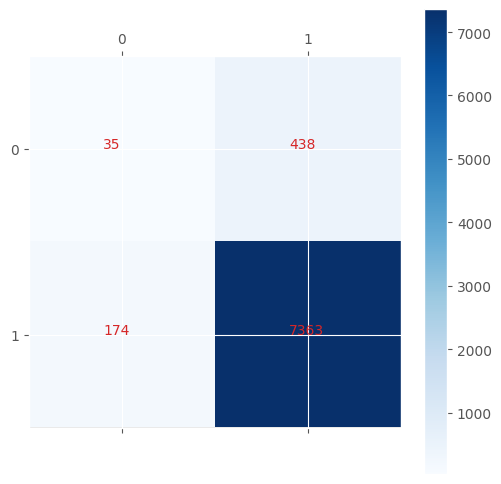

In [67]:
#Visualization for our XGBoost model confusion matrix 
plot_confusion_matrix(y_test1, prediction_xgb1)

In [68]:
def feature_importance(x, y, cluster):
    plt.figure(figsize = (16 , 9))
    sns.barplot(x = x.columns, y = y)
    plt.xlabel("Features")
    plt.xticks(rotation=90)
    plt.ylabel("% of Decisions")
    plt.title(f"Feature Importances for Cluster {cluster}")
    plt.tight_layout()
    #plt.savefig('Cluster1FeatureImportance.png')
    plt.show()

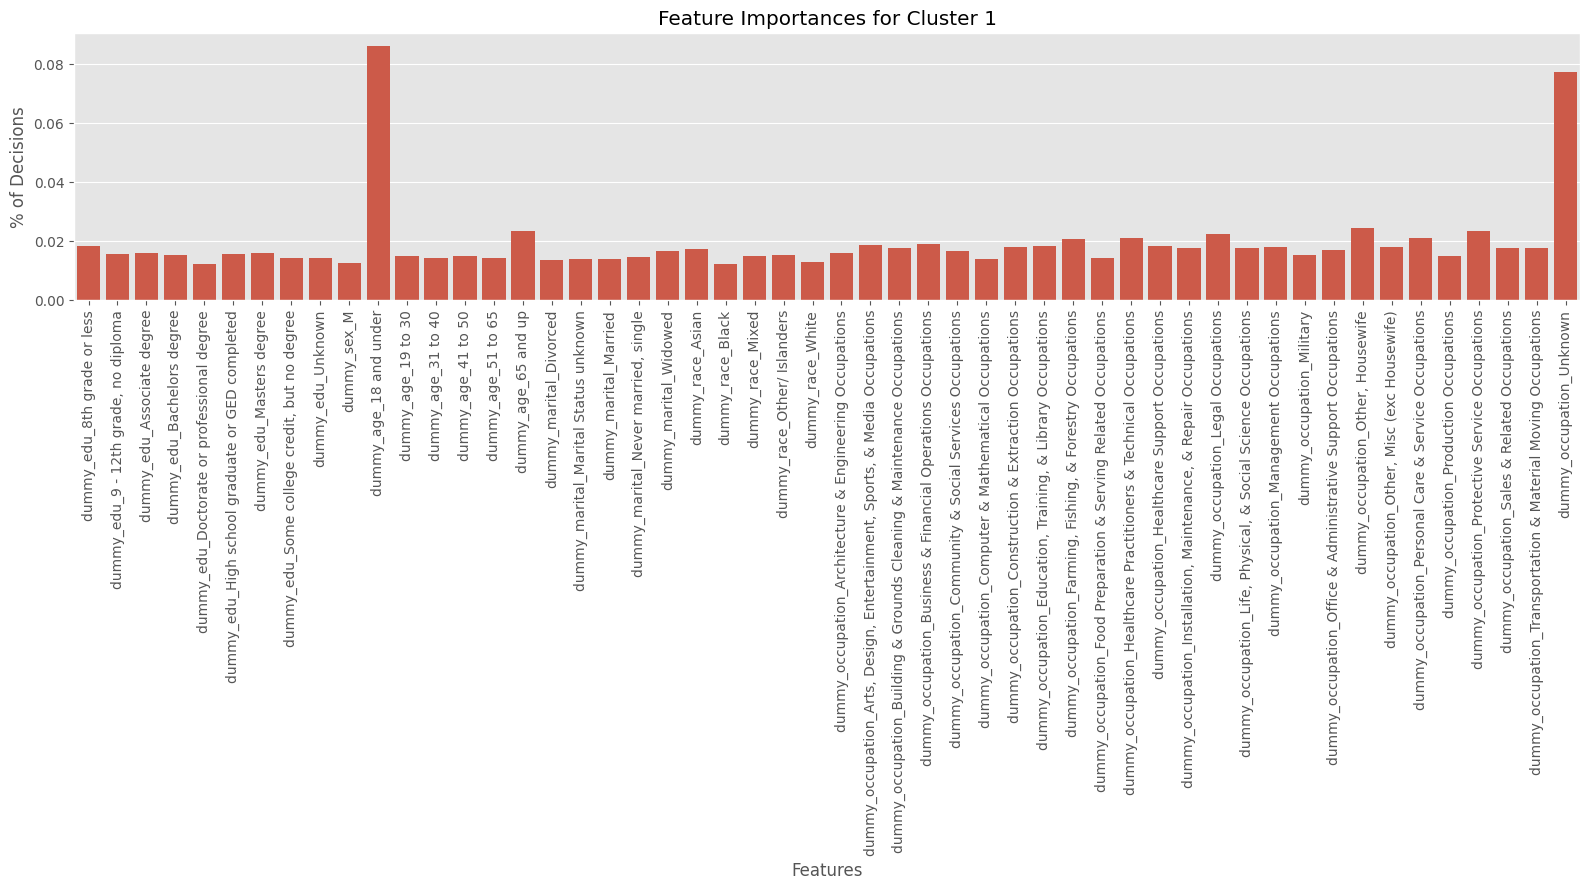

In [69]:
clus1_features = xgb1.feature_importances_

feature_importance(x_train1, clus1_features, 1)

In [70]:
#Tablular format of feature importances and the features being used to make decions for our XGBoost decision tree model
clus1_feature_importances_table = pd.DataFrame(data = {"Features": x_train1.columns, "Data": clus1_features})
clus1_feature_importances_table[clus1_feature_importances_table["Data"] > 0]

Features      Data
0                         dummy_edu_8th grade or less  0.018223
1                dummy_edu_9 - 12th grade, no diploma  0.015753
2                          dummy_edu_Associate degree  0.016120
3                          dummy_edu_Bachelors degree  0.015161
4          dummy_edu_Doctorate or professional degree  0.012250
5     dummy_edu_High school graduate or GED completed  0.015804
6                            dummy_edu_Masters degree  0.015847
7        dummy_edu_Some college credit, but no degree  0.014206
8                                   dummy_edu_Unknown  0.014154
9                                         dummy_sex_M  0.012702
10                             dummy_age_18 and under  0.086117
11                                 dummy_age_19 to 30  0.014961
12                                 dummy_age_31 to 40  0.014141
13                                 dummy_age_41 to 50  0.014981
14                                 dummy_age_51 to 65  0.014266
15                                dummy_age_65 and up  0.023329
16                             dummy_marital_Divorced  0.013552
17               dummy_marital_Marital Status unknown  0.013871
18                              dummy_marital_Married  0.014049
19                dummy_marital_Never married, single  0.014541
20                              dummy_marital_Widowed  0.016815
21                                   dummy_race_Asian  0.017505
22                                   dummy_race_Black  0.012135
23                                   dummy_race_Mixed  0.015144
24                        dummy_race_Other/ Islanders  0.015239
25                                   dummy_race_White  0.012980
26  dummy_occupation_Architecture & Engineering Oc...  0.016084
27  dummy_occupation_Arts, Design, Entertainment, ...  0.018790
28  dummy_occupation_Building & Grounds Cleaning &...  0.017643
29  dummy_occupation_Business & Financial Operatio...  0.019145
30  dummy_occupation_Community & Social Services O...  0.016551
31  dummy_occupation_Computer & Mathematical Occup...  0.013870
32  dummy_occupation_Construction & Extraction Occ...  0.017969
33  dummy_occupation_Education, Training, & Librar...  0.018446
34  dummy_occupation_Farming, Fishing, & Forestry ...  0.020831
35  dummy_occupation_Food Preparation & Serving Re...  0.014454
36  dummy_occupation_Healthcare Practitioners & Te...  0.021209
37    dummy_occupation_Healthcare Support Occupations  0.018499
38  dummy_occupation_Installation, Maintenance, & ...  0.017663
39                 dummy_occupation_Legal Occupations  0.022363
40  dummy_occupation_Life, Physical, & Social Scie...  0.017543
41            dummy_occupation_Management Occupations  0.018086
42                          dummy_occupation_Military  0.015294
43  dummy_occupation_Office & Administrative Suppo...  0.017005
44                  dummy_occupation_Other, Housewife  0.024465
45       dummy_occupation_Other, Misc (exc Housewife)  0.017892
46  dummy_occupation_Personal Care & Service Occup...  0.021094
47            dummy_occupation_Production Occupations  0.014922
48    dummy_occupation_Protective Service Occupations  0.023562
49       dummy_occupation_Sales & Related Occupations  0.017717
50  dummy_occupation_Transportation & Material Mov...  0.017809
51                           dummy_occupation_Unknown  0.077252

In [71]:
#https://stackoverflow.com/questions/47462690/how-to-get-top-5-values-from-pandas-dataframe
clus1_top_5 = clus1_feature_importances_table.sort_values(by='Data', ascending=False).head(5)
clus1_top_5

Features      Data
10                           dummy_age_18 and under  0.086117
51                         dummy_occupation_Unknown  0.077252
44                dummy_occupation_Other, Housewife  0.024465
48  dummy_occupation_Protective Service Occupations  0.023562
15                              dummy_age_65 and up  0.023329

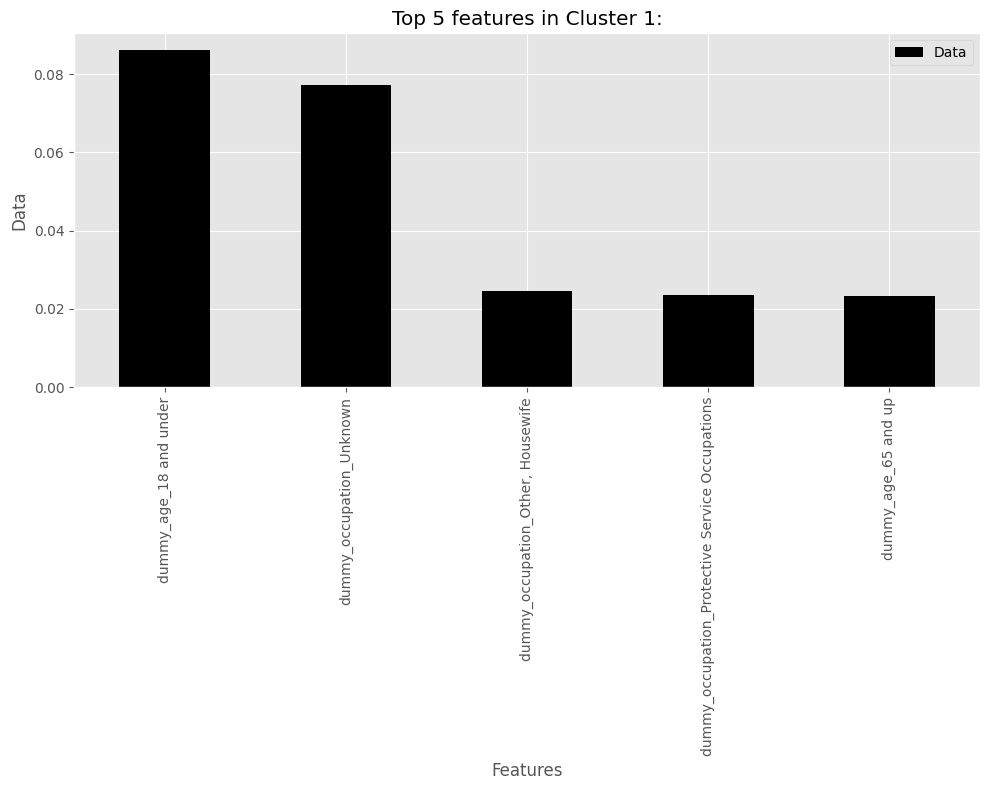

In [72]:
#Make a bar plot for the top 5 features in Cluster 1:
clus1_top_5.plot(kind='bar', x='Features', y='Data', color='black')
plt.title('Top 5 features in Cluster 1:')
plt.xlabel('Features')
plt.xticks(rotation=90)
plt.ylabel('Data')
plt.tight_layout()
plt.show()

# Cluster 2: XGBoost/ Oversample 20%/ Tuned

In [73]:
cluster_2 = cluster_2.drop('Clusters', axis=1)
cluster_2.head()

Education Sex   AgeCategory  \
0          9 - 12th grade, no diploma   M  18 and under   
1                             Unknown   F      51 to 65   
2                      Masters degree   M      41 to 50   
3  Some college credit, but no degree   F      31 to 40   
4          9 - 12th grade, no diploma   F      31 to 40   

          Marital Status              Race  \
0  Never married, single             White   
1                Married             White   
2               Divorced             White   
3                Married  Other/ Islanders   
4                Married             Mixed   

                                   Occupation                      Death  
0                 Other, Misc (exc Housewife)  Accidental Drug Poisoning  
1                 Other, Misc (exc Housewife)                      Other  
2  Education, Training, & Library Occupations  Accidental Drug Poisoning  
3                 Other, Misc (exc Housewife)  Accidental Drug Poisoning  
4                 Other, Misc (exc Housewife)  Accidental Drug Poisoning

In [74]:
cluster_2 = pd.get_dummies(cluster_2, columns=['Education', 'Sex', 'AgeCategory', 'Marital Status', 'Race', 'Occupation', 'Death'], prefix=['dummy_edu','dummy_sex','dummy_age', 'dummy_marital', 'dummy_race', 'dummy_occupation', 'dummy_death'])
cluster_2.head()

dummy_edu_8th grade or less  dummy_edu_9 - 12th grade, no diploma  \
0                            0                                     1   
1                            0                                     0   
2                            0                                     0   
3                            0                                     0   
4                            0                                     1   

   dummy_edu_Associate degree  dummy_edu_Bachelors degree  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           0                           0   

   dummy_edu_Doctorate or professional degree  \
0                                           0   
1                                           0   
2                                           0   
3                                           0   
4                                           0   

   dummy_edu_High school graduate or GED completed  dummy_edu_Masters degree  \
0                                                0                         0   
1                                                0                         0   
2                                                0                         1   
3                                                0                         0   
4                                                0                         0   

   dummy_edu_Some college credit, but no degree  dummy_edu_Unknown  \
0                                             0                  0   
1                                             0                  1   
2                                             0                  0   
3                                             1                  0   
4                                             0                  0   

   dummy_sex_F  ...  dummy_occupation_Other, Housewife  \
0            0  ...                                  0   
1            1  ...                                  0   
2            0  ...                                  0   
3            1  ...                                  0   
4            1  ...                                  0   

   dummy_occupation_Other, Misc (exc Housewife)  \
0                                             1   
1                                             1   
2                                             0   
3                                             1   
4                                             1   

   dummy_occupation_Personal Care & Service Occupations  \
0                                                  0      
1                                                  0      
2                                                  0      
3                                                  0      
4                                                  0      

   dummy_occupation_Production Occupations  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

   dummy_occupation_Protective Service Occupations  \
0                                                0   
1                                                0   
2                                                0   
3                                                0   
4                                                0   

   dummy_occupation_Sales & Related Occupations  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             0   

   dummy_occupation_Transportation & Material Moving Occupations  \
0                 

In [75]:
# Death and Sex attribute has two values only so we can drop one of them since they are considered redundant. 
#We are predicting Accidental or not, so only 1 column is sufficient. 

cluster_2.drop('dummy_death_Other', axis=1, inplace=True)
cluster_2.rename(columns={'dummy_death_Accidental Drug Poisoning': 'Death'}, inplace=True)
cluster_2.drop('dummy_sex_F', axis=1, inplace=True)

#1 = Accidental, 0 = Other

In [76]:
clus2_train, clus2_test = train_test_split(cluster_2, test_size=0.25, random_state=34)
print(clus2_train.shape)
print(clus2_test.shape)

(9191, 53)
(3064, 53)


In [77]:
print(clus2_train["Death"].count())
print(clus2_train["Death"].value_counts(normalize = True))
clus2_train["Death"].value_counts()

9191
1    0.93548
0    0.06452
Name: Death, dtype: float64


1    8598
0     593
Name: Death, dtype: int64

In [78]:
num_samples_other_deaths_2 = determine_samples(len(clus2_train), 593, 0.2)
print("Other Deaths oversample samples to add in Cluster 2: ", num_samples_other_deaths_2)

Other Deaths oversample samples to add in Cluster 2:  1556


In [79]:
to_resample_2 = clus2_train.loc[clus2_train['Death'] == 0]

In [80]:
our_resample_2 = to_resample_2.sample(n = 1556 , replace = True)
clus2_train_rebal = pd.concat([clus2_train, our_resample_2])

In [81]:
clus2_train_rebal['Death'].value_counts()

1    8598
0    2149
Name: Death, dtype: int64

In [82]:
x_train2 = clus2_train_rebal.drop('Death', axis=1)
y_train2 = clus2_train_rebal['Death']

In [83]:
x_test2 = clus2_test.drop('Death', axis=1)
y_test2 = clus2_test['Death']

In [84]:
print(f'Our baseline model for Cluster 2 is {y_train2.value_counts(normalize = True)[1] * 100}% accurate')
print(f'Our baseline model for Cluster 2 based on the testing partition is {y_test2.value_counts(normalize = True)[1] * 100}% accurate')

Our baseline model for Cluster 2 is 80.00372196892155% accurate
Our baseline model for Cluster 2 based on the testing partition is 93.83159268929504% accurate


In [85]:
#Using CrossValidation for model selection: 
clus2_models_dict = {'RandomForest': RandomForestClassifier(n_estimators = 10, criterion='gini', random_state = 34), 
                     'NaiveBayes': MultinomialNB(alpha=1.0, fit_prior=True), 
                     'XGBoost': XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic'),
                     'Decision Tree': DecisionTreeClassifier(criterion="entropy",max_leaf_nodes=5, random_state = 34)}

clus2_model_cv_score = {}

for name, model in clus2_models_dict.items():
    score2 = cross_val_score(model, x_train2, y_train2, cv=kfold)
    clus2_model_cv_score[name] = score2.mean()

print(f'Model Scores: {clus2_model_cv_score}')

Model Scores: {'RandomForest': 0.8263709670434368, 'NaiveBayes': 0.8007818630635312, 'XGBoost': 0.8001307868866657, 'Decision Tree': 0.8018979689056343}


In [72]:
#We are going to use XGBoost or DecisionTree as they have the highest accuracies (using stratified k fold cv)
clus2_params = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 3, 5, 7],
    'scale_pos_weight': [3, 4, 5] #8598 / 2149 = 4(oversampled)
}

grid2 = GridSearchCV(XGBClassifier(), param_grid = clus2_params, cv = kfold, n_jobs = -1, verbose = 1)
grid2.fit(x_train2, y_train2)

print("Best Parameters found for Cluster 2: ", grid2.best_params_)
print("Best Accuracy through grid search for Cluster 2: %.3f"%grid2.best_score_)

Fitting 10 folds for each of 15552 candidates, totalling 155520 fits
Best Parameters found for Cluster 2:  {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 400, 'scale_pos_weight': 3, 'subsample': 0.9}
Best Accuracy through grid search for Cluster 2: 0.823


In [71]:
#We are going to use XGBoost or DecisionTree as they have the highest accuracies (using stratified k fold cv)
clus2_params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'min_child_weight': [1, 3, 5, 7]
}

grid2 = GridSearchCV(XGBClassifier(), param_grid = clus2_params, cv = kfold, n_jobs = -1, verbose = 1)
grid2.fit(x_train2, y_train2)

print("Best Parameters found for Cluster 2: ", grid2.best_params_)
print("Best Accuracy through grid search for Cluster 2: %.3f"%grid2.best_score_)

Fitting 10 folds for each of 3840 candidates, totalling 38400 fits
Best Parameters found for Cluster 2:  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.9}
Best Accuracy through grid search for Cluster 2: 0.826


In [86]:
#BEST SCORE:
xgb2 = XGBClassifier(colsample_bytree = 0.7, learning_rate = 0.1, max_depth = 9, min_child_weight = 1, 
                     n_estimators = 500, subsample = 0.9, random_state=34).fit(x_train2, y_train2)

xgb2_score = cross_val_score(xgb2, x_train2, y_train2, cv=kfold)

In [87]:
print(f"Our XGBoost with the best optimized parameters on the Testing set for Cluster 2 is: {xgb2.score(x_test2, y_test2) * 100}% accurate")
print(f"Our XGBoost Classification model with optimized parameters with k-fold cross validation on the training dataset for Cluster 2 is: {xgb2_score.mean() * 100}% accurate")

Our XGBoost with the best optimized parameters on the Testing set for Cluster 2 is: 90.79634464751958% accurate
Our XGBoost Classification model with optimized parameters with k-fold cross validation on the training dataset for Cluster 2 is: 82.26494305140531% accurate


In [88]:
prediction_xgb2 = xgb2.predict(x_test2)

print("Classification Report for Cluster 2:")
print(classification_report(y_test2, prediction_xgb2))
print("===========")
print("Confusion Matrix")
print(confusion_matrix(y_test2, prediction_xgb2))
print("============")
print("Accuracy Score: ", accuracy_score(prediction_xgb2, y_test2))
print("==============")

test2_predictions_proba = xgb2.predict_proba(x_test2)
log_2 = log_loss(y_test2, test2_predictions_proba)
print("Log Loss: {:.4}".format(log_2))
print("===============")

Classification Report for Cluster 2:
              precision    recall  f1-score   support

           0       0.09      0.05      0.07       189
           1       0.94      0.96      0.95      2875

    accuracy                           0.91      3064
   macro avg       0.51      0.51      0.51      3064
weighted avg       0.89      0.91      0.90      3064

Confusion Matrix
[[  10  179]
 [ 103 2772]]
Accuracy Score:  0.9079634464751958
Log Loss: 0.3307


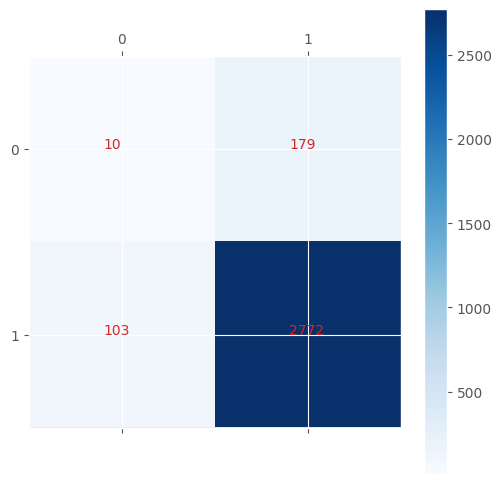

In [89]:
#Visualization for our XGBoost model confusion matrix 
plot_confusion_matrix(y_test2, prediction_xgb2)

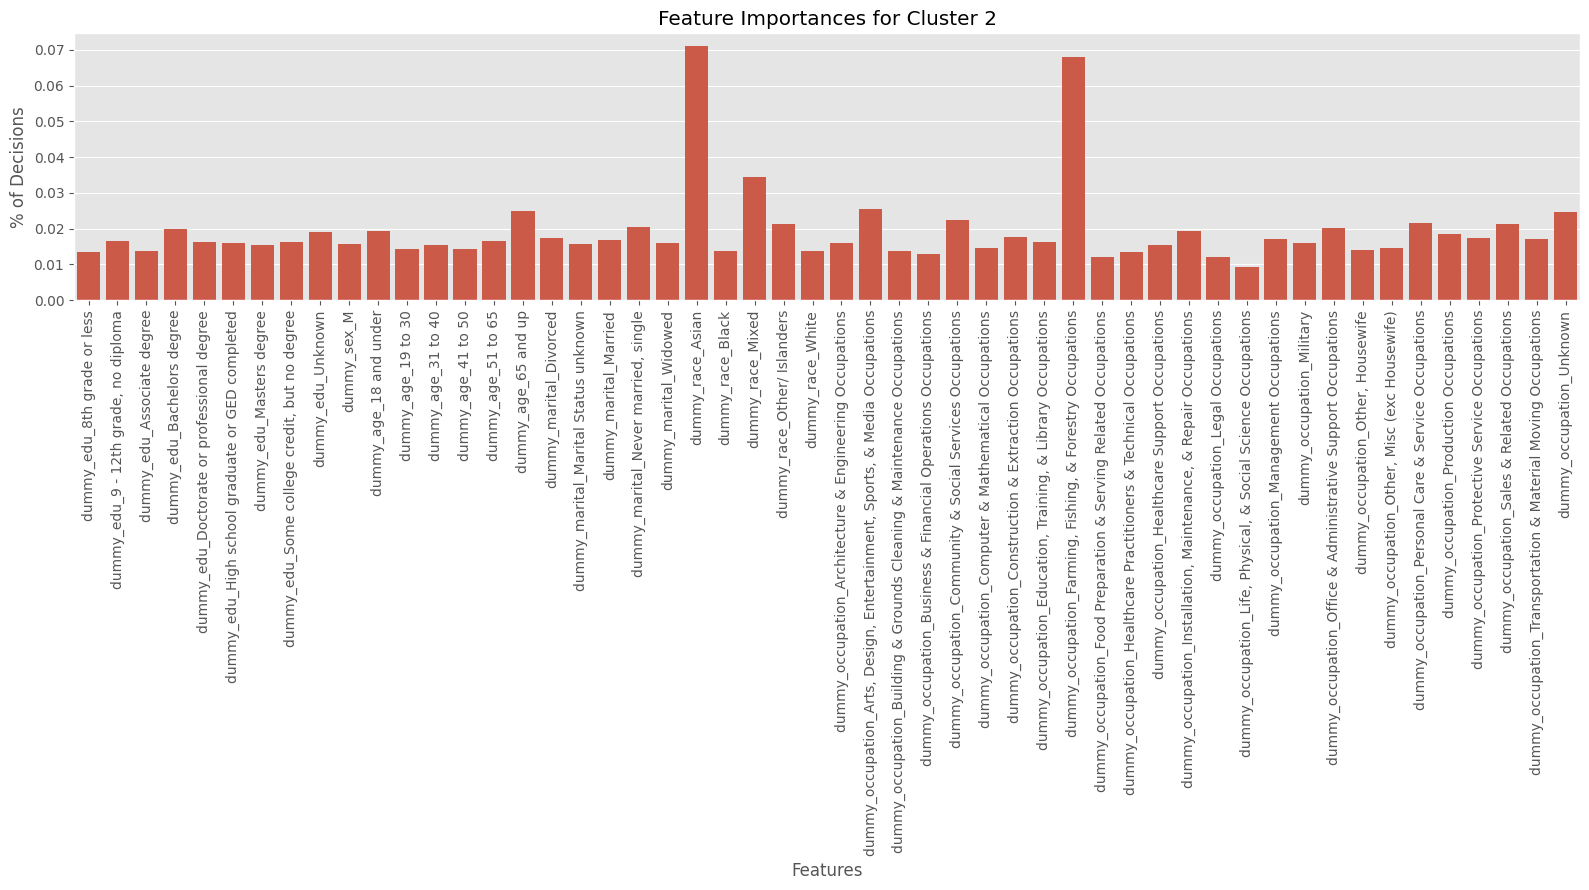

In [90]:
clus2_features = xgb2.feature_importances_
feature_importance(x_train2, clus2_features, 2)

In [91]:
#Tablular format of feature importances and the features being used to make decions for our XGBoost decision tree model
clus2_feature_importances_table = pd.DataFrame(data = {"Features": x_train2.columns, "Data": clus2_features})
clus2_feature_importances_table[clus2_feature_importances_table["Data"] > 0]

Features      Data
0                         dummy_edu_8th grade or less  0.013576
1                dummy_edu_9 - 12th grade, no diploma  0.016555
2                          dummy_edu_Associate degree  0.013813
3                          dummy_edu_Bachelors degree  0.019919
4          dummy_edu_Doctorate or professional degree  0.016223
5     dummy_edu_High school graduate or GED completed  0.015959
6                            dummy_edu_Masters degree  0.015512
7        dummy_edu_Some college credit, but no degree  0.016341
8                                   dummy_edu_Unknown  0.019016
9                                         dummy_sex_M  0.015592
10                             dummy_age_18 and under  0.019403
11                                 dummy_age_19 to 30  0.014193
12                                 dummy_age_31 to 40  0.015473
13                                 dummy_age_41 to 50  0.014335
14                                 dummy_age_51 to 65  0.016477
15                                dummy_age_65 and up  0.024958
16                             dummy_marital_Divorced  0.017315
17               dummy_marital_Marital Status unknown  0.015666
18                              dummy_marital_Married  0.016881
19                dummy_marital_Never married, single  0.020438
20                              dummy_marital_Widowed  0.016135
21                                   dummy_race_Asian  0.071082
22                                   dummy_race_Black  0.013826
23                                   dummy_race_Mixed  0.034480
24                        dummy_race_Other/ Islanders  0.021417
25                                   dummy_race_White  0.013675
26  dummy_occupation_Architecture & Engineering Oc...  0.016077
27  dummy_occupation_Arts, Design, Entertainment, ...  0.025494
28  dummy_occupation_Building & Grounds Cleaning &...  0.013733
29  dummy_occupation_Business & Financial Operatio...  0.012980
30  dummy_occupation_Community & Social Services O...  0.022489
31  dummy_occupation_Computer & Mathematical Occup...  0.014517
32  dummy_occupation_Construction & Extraction Occ...  0.017541
33  dummy_occupation_Education, Training, & Librar...  0.016237
34  dummy_occupation_Farming, Fishing, & Forestry ...  0.068106
35  dummy_occupation_Food Preparation & Serving Re...  0.012064
36  dummy_occupation_Healthcare Practitioners & Te...  0.013616
37    dummy_occupation_Healthcare Support Occupations  0.015436
38  dummy_occupation_Installation, Maintenance, & ...  0.019226
39                 dummy_occupation_Legal Occupations  0.011965
40  dummy_occupation_Life, Physical, & Social Scie...  0.009268
41            dummy_occupation_Management Occupations  0.016995
42                          dummy_occupation_Military  0.016092
43  dummy_occupation_Office & Administrative Suppo...  0.020193
44                  dummy_occupation_Other, Housewife  0.014083
45       dummy_occupation_Other, Misc (exc Housewife)  0.014718
46  dummy_occupation_Personal Care & Service Occup...  0.021720
47            dummy_occupation_Production Occupations  0.018617
48    dummy_occupation_Protective Service Occupations  0.017508
49       dummy_occupation_Sales & Related Occupations  0.021403
50  dummy_occupation_Transportation & Material Mov...  0.017098
51                           dummy_occupation_Unknown  0.024564

In [92]:
clus2_top_5 = clus2_feature_importances_table.sort_values(by='Data', ascending=False).head(5)
clus2_top_5

Features      Data
21                                   dummy_race_Asian  0.071082
34  dummy_occupation_Farming, Fishing, & Forestry ...  0.068106
23                                   dummy_race_Mixed  0.034480
27  dummy_occupation_Arts, Design, Entertainment, ...  0.025494
15                                dummy_age_65 and up  0.024958

# Cluster 3: XGBoost/ Oversample 20%/ Tuned

In [93]:
cluster_3 = cluster_3.drop('Clusters', axis=1)
cluster_3.head()

Education Sex AgeCategory Marital Status  \
0     Some college credit, but no degree   M    51 to 65       Divorced   
1                      8th grade or less   M   65 and up       Divorced   
2  High school graduate or GED completed   M    51 to 65       Divorced   
3  High school graduate or GED completed   F    51 to 65       Divorced   
4  High school graduate or GED completed   M   65 and up        Married   

               Race                                      Occupation  \
0  Other/ Islanders                          Management Occupations   
1             White                          Management Occupations   
2             White     Office & Administrative Support Occupations   
3             White  Food Preparation & Serving Related Occupations   
4  Other/ Islanders           Construction & Extraction Occupations   

                       Death  
0  Accidental Drug Poisoning  
1  Accidental Drug Poisoning  
2  Accidental Drug Poisoning  
3  Accidental Drug Poisoning  
4  Accidental Drug Poisoning

In [94]:
cluster_3 = pd.get_dummies(cluster_3, columns=['Education', 'Sex', 'AgeCategory', 'Marital Status', 'Race', 'Occupation', 'Death'], prefix=['dummy_edu','dummy_sex','dummy_age', 'dummy_marital', 'dummy_race', 'dummy_occupation', 'dummy_death'])
cluster_3.head()

dummy_edu_8th grade or less  dummy_edu_9 - 12th grade, no diploma  \
0                            0                                     0   
1                            1                                     0   
2                            0                                     0   
3                            0                                     0   
4                            0                                     0   

   dummy_edu_Associate degree  dummy_edu_Bachelors degree  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           0                           0   

   dummy_edu_Doctorate or professional degree  \
0                                           0   
1                                           0   
2                                           0   
3                                           0   
4                                           0   

   dummy_edu_High school graduate or GED completed  dummy_edu_Masters degree  \
0                                                0                         0   
1                                                0                         0   
2                                                1                         0   
3                                                1                         0   
4                                                1                         0   

   dummy_edu_Some college credit, but no degree  dummy_edu_Unknown  \
0                                             1                  0   
1                                             0                  0   
2                                             0                  0   
3                                             0                  0   
4                                             0                  0   

   dummy_sex_F  ...  dummy_occupation_Other, Housewife  \
0            0  ...                                  0   
1            0  ...                                  0   
2            0  ...                                  0   
3            1  ...                                  0   
4            0  ...                                  0   

   dummy_occupation_Other, Misc (exc Housewife)  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             0   

   dummy_occupation_Personal Care & Service Occupations  \
0                                                  0      
1                                                  0      
2                                                  0      
3                                                  0      
4                                                  0      

   dummy_occupation_Production Occupations  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

   dummy_occupation_Protective Service Occupations  \
0                                                0   
1                                                0   
2                                                0   
3                                                0   
4                                                0   

   dummy_occupation_Sales & Related Occupations  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             0   

   dummy_occupation_Transportation & Material Moving Occupations  \
0                 

In [95]:
# Death and Sex attribute has two values only so we can drop one of them since they are considered redundant. 
#We are predicting Accidental or not, so only 1 column is sufficient. 

cluster_3.drop('dummy_death_Other', axis=1, inplace=True)
cluster_3.rename(columns={'dummy_death_Accidental Drug Poisoning': 'Death'}, inplace=True)
cluster_3.drop('dummy_sex_F', axis=1, inplace=True)

#1 = Accidental, 0 = Other

In [96]:
clus3_train, clus3_test = train_test_split(cluster_3, test_size=0.25, random_state=34)
print(clus3_train.shape)
print(clus3_test.shape)

(9674, 53)
(3225, 53)


In [97]:
print(clus3_train["Death"].count())
print(clus3_train["Death"].value_counts(normalize = True))
clus3_train["Death"].value_counts()

9674
1    0.934257
0    0.065743
Name: Death, dtype: float64


1    9038
0     636
Name: Death, dtype: int64

In [98]:
num_samples_other_deaths_3 = determine_samples(len(clus3_train), 636, 0.2)
print("Other Deaths oversample samples to add in Cluster 3: ", num_samples_other_deaths_3)

Other Deaths oversample samples to add in Cluster 3:  1623


In [99]:
to_resample_3 = clus3_train.loc[clus3_train['Death'] == 0]

In [100]:
our_resample_3 = to_resample_3.sample(n = 1623 , replace = True)
clus3_train_rebal = pd.concat([clus3_train, our_resample_3])

In [101]:
clus3_train_rebal['Death'].value_counts()

1    9038
0    2259
Name: Death, dtype: int64

In [102]:
x_train3 = clus3_train_rebal.drop('Death', axis=1)
y_train3 = clus3_train_rebal['Death']

In [103]:
x_test3 = clus3_test.drop('Death', axis=1)
y_test3 = clus3_test['Death']

In [104]:
print(f'Our baseline model for Cluster 3 is {y_train3.value_counts(normalize = True)[1] * 100}% accurate')
print(f'Our baseline model for Cluster 3 based on the testing partition is {y_test3.value_counts(normalize = True)[1] * 100}% accurate')

Our baseline model for Cluster 3 is 80.00354076303444% accurate
Our baseline model for Cluster 3 based on the testing partition is 93.82945736434108% accurate


In [105]:
#Using CrossValidation for model selection: 
clus3_models_dict = {'RandomForest': RandomForestClassifier(n_estimators = 10, criterion='gini', random_state = 34), 
                     'NaiveBayes': MultinomialNB(alpha=1.0, fit_prior=True), 
                     'XGBoost': XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic'),
                     'Decision Tree': DecisionTreeClassifier(criterion="entropy",max_leaf_nodes=5, random_state = 34)}

clus3_model_cv_score = {}

for name, model in clus3_models_dict.items():
    score3 = cross_val_score(model, x_train3, y_train3, cv=kfold)
    clus3_model_cv_score[name] = score3.mean()

print(f'Model Scores: {clus3_model_cv_score}')

Model Scores: {'RandomForest': 0.8155256825289825, 'NaiveBayes': 0.7993260540693072, 'XGBoost': 0.7981749845191531, 'Decision Tree': 0.8005652272745086}


In [86]:
#We are going to use XGBoost or DecisionTree as they have the highest accuracies (using stratified k fold cv)
clus3_params = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [3, 5, 7],
    'scale_pos_weight': [3, 4, 5]
}

grid3 = GridSearchCV(XGBClassifier(), param_grid = clus3_params, cv = kfold, n_jobs = -1, verbose = 1)
grid3.fit(x_train3, y_train3)

print("Best Parameters found for Cluster 3:", grid3.best_params_)
print("Best Accuracy through grid search for Cluster 3:%.3f"%grid3.best_score_)

Fitting 10 folds for each of 11664 candidates, totalling 116640 fits
Best Parameters found for Cluster 3: {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 3, 'n_estimators': 400, 'scale_pos_weight': 3, 'subsample': 0.8}
Best Accuracy through grid search for Cluster 3:0.806


In [85]:
clus3_params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'min_child_weight': [1, 3, 5, 7]
}

grid3 = GridSearchCV(XGBClassifier(), param_grid = clus3_params, cv = kfold, n_jobs = -1, verbose = 1)
grid3.fit(x_train3, y_train3)

print("Best Parameters found for Cluster 3:", grid3.best_params_)
print("Best Accuracy through grid search for Cluster 3:%.3f"%grid3.best_score_)

Fitting 10 folds for each of 3840 candidates, totalling 38400 fits
Best Parameters found for Cluster 3: {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 1, 'n_estimators': 500, 'subsample': 0.8}
Best Accuracy through grid search for Cluster 3:0.817


In [106]:
#BEST SCORE:
xgb3 = XGBClassifier(colsample_bytree = 0.9, learning_rate = 0.1, max_depth = 9, min_child_weight = 1, 
                     n_estimators = 500, subsample = 0.8, random_state=34).fit(x_train3, y_train3) 

xgb3_score = cross_val_score(xgb3, x_train3, y_train3, cv=kfold)

In [107]:
print(f"Our XGBoost with the best optimized parameters on the Testing set for Cluster 3 is: {xgb3.score(x_test3, y_test3) * 100}% accurate")
print(f"Our XGBoost Classification model with optimized parameters with k-fold cross validation on the training dataset for Cluster 3 is: {xgb3_score.mean() * 100}% accurate")

Our XGBoost with the best optimized parameters on the Testing set for Cluster 3 is: 91.1937984496124% accurate
Our XGBoost Classification model with optimized parameters with k-fold cross validation on the training dataset for Cluster 3 is: 81.30476496547183% accurate


In [108]:
prediction_xgb3 = xgb3.predict(x_test3)

print("Classification Report for Cluster 3:")
print(classification_report(y_test3, prediction_xgb3))
print("===========")
print("Confusion Matrix")
print(confusion_matrix(y_test3, prediction_xgb3))
print("============")
print("Accuracy Score: ", accuracy_score(prediction_xgb3, y_test3))
print("==============")

test3_predictions_proba = xgb3.predict_proba(x_test3)
log_3 = log_loss(y_test3, test3_predictions_proba)
print("Log Loss: {:.4}".format(log_3))
print("===============")

Classification Report for Cluster 3:
              precision    recall  f1-score   support

           0       0.06      0.03      0.04       199
           1       0.94      0.97      0.95      3026

    accuracy                           0.91      3225
   macro avg       0.50      0.50      0.50      3225
weighted avg       0.88      0.91      0.90      3225

Confusion Matrix
[[   6  193]
 [  91 2935]]
Accuracy Score:  0.9119379844961241
Log Loss: 0.3338


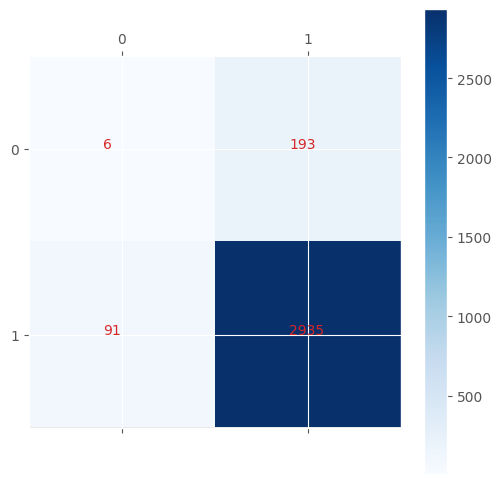

In [109]:
#Visualization for our XGBoost model confusion matrix 
plot_confusion_matrix(y_test3, prediction_xgb3)

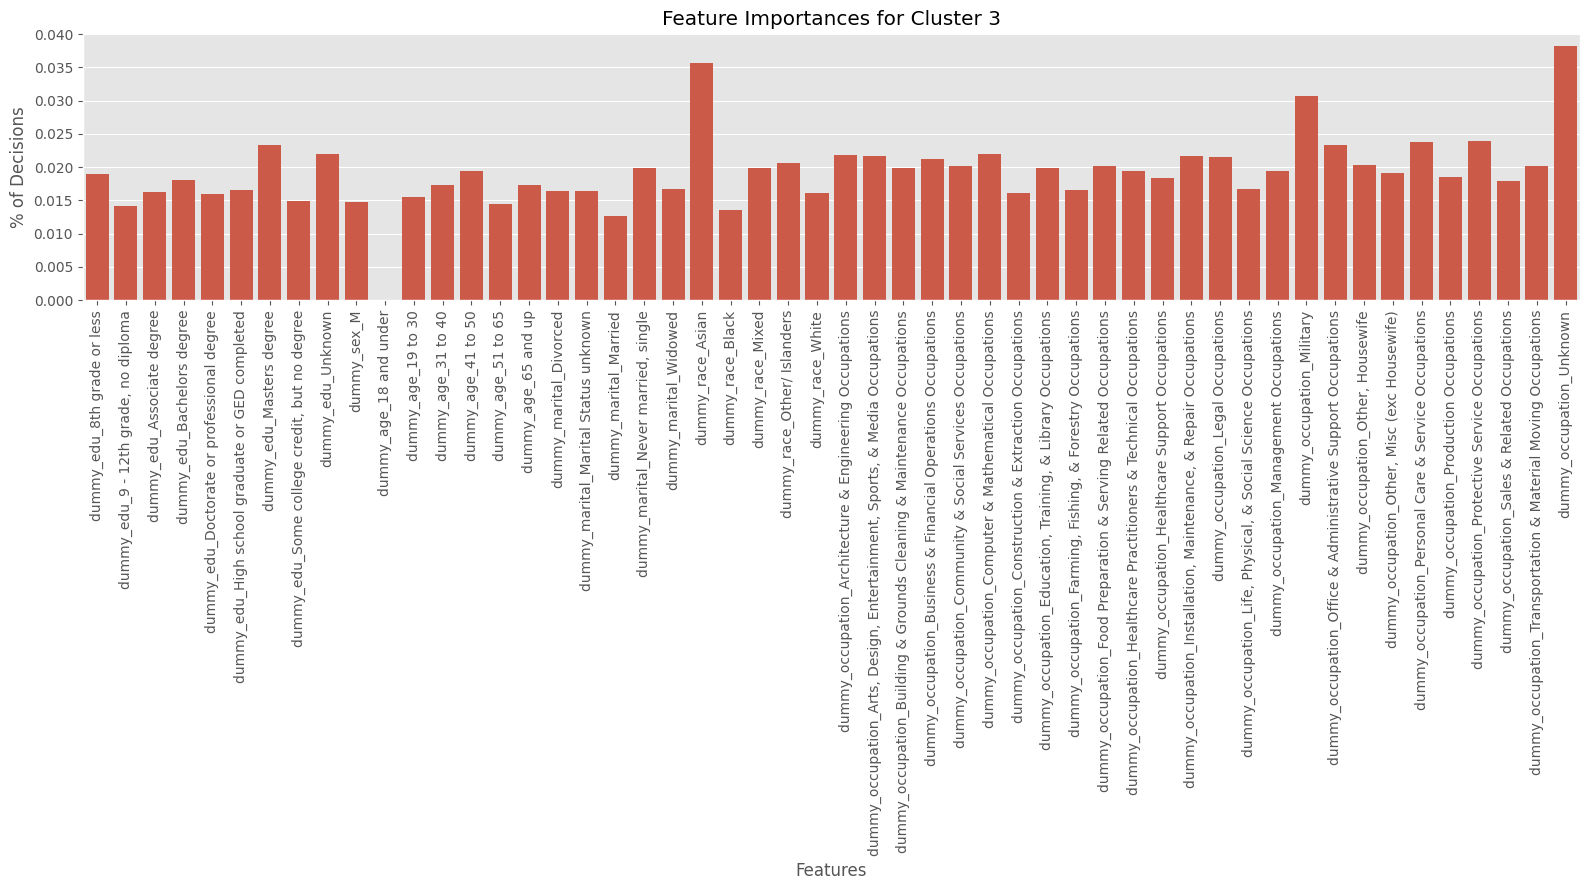

In [110]:
clus3_features = xgb3.feature_importances_

feature_importance(x_train3, clus3_features, 3)

In [111]:
#Tablular format of feature importances and the features being used to make decions for our XGBoost decision tree model
clus3_feature_importances_table = pd.DataFrame(data = {"Features": x_train3.columns, "Data": clus3_features})
clus3_feature_importances_table[clus3_feature_importances_table["Data"] > 0]

Features      Data
0                         dummy_edu_8th grade or less  0.018979
1                dummy_edu_9 - 12th grade, no diploma  0.014124
2                          dummy_edu_Associate degree  0.016342
3                          dummy_edu_Bachelors degree  0.018008
4          dummy_edu_Doctorate or professional degree  0.016034
5     dummy_edu_High school graduate or GED completed  0.016498
6                            dummy_edu_Masters degree  0.023353
7        dummy_edu_Some college credit, but no degree  0.014949
8                                   dummy_edu_Unknown  0.021944
9                                         dummy_sex_M  0.014790
11                                 dummy_age_19 to 30  0.015527
12                                 dummy_age_31 to 40  0.017246
13                                 dummy_age_41 to 50  0.019442
14                                 dummy_age_51 to 65  0.014502
15                                dummy_age_65 and up  0.017367
16                             dummy_marital_Divorced  0.016490
17               dummy_marital_Marital Status unknown  0.016370
18                              dummy_marital_Married  0.012659
19                dummy_marital_Never married, single  0.019919
20                              dummy_marital_Widowed  0.016771
21                                   dummy_race_Asian  0.035651
22                                   dummy_race_Black  0.013611
23                                   dummy_race_Mixed  0.019888
24                        dummy_race_Other/ Islanders  0.020625
25                                   dummy_race_White  0.016125
26  dummy_occupation_Architecture & Engineering Oc...  0.021857
27  dummy_occupation_Arts, Design, Entertainment, ...  0.021622
28  dummy_occupation_Building & Grounds Cleaning &...  0.019836
29  dummy_occupation_Business & Financial Operatio...  0.021276
30  dummy_occupation_Community & Social Services O...  0.020153
31  dummy_occupation_Computer & Mathematical Occup...  0.021930
32  dummy_occupation_Construction & Extraction Occ...  0.016180
33  dummy_occupation_Education, Training, & Librar...  0.019840
34  dummy_occupation_Farming, Fishing, & Forestry ...  0.016546
35  dummy_occupation_Food Preparation & Serving Re...  0.020218
36  dummy_occupation_Healthcare Practitioners & Te...  0.019409
37    dummy_occupation_Healthcare Support Occupations  0.018410
38  dummy_occupation_Installation, Maintenance, & ...  0.021707
39                 dummy_occupation_Legal Occupations  0.021571
40  dummy_occupation_Life, Physical, & Social Scie...  0.016646
41            dummy_occupation_Management Occupations  0.019401
42                          dummy_occupation_Military  0.030753
43  dummy_occupation_Office & Administrative Suppo...  0.023379
44                  dummy_occupation_Other, Housewife  0.020344
45       dummy_occupation_Other, Misc (exc Housewife)  0.019160
46  dummy_occupation_Personal Care & Service Occup...  0.023788
47            dummy_occupation_Production Occupations  0.018528
48    dummy_occupation_Protective Service Occupations  0.023883
49       dummy_occupation_Sales & Related Occupations  0.017933
50  dummy_occupation_Transportation & Material Mov...  0.020209
51                           dummy_occupation_Unknown  0.038206

In [112]:
clus3_top_5 = clus3_feature_importances_table.sort_values(by='Data', ascending=False).head(5)
clus3_top_5

Features      Data
51                           dummy_occupation_Unknown  0.038206
21                                   dummy_race_Asian  0.035651
42                          dummy_occupation_Military  0.030753
48    dummy_occupation_Protective Service Occupations  0.023883
46  dummy_occupation_Personal Care & Service Occup...  0.023788

# Cluster 4: XGBoost/ Oversample 20%/ Tuned

In [113]:
cluster_4 = cluster_4.drop('Clusters', axis=1)
cluster_4.head()

Education Sex AgeCategory  \
0  High school graduate or GED completed   M    19 to 30   
1  High school graduate or GED completed   M    19 to 30   
2                       Bachelors degree   M    19 to 30   
3     Some college credit, but no degree   M    19 to 30   
4             9 - 12th grade, no diploma   M    19 to 30   

          Marital Status              Race  \
0  Never married, single  Other/ Islanders   
1  Never married, single             White   
2  Never married, single             Black   
3  Never married, single             White   
4  Never married, single  Other/ Islanders   

                                         Occupation                      Death  
0          Farming, Fishing, & Forestry Occupations  Accidental Drug Poisoning  
1          Farming, Fishing, & Forestry Occupations  Accidental Drug Poisoning  
2       Business & Financial Operations Occupations  Accidental Drug Poisoning  
3  Healthcare Practitioners & Technical Occupations  Accidental Drug Poisoning  
4                       Other, Misc (exc Housewife)  Accidental Drug Poisoning

In [114]:
cluster_4 = pd.get_dummies(cluster_4, columns=['Education', 'Sex', 'AgeCategory', 'Marital Status', 'Race', 'Occupation', 'Death'], prefix=['dummy_edu','dummy_sex','dummy_age', 'dummy_marital', 'dummy_race', 'dummy_occupation', 'dummy_death'])
cluster_4.head()

dummy_edu_8th grade or less  dummy_edu_9 - 12th grade, no diploma  \
0                            0                                     0   
1                            0                                     0   
2                            0                                     0   
3                            0                                     0   
4                            0                                     1   

   dummy_edu_Associate degree  dummy_edu_Bachelors degree  \
0                           0                           0   
1                           0                           0   
2                           0                           1   
3                           0                           0   
4                           0                           0   

   dummy_edu_Doctorate or professional degree  \
0                                           0   
1                                           0   
2                                           0   
3                                           0   
4                                           0   

   dummy_edu_High school graduate or GED completed  dummy_edu_Masters degree  \
0                                                1                         0   
1                                                1                         0   
2                                                0                         0   
3                                                0                         0   
4                                                0                         0   

   dummy_edu_Some college credit, but no degree  dummy_edu_Unknown  \
0                                             0                  0   
1                                             0                  0   
2                                             0                  0   
3                                             1                  0   
4                                             0                  0   

   dummy_sex_F  ...  dummy_occupation_Other, Housewife  \
0            0  ...                                  0   
1            0  ...                                  0   
2            0  ...                                  0   
3            0  ...                                  0   
4            0  ...                                  0   

   dummy_occupation_Other, Misc (exc Housewife)  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             1   

   dummy_occupation_Personal Care & Service Occupations  \
0                                                  0      
1                                                  0      
2                                                  0      
3                                                  0      
4                                                  0      

   dummy_occupation_Production Occupations  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

   dummy_occupation_Protective Service Occupations  \
0                                                0   
1                                                0   
2                                                0   
3                                                0   
4                                                0   

   dummy_occupation_Sales & Related Occupations  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             0   

   dummy_occupation_Transportation & Material Moving Occupations  \
0                 

In [115]:
# Death and Sex attribute has two values only so we can drop one of them since they are considered redundant. 
#We are predicting Accidental or not, so only 1 column is sufficient. 

cluster_4.drop('dummy_death_Other', axis=1, inplace=True)
cluster_4.rename(columns={'dummy_death_Accidental Drug Poisoning': 'Death'}, inplace=True)
cluster_4.drop('dummy_sex_F', axis=1, inplace=True)

#1 = Accidental, 0 = Other

In [116]:
clus4_train, clus4_test = train_test_split(cluster_4, test_size=0.25, random_state=34)
print(clus4_train.shape)
print(clus4_test.shape)

(11271, 52)
(3758, 52)


In [117]:
print(clus4_train["Death"].count())
print(clus4_train["Death"].value_counts(normalize = True))
clus4_train["Death"].value_counts()

11271
1    0.948097
0    0.051903
Name: Death, dtype: float64


1    10686
0      585
Name: Death, dtype: int64

In [118]:
num_samples_other_deaths_4 = determine_samples(len(clus4_train), 585, 0.2)
print("Other Deaths oversample samples to add in Cluster 4: ", num_samples_other_deaths_4)

Other Deaths oversample samples to add in Cluster 4:  2086


In [119]:
to_resample_4 = clus4_train.loc[clus4_train['Death'] == 0]

In [120]:
our_resample_4 = to_resample_4.sample(n = 2086 , replace = True)
clus4_train_rebal = pd.concat([clus4_train, our_resample_4])

In [121]:
clus4_train_rebal['Death'].value_counts()

1    10686
0     2671
Name: Death, dtype: int64

In [122]:
x_train4 = clus4_train_rebal.drop('Death', axis=1)
y_train4 = clus4_train_rebal['Death']

In [123]:
x_test4 = clus4_test.drop('Death', axis=1)
y_test4 = clus4_test['Death']

In [124]:
print(f'Our baseline model for Cluster 4 is {y_train4.value_counts(normalize = True)[1] * 100}% accurate')
print(f'Our baseline model for Cluster 4 based on the testing partition is {y_test4.value_counts(normalize = True)[1] * 100}% accurate')

Our baseline model for Cluster 4 is 80.00299468443512% accurate
Our baseline model for Cluster 4 based on the testing partition is 94.598190526876% accurate


In [125]:
#Using CrossValidation for model selection: 
clus4_models_dict = {'RandomForest': RandomForestClassifier(n_estimators = 10, criterion='gini', random_state = 34), 
                     'NaiveBayes': MultinomialNB(alpha=1.0, fit_prior=True), 
                     'XGBoost': XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic'),
                     'Decision Tree': DecisionTreeClassifier(criterion="entropy",max_leaf_nodes=5, random_state = 34)}

clus4_model_cv_score = {}

for name, model in clus4_models_dict.items():
    score4 = cross_val_score(model, x_train4, y_train4, cv=kfold)
    clus4_model_cv_score[name] = score4.mean()

print(f'Model Scores: {clus4_model_cv_score}')

Model Scores: {'RandomForest': 0.8078173428424049, 'NaiveBayes': 0.7997318845455157, 'XGBoost': 0.8001061360425217, 'Decision Tree': 0.8001061360425217}


In [99]:
#We are going to use XGBoost or DecisionTree as they have the highest accuracies (using stratified k fold cv)
clus4_params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'min_child_weight': [1, 3, 5, 7]
}

grid4 = GridSearchCV(XGBClassifier(), param_grid = clus4_params, cv = kfold, n_jobs = -1, verbose = 1)
grid4.fit(x_train4, y_train4)

print("Best Parameters found for Cluster 4: ", grid4.best_params_)
print("Best Accuracy through grid search for Cluster 4: %.3f"%grid4.best_score_)

Fitting 10 folds for each of 3840 candidates, totalling 38400 fits
Best Parameters found for Cluster 4:  {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 400, 'subsample': 0.8}
Best Accuracy through grid search for Cluster 4: 0.806


In [126]:
#BEST SCORE:
xgb4 = XGBClassifier(colsample_bytree = 0.9, learning_rate = 0.1, max_depth = 7, min_child_weight = 1,
                     n_estimators = 400, subsample = 0.8, random_state=34).fit(x_train4, y_train4)

xgb4_score = cross_val_score(xgb4, x_train4, y_train4, cv=kfold)

In [127]:
print(f"Our XGBoost with the best optimized parameters on the Testing set for Cluster 4 is: {xgb4.score(x_test4, y_test4) * 100}% accurate")
print(f"Our XGBoost Classification model with optimized parameters with k-fold cross validation on the training dataset for Cluster 4 is: {xgb4_score.mean() * 100}% accurate")

Our XGBoost with the best optimized parameters on the Testing set for Cluster 4 is: 92.97498669505056% accurate
Our XGBoost Classification model with optimized parameters with k-fold cross validation on the training dataset for Cluster 4 is: 80.86404157976183% accurate


In [128]:
prediction_xgb4 = xgb4.predict(x_test4)

print("Classification Report for Cluster 4:")
print(classification_report(y_test4, prediction_xgb4))
print("===========")
print("Confusion Matrix")
print(confusion_matrix(y_test4, prediction_xgb4))
print("============")
print("Accuracy Score: ", accuracy_score(prediction_xgb4, y_test4))
print("==============")

test4_predictions_proba = xgb4.predict_proba(x_test4)
log_4 = log_loss(y_test4, test4_predictions_proba)
print("Log Loss: {:.4}".format(log_4))
print("===============")

Classification Report for Cluster 4:
              precision    recall  f1-score   support

           0       0.11      0.04      0.06       203
           1       0.95      0.98      0.96      3555

    accuracy                           0.93      3758
   macro avg       0.53      0.51      0.51      3758
weighted avg       0.90      0.93      0.91      3758

Confusion Matrix
[[   9  194]
 [  70 3485]]
Accuracy Score:  0.9297498669505055
Log Loss: 0.2971


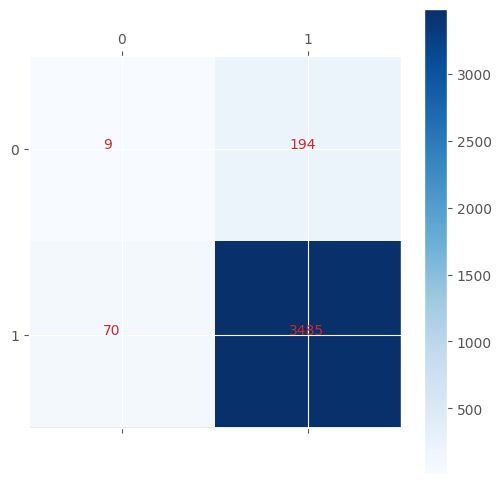

In [129]:
#Visualization for our XGBoost model confusion matrix 
plot_confusion_matrix(y_test4, prediction_xgb4)

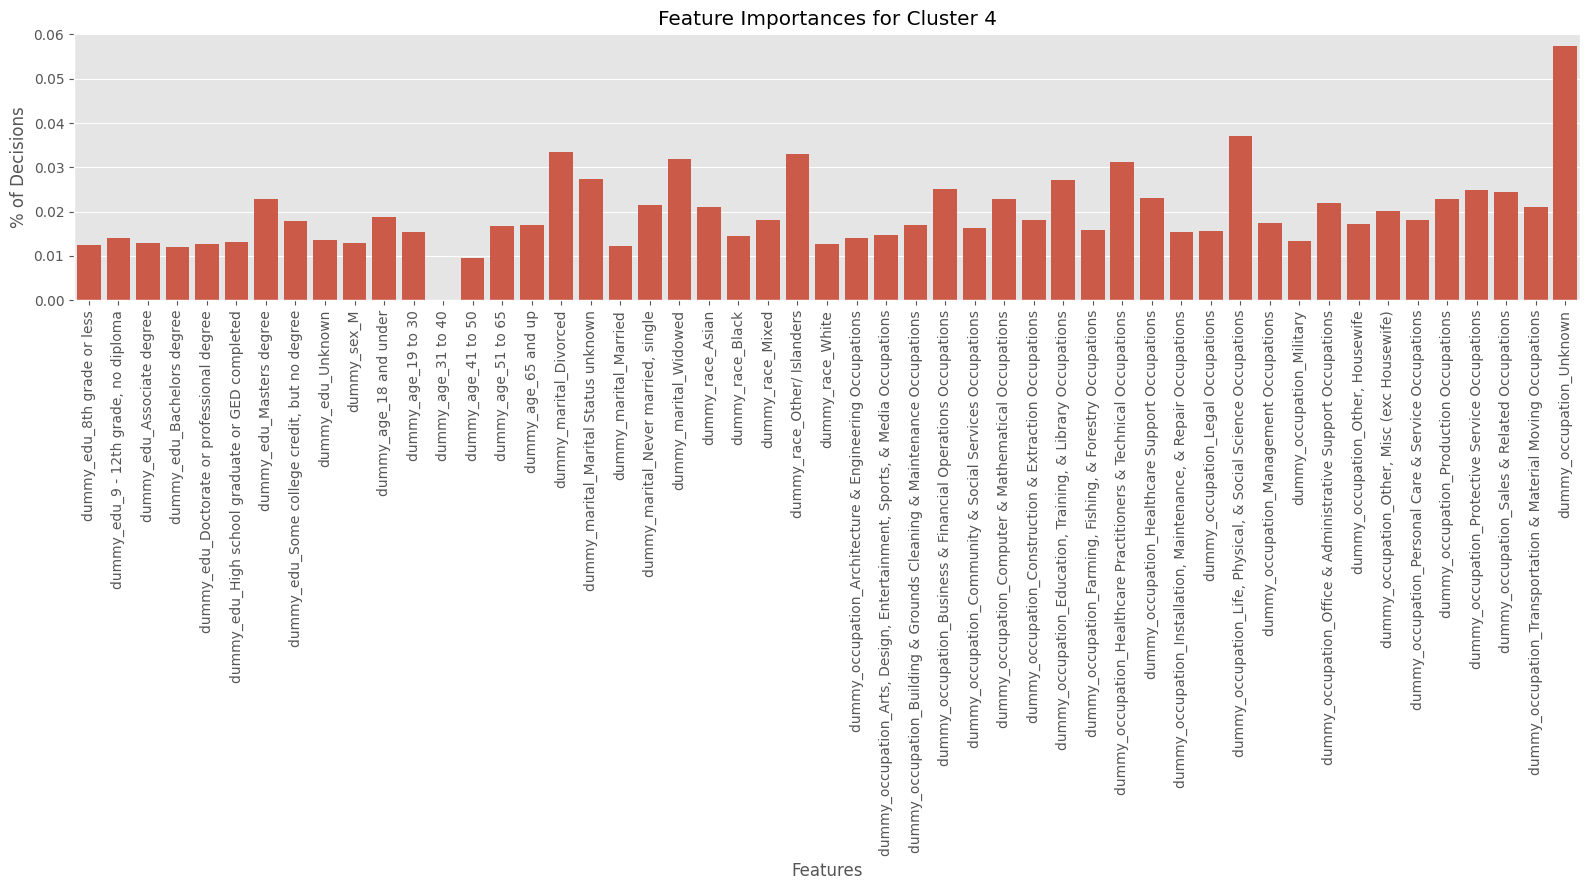

In [130]:
clus4_features = xgb4.feature_importances_

feature_importance(x_train4, clus4_features, 4)

In [131]:
#Tablular format of feature importances and the features being used to make decions for our XGBoost decision tree model
clus4_feature_importances_table = pd.DataFrame(data = {"Features": x_train4.columns, "Data": clus4_features})
clus4_feature_importances_table[clus4_feature_importances_table["Data"] > 0]

Features      Data
0                         dummy_edu_8th grade or less  0.012489
1                dummy_edu_9 - 12th grade, no diploma  0.014052
2                          dummy_edu_Associate degree  0.012959
3                          dummy_edu_Bachelors degree  0.011988
4          dummy_edu_Doctorate or professional degree  0.012657
5     dummy_edu_High school graduate or GED completed  0.013118
6                            dummy_edu_Masters degree  0.022850
7        dummy_edu_Some college credit, but no degree  0.017854
8                                   dummy_edu_Unknown  0.013542
9                                         dummy_sex_M  0.013002
10                             dummy_age_18 and under  0.018802
11                                 dummy_age_19 to 30  0.015469
13                                 dummy_age_41 to 50  0.009478
14                                 dummy_age_51 to 65  0.016668
15                                dummy_age_65 and up  0.016972
16                             dummy_marital_Divorced  0.033380
17               dummy_marital_Marital Status unknown  0.027274
18                              dummy_marital_Married  0.012351
19                dummy_marital_Never married, single  0.021568
20                              dummy_marital_Widowed  0.031887
21                                   dummy_race_Asian  0.021124
22                                   dummy_race_Black  0.014586
23                                   dummy_race_Mixed  0.018157
24                        dummy_race_Other/ Islanders  0.032904
25                                   dummy_race_White  0.012760
26  dummy_occupation_Architecture & Engineering Oc...  0.013951
27  dummy_occupation_Arts, Design, Entertainment, ...  0.014794
28  dummy_occupation_Building & Grounds Cleaning &...  0.016932
29  dummy_occupation_Business & Financial Operatio...  0.025025
30  dummy_occupation_Community & Social Services O...  0.016200
31  dummy_occupation_Computer & Mathematical Occup...  0.022757
32  dummy_occupation_Construction & Extraction Occ...  0.018017
33  dummy_occupation_Education, Training, & Librar...  0.027210
34  dummy_occupation_Farming, Fishing, & Forestry ...  0.015878
35  dummy_occupation_Healthcare Practitioners & Te...  0.031160
36    dummy_occupation_Healthcare Support Occupations  0.023139
37  dummy_occupation_Installation, Maintenance, & ...  0.015375
38                 dummy_occupation_Legal Occupations  0.015538
39  dummy_occupation_Life, Physical, & Social Scie...  0.037133
40            dummy_occupation_Management Occupations  0.017332
41                          dummy_occupation_Military  0.013402
42  dummy_occupation_Office & Administrative Suppo...  0.022051
43                  dummy_occupation_Other, Housewife  0.017265
44       dummy_occupation_Other, Misc (exc Housewife)  0.020158
45  dummy_occupation_Personal Care & Service Occup...  0.018057
46            dummy_occupation_Production Occupations  0.022907
47    dummy_occupation_Protective Service Occupations  0.024965
48       dummy_occupation_Sales & Related Occupations  0.024386
49  dummy_occupation_Transportation & Material Mov...  0.021081
50                           dummy_occupation_Unknown  0.057394

In [132]:
clus4_top_5 = clus4_feature_importances_table.sort_values(by='Data', ascending=False).head(5)
clus4_top_5

Features      Data
50                           dummy_occupation_Unknown  0.057394
39  dummy_occupation_Life, Physical, & Social Scie...  0.037133
16                             dummy_marital_Divorced  0.033380
24                        dummy_race_Other/ Islanders  0.032904
20                              dummy_marital_Widowed  0.031887

# Merging and getting graph of top 5 features:

In [194]:
# Adding a column to each top 5 features dataframe from each cluster 
#first to recognize what cluster the feature belongs to once we cut it.

clus1_top_5['Cluster'] = 'Cluster 1'
clus2_top_5['Cluster'] = 'Cluster 2'
clus3_top_5['Cluster'] = 'Cluster 3'
clus4_top_5['Cluster'] = 'Cluster 4'

In [195]:
clusters_top_5 = pd.concat([clus1_top_5, clus2_top_5, clus3_top_5, clus4_top_5], axis=0)
clusters_top_5.reset_index(drop=True, inplace=True)

clusters_top_5

Features      Data    Cluster
0                              dummy_age_18 and under  0.094055  Cluster 1
1                            dummy_occupation_Unknown  0.068548  Cluster 1
2                                 dummy_age_65 and up  0.025091  Cluster 1
3                                    dummy_race_Asian  0.075175  Cluster 2
4   dummy_occupation_Farming, Fishing, & Forestry ...  0.072581  Cluster 2
5                            dummy_occupation_Unknown  0.026812  Cluster 2
6                            dummy_occupation_Unknown  0.059263  Cluster 3
7   dummy_occupation_Life, Physical, & Social Scie...  0.024674  Cluster 3
8   dummy_occupation_Office & Administrative Suppo...  0.023683  Cluster 3
9                            dummy_occupation_Unknown  0.057664  Cluster 4
10  dummy_occupation_Healthcare Practitioners & Te...  0.033243  Cluster 4
11                              dummy_marital_Widowed  0.031735  Cluster 4

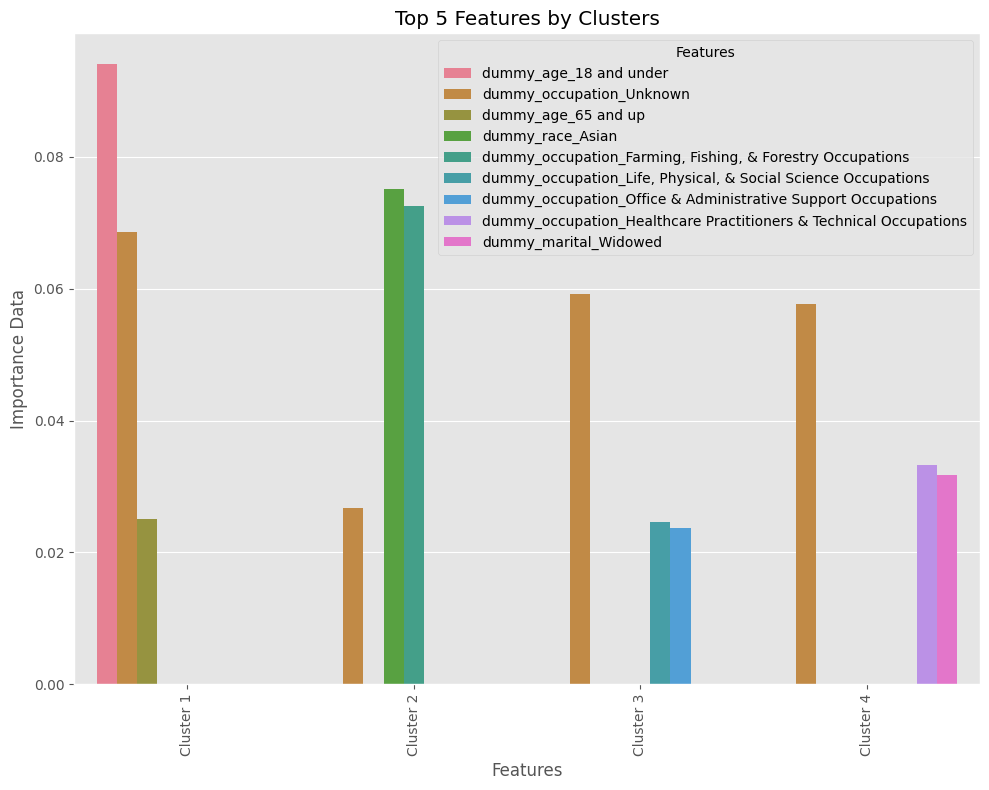

In [197]:
sns.barplot(x='Cluster', y='Data', hue='Features', data=clusters_top_5)

plt.xlabel("Features")
plt.xticks(rotation=90)
plt.ylabel("Importance Data")
plt.title("Top 5 Features by Clusters")
plt.legend(title='Features')
plt.tight_layout()
plt.show()

In [198]:
all_clusters_top_5 = clusters_top_5.sort_values(by='Data', ascending=False).head(5)
all_clusters_top_5

Features      Data    Cluster
0                             dummy_age_18 and under  0.094055  Cluster 1
3                                   dummy_race_Asian  0.075175  Cluster 2
4  dummy_occupation_Farming, Fishing, & Forestry ...  0.072581  Cluster 2
1                           dummy_occupation_Unknown  0.068548  Cluster 1
6                           dummy_occupation_Unknown  0.059263  Cluster 3

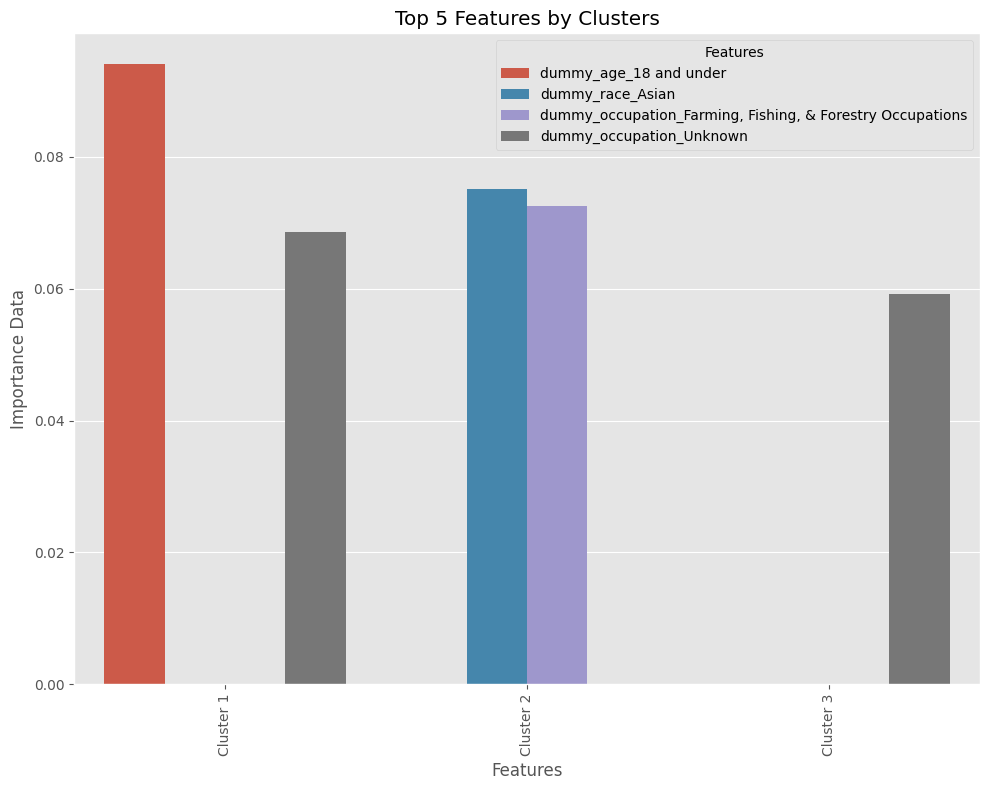

In [199]:
sns.barplot(x='Cluster', y='Data', hue='Features', data=all_clusters_top_5)

plt.xlabel("Features")
plt.xticks(rotation=90)
plt.ylabel("Importance Data")
plt.title("Top 5 Features by Clusters")
plt.legend(title='Features', loc='upper right')
plt.tight_layout()
plt.show()

# Cluster 1: XGBoost/ No oversample/ Tuned

In [53]:
cluster_1 = cluster_1.drop('Clusters', axis=1)
cluster_1.head()

Education Sex AgeCategory  \
0     Some college credit, but no degree   M    31 to 40   
1  High school graduate or GED completed   M    31 to 40   
2                                Unknown   M    31 to 40   
3             9 - 12th grade, no diploma   F    31 to 40   
4  High school graduate or GED completed   F    19 to 30   

          Marital Status              Race  \
0  Never married, single             White   
1  Never married, single  Other/ Islanders   
2  Never married, single  Other/ Islanders   
3               Divorced  Other/ Islanders   
4  Never married, single             White   

                                       Occupation                      Death  
0                          Management Occupations  Accidental Drug Poisoning  
1  Food Preparation & Serving Related Occupations  Accidental Drug Poisoning  
2           Construction & Extraction Occupations  Accidental Drug Poisoning  
3                                Other, Housewife  Accidental Drug Poisoning  
4  Food Preparation & Serving Related Occupations  Accidental Drug Poisoning

In [54]:
cluster_1 = pd.get_dummies(cluster_1, columns=['Education', 'Sex', 'AgeCategory', 'Marital Status', 'Race', 'Occupation', 'Death'], prefix=['dummy_edu','dummy_sex','dummy_age', 'dummy_marital', 'dummy_race', 'dummy_occupation', 'dummy_death'])
cluster_1.head()

dummy_edu_8th grade or less  dummy_edu_9 - 12th grade, no diploma  \
0                            0                                     0   
1                            0                                     0   
2                            0                                     0   
3                            0                                     1   
4                            0                                     0   

   dummy_edu_Associate degree  dummy_edu_Bachelors degree  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           0                           0   

   dummy_edu_Doctorate or professional degree  \
0                                           0   
1                                           0   
2                                           0   
3                                           0   
4                                           0   

   dummy_edu_High school graduate or GED completed  dummy_edu_Masters degree  \
0                                                0                         0   
1                                                1                         0   
2                                                0                         0   
3                                                0                         0   
4                                                1                         0   

   dummy_edu_Some college credit, but no degree  dummy_edu_Unknown  \
0                                             1                  0   
1                                             0                  0   
2                                             0                  1   
3                                             0                  0   
4                                             0                  0   

   dummy_sex_F  ...  dummy_occupation_Other, Housewife  \
0            0  ...                                  0   
1            0  ...                                  0   
2            0  ...                                  0   
3            1  ...                                  1   
4            1  ...                                  0   

   dummy_occupation_Other, Misc (exc Housewife)  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             0   

   dummy_occupation_Personal Care & Service Occupations  \
0                                                  0      
1                                                  0      
2                                                  0      
3                                                  0      
4                                                  0      

   dummy_occupation_Production Occupations  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

   dummy_occupation_Protective Service Occupations  \
0                                                0   
1                                                0   
2                                                0   
3                                                0   
4                                                0   

   dummy_occupation_Sales & Related Occupations  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             0   

   dummy_occupation_Transportation & Material Moving Occupations  \
0                 

In [55]:
# Sex and Death attribute has two values only so we can drop one of them since they are considered redundant. 

cluster_1.drop('dummy_death_Other', axis=1, inplace=True)
cluster_1.rename(columns={'dummy_death_Accidental Drug Poisoning': 'Death'}, inplace=True)
cluster_1.drop('dummy_sex_F', axis=1, inplace=True)

#1 = Accidental, 0 = Other

In [56]:
clus1_train, clus1_test = train_test_split(cluster_1, test_size=0.25, random_state=34)
print(clus1_train.shape)
print(clus1_test.shape)

(24030, 53)
(8010, 53)


In [57]:
print(clus1_train["Death"].count())
print(clus1_train["Death"].value_counts(normalize = True))
clus1_train["Death"].value_counts()

24030
1    0.937703
0    0.062297
Name: Death, dtype: float64


1    22533
0     1497
Name: Death, dtype: int64

In [58]:
x_train1 = clus1_train.drop('Death', axis=1)
y_train1 = clus1_train['Death']

In [59]:
x_test1 = clus1_test.drop('Death', axis=1)
y_test1 = clus1_test['Death']

In [60]:
kfold = KFold(n_splits= 10, shuffle=True, random_state=34)

In [61]:
print(f'Our baseline model for Cluster 1 is {y_train1.value_counts(normalize = True)[0] * 100}% accurate')
print(f'Our baseline model for Cluster 1 based on the testing partition is {y_test1.value_counts(normalize = True)[0] * 100}% accurate')

Our baseline model for Cluster 1 is 6.229712858926343% accurate
Our baseline model for Cluster 1 based on the testing partition is 5.905118601747815% accurate


In [62]:
#Using CrossValidation for model selection: 
clus1_models_dict = {'RandomForest': RandomForestClassifier(n_estimators = 10, criterion='gini', random_state = 34), 
                     'NaiveBayes': MultinomialNB(alpha=1.0, fit_prior=True), 
                     'XGBoost': XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic'),
                     'Decision Tree': DecisionTreeClassifier(criterion="entropy",max_leaf_nodes=5, random_state = 34)}

clus1_model_cv_score = {}

for name, model in clus1_models_dict.items():
    score1 = cross_val_score(model, x_train1, y_train1, cv=kfold)
    clus1_model_cv_score[name] = score1.mean()

print(f'Model Scores: {clus1_model_cv_score}')

Model Scores: {'RandomForest': 0.9339991677070328, 'NaiveBayes': 0.9378277153558052, 'XGBoost': 0.9386183936745734, 'Decision Tree': 0.9384519350811485}


In [62]:
#We are going to use XGBoost or DecisionTree as they have the highest accuracies (using stratified k fold cv)
clus1_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [3, 5, 7],
    'scale_pos_weight': [10, 15, 20]
}

grid1 = GridSearchCV(XGBClassifier(), param_grid = clus1_params, cv = kfold, n_jobs = -1, verbose = 1)
grid1.fit(x_train1, y_train1)

print("Best Parameters found for Cluster 1: ", grid1.best_params_)
print("Best Accuracy through grid search for Cluster 1: %.3f"%grid1.best_score_)

Fitting 10 folds for each of 6561 candidates, totalling 65610 fits
Best Parameters found for Cluster 1:  {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 300, 'scale_pos_weight': 20, 'subsample': 0.8}
Best Accuracy through grid search for Cluster 1: 0.938


In [63]:
#BEST SCORE: 0.27/ 0.82/ 78.83% = FOUND IN GRIDSEARCH RUN 2
xgb1 = XGBClassifier(colsample_bytree = 0.9, gamma = 0, learning_rate = 0.1, max_depth = 7, 
                     min_child_weight = 3, n_estimators = 300, scale_pos_weight = 20, subsample = 0.8, random_state=34).fit(x_train1, y_train1)

xgb1_score = cross_val_score(xgb1, x_train1, y_train1, cv=kfold)

In [64]:
print(f"Our XGBoost with the best optimized parameters on the Testing set for Cluster 1 is: {xgb1.score(x_test1, y_test1) * 100}% accurate")
print(f"Our XGBoost Classification model with optimized parameters with k-fold cross validation on the training dataset for Cluster 1 is: {xgb1_score.mean() * 100}% accurate")

Our XGBoost with the best optimized parameters on the Testing set for Cluster 1 is: 94.08239700374533% accurate
Our XGBoost Classification model with optimized parameters with k-fold cross validation on the training dataset for Cluster 1 is: 93.76612567623802% accurate


In [65]:
prediction_xgb1 = xgb1.predict(x_test1)

print("Classification Report for Cluster 1:")
print(classification_report(y_test1, prediction_xgb1))
print("===========")
print("Confusion Matrix")
print(confusion_matrix(y_test1, prediction_xgb1))
print("============")
print("Accuracy Score: ", accuracy_score(prediction_xgb1, y_test1))
print("==============")

test1_predictions_proba = xgb1.predict_proba(x_test1)
log_1 = log_loss(y_test1, test1_predictions_proba)
print("Log Loss: {:.4}".format(log_1))
print("===============")

Classification Report for Cluster 1:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       473
           1       0.94      1.00      0.97      7537

    accuracy                           0.94      8010
   macro avg       0.47      0.50      0.48      8010
weighted avg       0.89      0.94      0.91      8010

Confusion Matrix
[[   0  473]
 [   1 7536]]
Accuracy Score:  0.9408239700374532
Log Loss: 0.3395


In [66]:
def plot_confusion_matrix(Y_test, Y_preds):
    conf_mat = confusion_matrix(Y_test, Y_preds)
    fig = plt.figure(figsize=(6,6))
    plt.matshow(conf_mat, cmap=plt.cm.Blues, fignum=1)
    plt.yticks(range(2), range(2))
    plt.xticks(range(2), range(2))
    plt.colorbar();
    for i in range(2):
        for j in range(2):
            plt.text(i-0.1,j, str(conf_mat[j, i]), color='tab:red')
    #plt.savefig('Cluster1ConfusionMatrix.png')

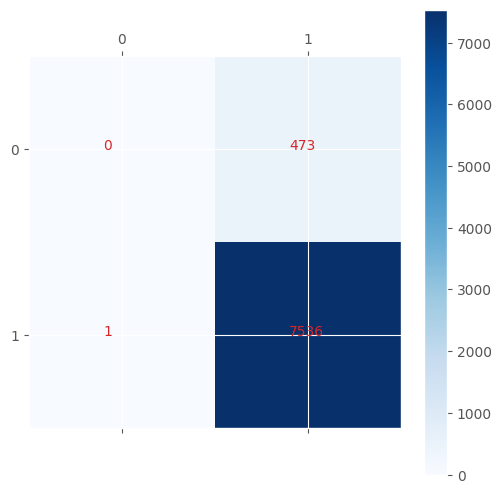

In [67]:
#Visualization for our XGBoost model confusion matrix 
plot_confusion_matrix(y_test1, prediction_xgb1)

In [68]:
def feature_importance(x, y, cluster):
    plt.figure(figsize = (16 , 9))
    sns.barplot(x = x.columns, y = y)
    plt.xlabel("Features")
    plt.xticks(rotation=90)
    plt.ylabel("% of Decisions")
    plt.title(f"Feature Importances for Cluster {cluster}")
    plt.tight_layout()
    #plt.savefig('Cluster1FeatureImportance.png')
    plt.show()

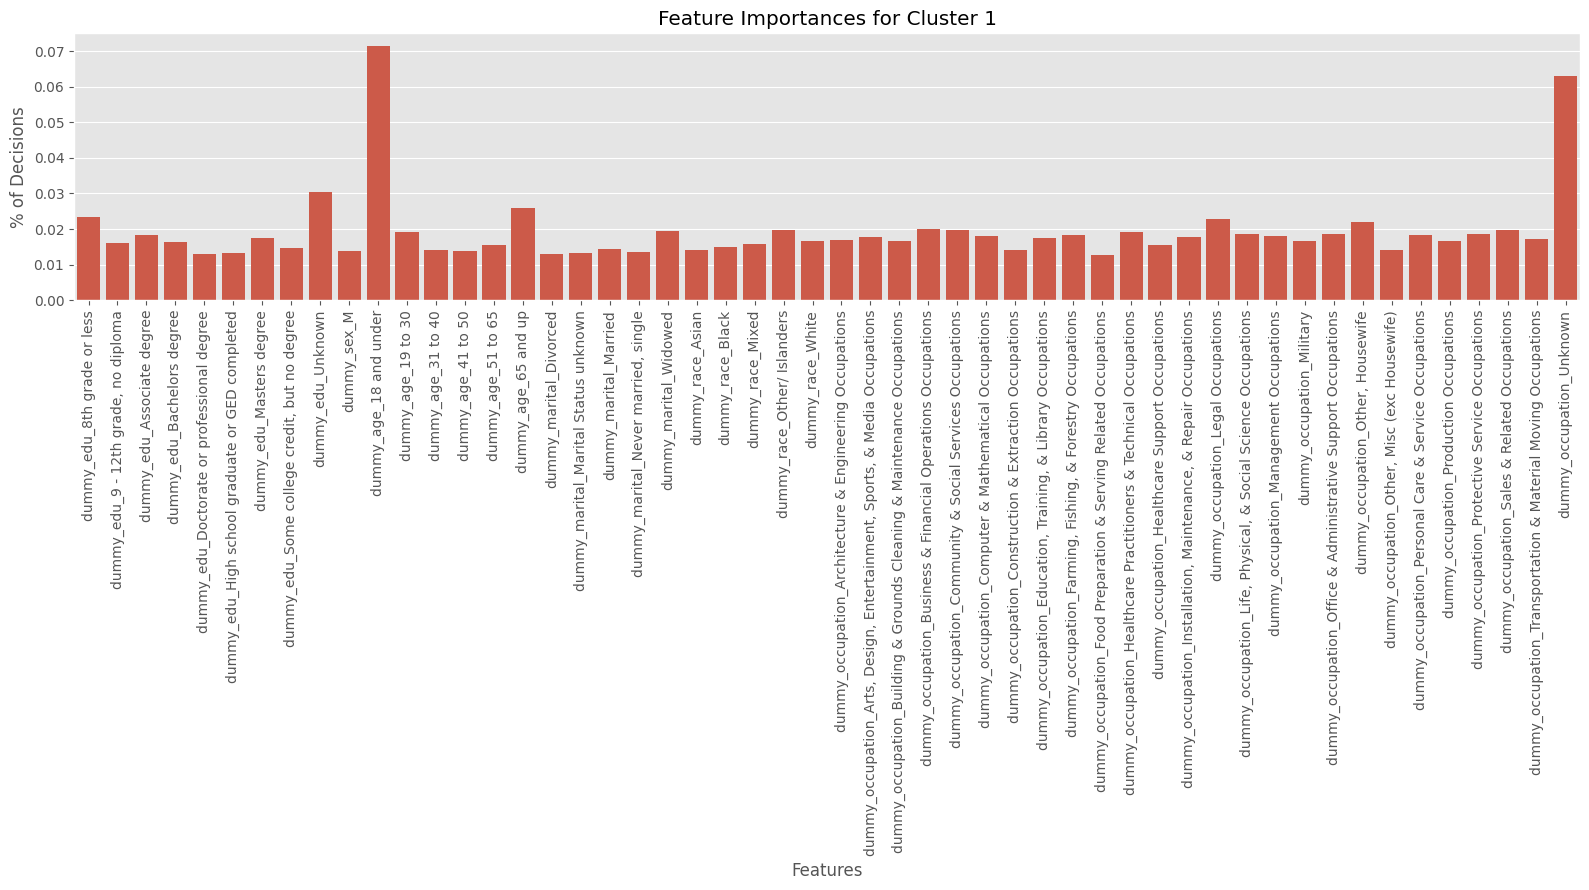

In [69]:
clus1_features = xgb1.feature_importances_

feature_importance(x_train1, clus1_features, 1)

In [70]:
#Tablular format of feature importances and the features being used to make decions for our XGBoost decision tree model
clus1_feature_importances_table = pd.DataFrame(data = {"Features": x_train1.columns, "Data": clus1_features})
clus1_feature_importances_table[clus1_feature_importances_table["Data"] > 0]

Features      Data
0                         dummy_edu_8th grade or less  0.023275
1                dummy_edu_9 - 12th grade, no diploma  0.015993
2                          dummy_edu_Associate degree  0.018198
3                          dummy_edu_Bachelors degree  0.016385
4          dummy_edu_Doctorate or professional degree  0.012978
5     dummy_edu_High school graduate or GED completed  0.013246
6                            dummy_edu_Masters degree  0.017508
7        dummy_edu_Some college credit, but no degree  0.014650
8                                   dummy_edu_Unknown  0.030340
9                                         dummy_sex_M  0.013892
10                             dummy_age_18 and under  0.071441
11                                 dummy_age_19 to 30  0.019234
12                                 dummy_age_31 to 40  0.014155
13                                 dummy_age_41 to 50  0.013903
14                                 dummy_age_51 to 65  0.015429
15                                dummy_age_65 and up  0.025797
16                             dummy_marital_Divorced  0.013039
17               dummy_marital_Marital Status unknown  0.013213
18                              dummy_marital_Married  0.014372
19                dummy_marital_Never married, single  0.013686
20                              dummy_marital_Widowed  0.019534
21                                   dummy_race_Asian  0.014125
22                                   dummy_race_Black  0.014917
23                                   dummy_race_Mixed  0.015889
24                        dummy_race_Other/ Islanders  0.019839
25                                   dummy_race_White  0.016785
26  dummy_occupation_Architecture & Engineering Oc...  0.017056
27  dummy_occupation_Arts, Design, Entertainment, ...  0.017648
28  dummy_occupation_Building & Grounds Cleaning &...  0.016550
29  dummy_occupation_Business & Financial Operatio...  0.019898
30  dummy_occupation_Community & Social Services O...  0.019646
31  dummy_occupation_Computer & Mathematical Occup...  0.018168
32  dummy_occupation_Construction & Extraction Occ...  0.014091
33  dummy_occupation_Education, Training, & Librar...  0.017563
34  dummy_occupation_Farming, Fishing, & Forestry ...  0.018318
35  dummy_occupation_Food Preparation & Serving Re...  0.012706
36  dummy_occupation_Healthcare Practitioners & Te...  0.019055
37    dummy_occupation_Healthcare Support Occupations  0.015468
38  dummy_occupation_Installation, Maintenance, & ...  0.017870
39                 dummy_occupation_Legal Occupations  0.022719
40  dummy_occupation_Life, Physical, & Social Scie...  0.018531
41            dummy_occupation_Management Occupations  0.017961
42                          dummy_occupation_Military  0.016661
43  dummy_occupation_Office & Administrative Suppo...  0.018685
44                  dummy_occupation_Other, Housewife  0.022101
45       dummy_occupation_Other, Misc (exc Housewife)  0.014012
46  dummy_occupation_Personal Care & Service Occup...  0.018390
47            dummy_occupation_Production Occupations  0.016528
48    dummy_occupation_Protective Service Occupations  0.018745
49       dummy_occupation_Sales & Related Occupations  0.019646
50  dummy_occupation_Transportation & Material Mov...  0.017130
51                           dummy_occupation_Unknown  0.063031

# Cluster 2: XGBoost/ No oversample/ Tuned

In [42]:
cluster_2 = cluster_2.drop('Clusters', axis=1)
cluster_2.head()

Education Sex   AgeCategory  \
0          9 - 12th grade, no diploma   M  18 and under   
1                             Unknown   F      51 to 65   
2                      Masters degree   M      41 to 50   
3  Some college credit, but no degree   F      31 to 40   
4          9 - 12th grade, no diploma   F      31 to 40   

          Marital Status              Race  \
0  Never married, single             White   
1                Married             White   
2               Divorced             White   
3                Married  Other/ Islanders   
4                Married             Mixed   

                                   Occupation                      Death  
0                 Other, Misc (exc Housewife)  Accidental Drug Poisoning  
1                 Other, Misc (exc Housewife)                      Other  
2  Education, Training, & Library Occupations  Accidental Drug Poisoning  
3                 Other, Misc (exc Housewife)  Accidental Drug Poisoning  
4                 Other, Misc (exc Housewife)  Accidental Drug Poisoning

In [43]:
cluster_2 = pd.get_dummies(cluster_2, columns=['Education', 'Sex', 'AgeCategory', 'Marital Status', 'Race', 'Occupation', 'Death'], prefix=['dummy_edu','dummy_sex','dummy_age', 'dummy_marital', 'dummy_race', 'dummy_occupation', 'dummy_death'])
cluster_2.head()

dummy_edu_8th grade or less  dummy_edu_9 - 12th grade, no diploma  \
0                            0                                     1   
1                            0                                     0   
2                            0                                     0   
3                            0                                     0   
4                            0                                     1   

   dummy_edu_Associate degree  dummy_edu_Bachelors degree  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           0                           0   

   dummy_edu_Doctorate or professional degree  \
0                                           0   
1                                           0   
2                                           0   
3                                           0   
4                                           0   

   dummy_edu_High school graduate or GED completed  dummy_edu_Masters degree  \
0                                                0                         0   
1                                                0                         0   
2                                                0                         1   
3                                                0                         0   
4                                                0                         0   

   dummy_edu_Some college credit, but no degree  dummy_edu_Unknown  \
0                                             0                  0   
1                                             0                  1   
2                                             0                  0   
3                                             1                  0   
4                                             0                  0   

   dummy_sex_F  ...  dummy_occupation_Other, Housewife  \
0            0  ...                                  0   
1            1  ...                                  0   
2            0  ...                                  0   
3            1  ...                                  0   
4            1  ...                                  0   

   dummy_occupation_Other, Misc (exc Housewife)  \
0                                             1   
1                                             1   
2                                             0   
3                                             1   
4                                             1   

   dummy_occupation_Personal Care & Service Occupations  \
0                                                  0      
1                                                  0      
2                                                  0      
3                                                  0      
4                                                  0      

   dummy_occupation_Production Occupations  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

   dummy_occupation_Protective Service Occupations  \
0                                                0   
1                                                0   
2                                                0   
3                                                0   
4                                                0   

   dummy_occupation_Sales & Related Occupations  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             0   

   dummy_occupation_Transportation & Material Moving Occupations  \
0                 

In [44]:
# Death and Sex attribute has two values only so we can drop one of them since they are considered redundant. 
#We are predicting Accidental or not, so only 1 column is sufficient. 

cluster_2.drop('dummy_death_Other', axis=1, inplace=True)
cluster_2.rename(columns={'dummy_death_Accidental Drug Poisoning': 'Death'}, inplace=True)
cluster_2.drop('dummy_sex_F', axis=1, inplace=True)

#1 = Accidental, 0 = Other

In [45]:
#x2 = cluster_2.drop('Death', axis=1)
#y2 = cluster_2['Death']

In [46]:
clus2_train, clus2_test = train_test_split(cluster_2, test_size=0.25, random_state=34)
print(clus2_train.shape)
print(clus2_test.shape)

(9191, 53)
(3064, 53)


In [47]:
#x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size=0.25, random_state=34, stratify=y2)

In [48]:
print(clus2_train["Death"].count())
print(clus2_train["Death"].value_counts(normalize = True))
clus2_train["Death"].value_counts()

9191
1    0.93548
0    0.06452
Name: Death, dtype: float64


1    8598
0     593
Name: Death, dtype: int64

In [49]:
x_train2 = clus2_train.drop('Death', axis=1)
y_train2 = clus2_train['Death']

In [50]:
x_test2 = clus2_test.drop('Death', axis=1)
y_test2 = clus2_test['Death']

In [51]:
print(f'Our baseline model for Cluster 2 is {y_train2.value_counts(normalize = True)[0] * 100}% accurate')
print(f'Our baseline model for Cluster 2 based on the testing partition is {y_test2.value_counts(normalize = True)[0] * 100}% accurate')

Our baseline model for Cluster 2 is 6.451963877706452% accurate
Our baseline model for Cluster 2 based on the testing partition is 6.1684073107049615% accurate


In [71]:
#Using CrossValidation for model selection: 
clus2_models_dict = {'RandomForest': RandomForestClassifier(n_estimators = 10, criterion='gini', random_state = 34), 
                     'NaiveBayes': MultinomialNB(alpha=1.0, fit_prior=True), 
                     'XGBoost': XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic'),
                     'Decision Tree': DecisionTreeClassifier(criterion="entropy",max_leaf_nodes=5, random_state = 34)}

clus2_model_cv_score = {}

for name, model in clus2_models_dict.items():
    score2 = cross_val_score(model, x_train2, y_train2, cv=kfold)
    clus2_model_cv_score[name] = score2.mean()

print(f'Model Scores: {clus2_model_cv_score}')

Model Scores: {'RandomForest': 0.928080971755689, 'NaiveBayes': 0.9354794909400577, 'XGBoost': 0.9355883048682404, 'Decision Tree': 0.9354794909400577}


In [72]:
#We are going to use XGBoost or DecisionTree as they have the highest accuracies (using stratified k fold cv)
clus2_params = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [3, 5, 7],
    'scale_pos_weight': [10, 15, 20] 
}

grid2 = GridSearchCV(XGBClassifier(), param_grid = clus2_params, cv = kfold, n_jobs = -1, verbose = 1)
grid2.fit(x_train2, y_train2)

print("Best Parameters found for Cluster 2: ", grid2.best_params_)
print("Best Accuracy through grid search for Cluster 2: %.3f"%grid2.best_score_)

Fitting 10 folds for each of 8748 candidates, totalling 87480 fits
Best Parameters found for Cluster 2:  {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'scale_pos_weight': 10, 'subsample': 0.7}
Best Accuracy through grid search for Cluster 2: 0.935


In [81]:
#BEST SCORE:
xgb2 = XGBClassifier(colsample_bytree = 0.7, gamma = 0, learning_rate=0.01, max_depth = 3, 
                     min_child_weight = 3, n_estimators = 100, scale_pos_weight = 10, subsample = 0.7, random_state=34).fit(x_train2, y_train2)

xgb2_score = cross_val_score(xgb2, x_train2, y_train2, cv=kfold)

In [82]:
print(f"Our XGBoost with the best optimized parameters on the Testing set for Cluster 2 is: {xgb2.score(x_test2, y_test2) * 100}% accurate")
print(f"Our XGBoost Classification model with optimized parameters with k-fold cross validation on the training dataset for Cluster 2 is: {xgb2_score.mean() * 100}% accurate")

Our XGBoost with the best optimized parameters on the Testing set for Cluster 2 is: 93.83159268929504% accurate
Our XGBoost Classification model with optimized parameters with k-fold cross validation on the training dataset for Cluster 2 is: 93.54794909400577% accurate


In [83]:
prediction_xgb2 = xgb2.predict(x_test2)

print("Classification Report for Cluster 2:")
print(classification_report(y_test2, prediction_xgb2))
print("===========")
print("Confusion Matrix")
print(confusion_matrix(y_test2, prediction_xgb2))
print("============")
print("Accuracy Score: ", accuracy_score(prediction_xgb2, y_test2))
print("==============")

test2_predictions_proba = xgb2.predict_proba(x_test2)
log_2 = log_loss(y_test2, test2_predictions_proba)
print("Log Loss: {:.4}".format(log_2))
print("===============")

Classification Report for Cluster 2:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       189
           1       0.94      1.00      0.97      2875

    accuracy                           0.94      3064
   macro avg       0.47      0.50      0.48      3064
weighted avg       0.88      0.94      0.91      3064

Confusion Matrix
[[   0  189]
 [   0 2875]]
Accuracy Score:  0.9383159268929504
Log Loss: 0.2313


/home/aryan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aryan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aryan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


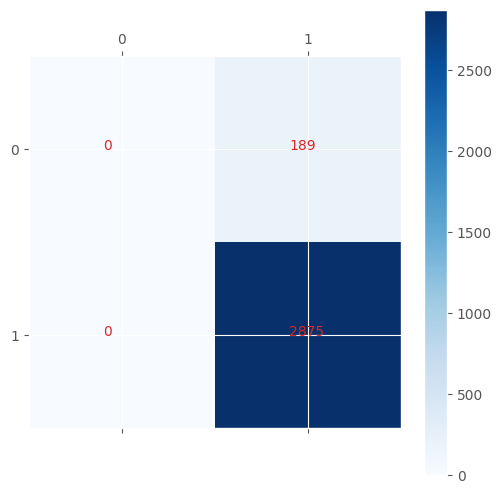

In [75]:
#Visualization for our XGBoost model confusion matrix 
plot_confusion_matrix(y_test2, prediction_xgb2)

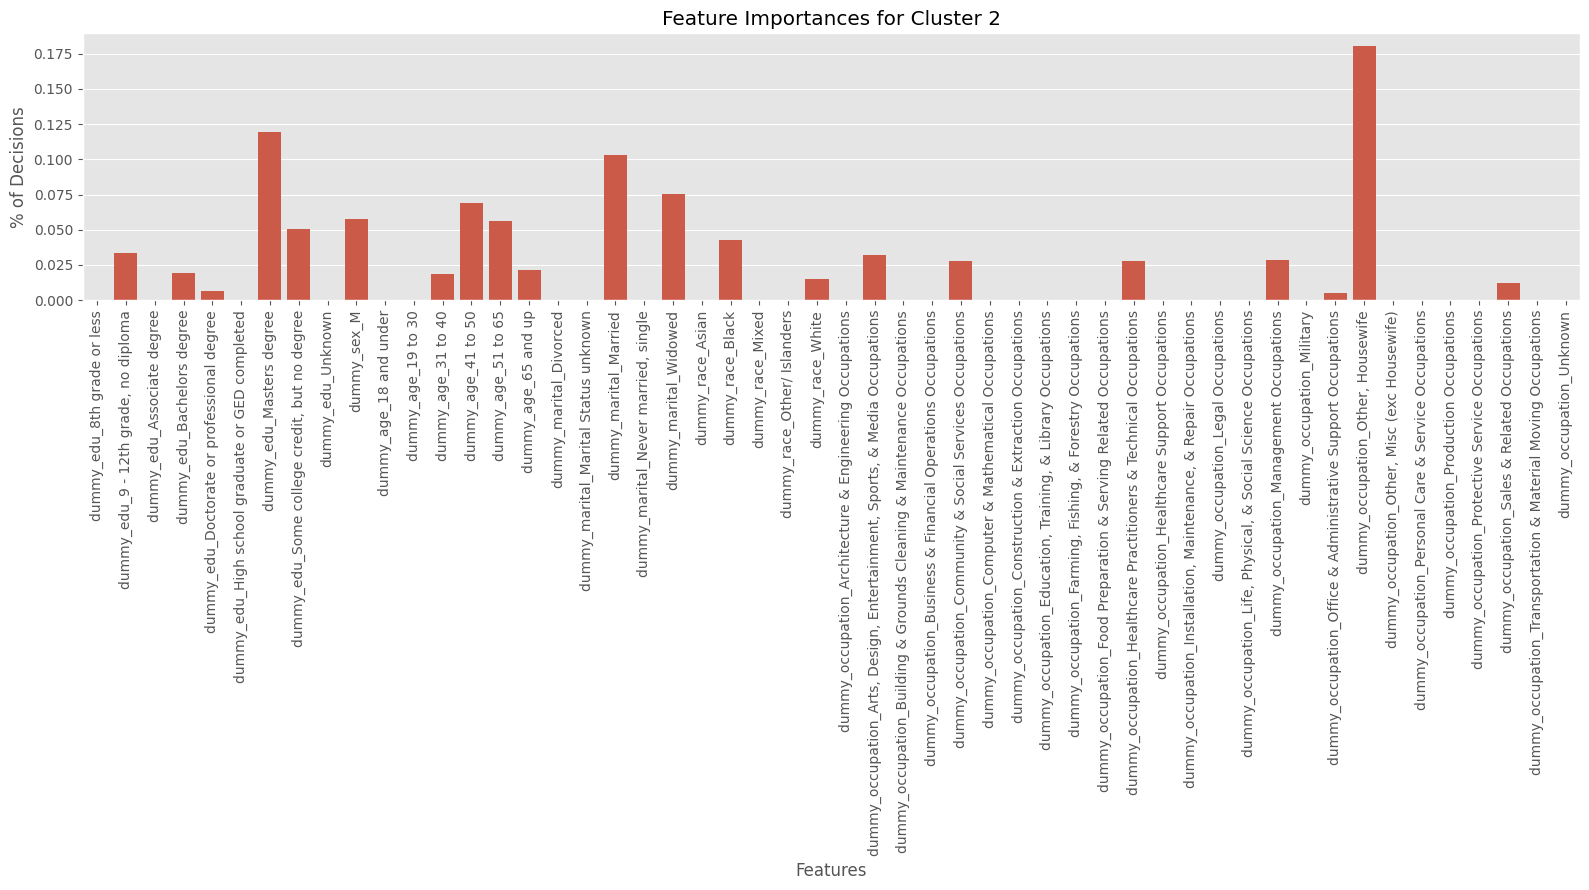

In [76]:
clus2_features = xgb2.feature_importances_
feature_importance(x_train2, clus2_features, 2)

In [77]:
#Tablular format of feature importances and the features being used to make decions for our XGBoost decision tree model
clus2_feature_importances_table = pd.DataFrame(data = {"Features": x_train2.columns, "Data": clus2_features})
clus2_feature_importances_table[clus2_feature_importances_table["Data"] > 0]

Features      Data
1                dummy_edu_9 - 12th grade, no diploma  0.033269
3                          dummy_edu_Bachelors degree  0.018968
4          dummy_edu_Doctorate or professional degree  0.006771
6                            dummy_edu_Masters degree  0.119333
7        dummy_edu_Some college credit, but no degree  0.050213
9                                         dummy_sex_M  0.057750
12                                 dummy_age_31 to 40  0.018277
13                                 dummy_age_41 to 50  0.068700
14                                 dummy_age_51 to 65  0.056280
15                                dummy_age_65 and up  0.021514
18                              dummy_marital_Married  0.102771
20                              dummy_marital_Widowed  0.075440
22                                   dummy_race_Black  0.042634
25                                   dummy_race_White  0.014836
27  dummy_occupation_Arts, Design, Entertainment, ...  0.032372
30  dummy_occupation_Community & Social Services O...  0.027472
36  dummy_occupation_Healthcare Practitioners & Te...  0.027638
41            dummy_occupation_Management Occupations  0.028448
43  dummy_occupation_Office & Administrative Suppo...  0.004945
44                  dummy_occupation_Other, Housewife  0.180324
49       dummy_occupation_Sales & Related Occupations  0.012044

# Cluster 3: XGBoost/ No oversample/ Tuned

In [73]:
cluster_3 = cluster_3.drop('Clusters', axis=1)
cluster_3.head()

Education Sex AgeCategory Marital Status  \
0     Some college credit, but no degree   M    51 to 65       Divorced   
1                      8th grade or less   M   65 and up       Divorced   
2  High school graduate or GED completed   M    51 to 65       Divorced   
3  High school graduate or GED completed   F    51 to 65       Divorced   
4  High school graduate or GED completed   M   65 and up        Married   

               Race                                      Occupation  \
0  Other/ Islanders                          Management Occupations   
1             White                          Management Occupations   
2             White     Office & Administrative Support Occupations   
3             White  Food Preparation & Serving Related Occupations   
4  Other/ Islanders           Construction & Extraction Occupations   

                       Death  
0  Accidental Drug Poisoning  
1  Accidental Drug Poisoning  
2  Accidental Drug Poisoning  
3  Accidental Drug Poisoning  
4  Accidental Drug Poisoning

In [74]:
cluster_3 = pd.get_dummies(cluster_3, columns=['Education', 'Sex', 'AgeCategory', 'Marital Status', 'Race', 'Occupation', 'Death'], prefix=['dummy_edu','dummy_sex','dummy_age', 'dummy_marital', 'dummy_race', 'dummy_occupation', 'dummy_death'])
cluster_3.head()

dummy_edu_8th grade or less  dummy_edu_9 - 12th grade, no diploma  \
0                            0                                     0   
1                            1                                     0   
2                            0                                     0   
3                            0                                     0   
4                            0                                     0   

   dummy_edu_Associate degree  dummy_edu_Bachelors degree  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           0                           0   

   dummy_edu_Doctorate or professional degree  \
0                                           0   
1                                           0   
2                                           0   
3                                           0   
4                                           0   

   dummy_edu_High school graduate or GED completed  dummy_edu_Masters degree  \
0                                                0                         0   
1                                                0                         0   
2                                                1                         0   
3                                                1                         0   
4                                                1                         0   

   dummy_edu_Some college credit, but no degree  dummy_edu_Unknown  \
0                                             1                  0   
1                                             0                  0   
2                                             0                  0   
3                                             0                  0   
4                                             0                  0   

   dummy_sex_F  ...  dummy_occupation_Other, Housewife  \
0            0  ...                                  0   
1            0  ...                                  0   
2            0  ...                                  0   
3            1  ...                                  0   
4            0  ...                                  0   

   dummy_occupation_Other, Misc (exc Housewife)  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             0   

   dummy_occupation_Personal Care & Service Occupations  \
0                                                  0      
1                                                  0      
2                                                  0      
3                                                  0      
4                                                  0      

   dummy_occupation_Production Occupations  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

   dummy_occupation_Protective Service Occupations  \
0                                                0   
1                                                0   
2                                                0   
3                                                0   
4                                                0   

   dummy_occupation_Sales & Related Occupations  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             0   

   dummy_occupation_Transportation & Material Moving Occupations  \
0                 

In [75]:
# Death and Sex attribute has two values only so we can drop one of them since they are considered redundant. 
#We are predicting Accidental or not, so only 1 column is sufficient. 

cluster_3.drop('dummy_death_Other', axis=1, inplace=True)
cluster_3.rename(columns={'dummy_death_Accidental Drug Poisoning': 'Death'}, inplace=True)
cluster_3.drop('dummy_sex_F', axis=1, inplace=True)

#1 = Accidental, 0 = Other

In [76]:
clus3_train, clus3_test = train_test_split(cluster_3, test_size=0.25, random_state=34)
print(clus3_train.shape)
print(clus3_test.shape)

(9674, 53)
(3225, 53)


In [77]:
print(clus3_train["Death"].count())
print(clus3_train["Death"].value_counts(normalize = True))
clus3_train["Death"].value_counts()

9674
1    0.934257
0    0.065743
Name: Death, dtype: float64


1    9038
0     636
Name: Death, dtype: int64

In [78]:
x_train3 = clus3_train.drop('Death', axis=1)
y_train3 = clus3_train['Death']

In [79]:
x_test3 = clus3_test.drop('Death', axis=1)
y_test3 = clus3_test['Death']

In [80]:
print(f'Our baseline model for Cluster 3 is {y_train3.value_counts(normalize = True)[0] * 100}% accurate')
print(f'Our baseline model for Cluster 3 based on the testing partition is {y_test3.value_counts(normalize = True)[0] * 100}% accurate')

Our baseline model for Cluster 3 is 6.57432292743436% accurate
Our baseline model for Cluster 3 based on the testing partition is 6.170542635658915% accurate


In [81]:
#Using CrossValidation for model selection: 
clus3_models_dict = {'RandomForest': RandomForestClassifier(n_estimators = 10, criterion='gini', random_state = 34), 
                     'NaiveBayes': MultinomialNB(alpha=1.0, fit_prior=True), 
                     'XGBoost': XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic'),
                     'Decision Tree': DecisionTreeClassifier(criterion="entropy",max_leaf_nodes=5, random_state = 34)}

clus3_model_cv_score = {}

for name, model in clus3_models_dict.items():
    score3 = cross_val_score(model, x_train3, y_train3, cv=kfold)
    clus3_model_cv_score[name] = score3.mean()

print(f'Model Scores: {clus3_model_cv_score}')

Model Scores: {'RandomForest': 0.928158144384524, 'NaiveBayes': 0.9339466869503534, 'XGBoost': 0.9342568179681559, 'Decision Tree': 0.9342568179681559}


In [82]:
#We are going to use XGBoost or DecisionTree as they have the highest accuracies (using stratified k fold cv)
clus3_params = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [3, 5, 7],
    'scale_pos_weight': [10, 15, 20]
}

grid3 = GridSearchCV(XGBClassifier(), param_grid = clus3_params, cv = kfold, n_jobs = -1, verbose = 1)
grid3.fit(x_train3, y_train3)

print("Best Parameters found for Cluster 3:", grid3.best_params_)
print("Best Accuracy through grid search for Cluster 3:%.3f"%grid3.best_score_)

Fitting 10 folds for each of 8748 candidates, totalling 87480 fits
Best Parameters found for Cluster 3: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'scale_pos_weight': 10, 'subsample': 0.7}
Best Accuracy through grid search for Cluster 3:0.934


In [148]:
#BEST SCORE:
xgb3 = XGBClassifier(colsample_bytree = 0.7, gamma = 0, learning_rate = 0.01, max_depth = 3,
                    min_child_weight = 3, n_estimators = 100, scale_pos_weight = 0.7, subsample = 0.7, random_state = 34).fit(x_train3, y_train3)

xgb3_score = cross_val_score(xgb3, x_train3, y_train3, cv=kfold)

In [149]:
print(f"Our XGBoost with the best optimized parameters on the Testing set for Cluster 3 is: {xgb3.score(x_test3, y_test3) * 100}% accurate")
print(f"Our XGBoost Classification model with optimized parameters with k-fold cross validation on the training dataset for Cluster 3 is: {xgb3_score.mean() * 100}% accurate")

Our XGBoost with the best optimized parameters on the Testing set for Cluster 3 is: 93.82945736434108% accurate
Our XGBoost Classification model with optimized parameters with k-fold cross validation on the training dataset for Cluster 3 is: 93.42568179681558% accurate


In [150]:
prediction_xgb3 = xgb3.predict(x_test3)

print("Classification Report for Cluster 3:")
print(classification_report(y_test3, prediction_xgb3))
print("===========")
print("Confusion Matrix")
print(confusion_matrix(y_test3, prediction_xgb3))
print("============")
print("Accuracy Score: ", accuracy_score(prediction_xgb3, y_test3))
print("==============")

test3_predictions_proba = xgb3.predict_proba(x_test3)
log_3 = log_loss(y_test3, test3_predictions_proba)
print("Log Loss: {:.4}".format(log_3))
print("===============")

Classification Report for Cluster 3:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       199
           1       0.94      1.00      0.97      3026

    accuracy                           0.94      3225
   macro avg       0.47      0.50      0.48      3225
weighted avg       0.88      0.94      0.91      3225

Confusion Matrix
[[   0  199]
 [   0 3026]]
Accuracy Score:  0.9382945736434108
Log Loss: 0.2485


/home/aryan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aryan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aryan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


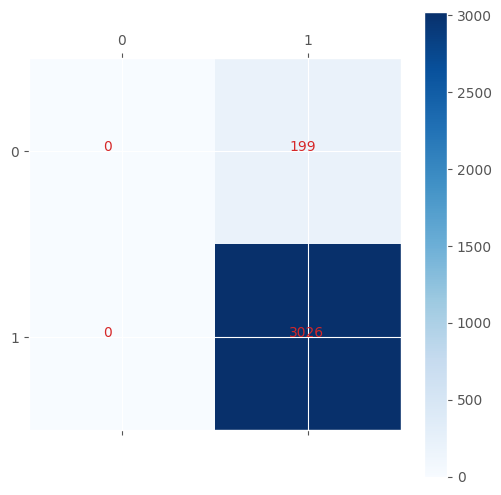

In [151]:
#Visualization for our XGBoost model confusion matrix 
plot_confusion_matrix(y_test3, prediction_xgb3)

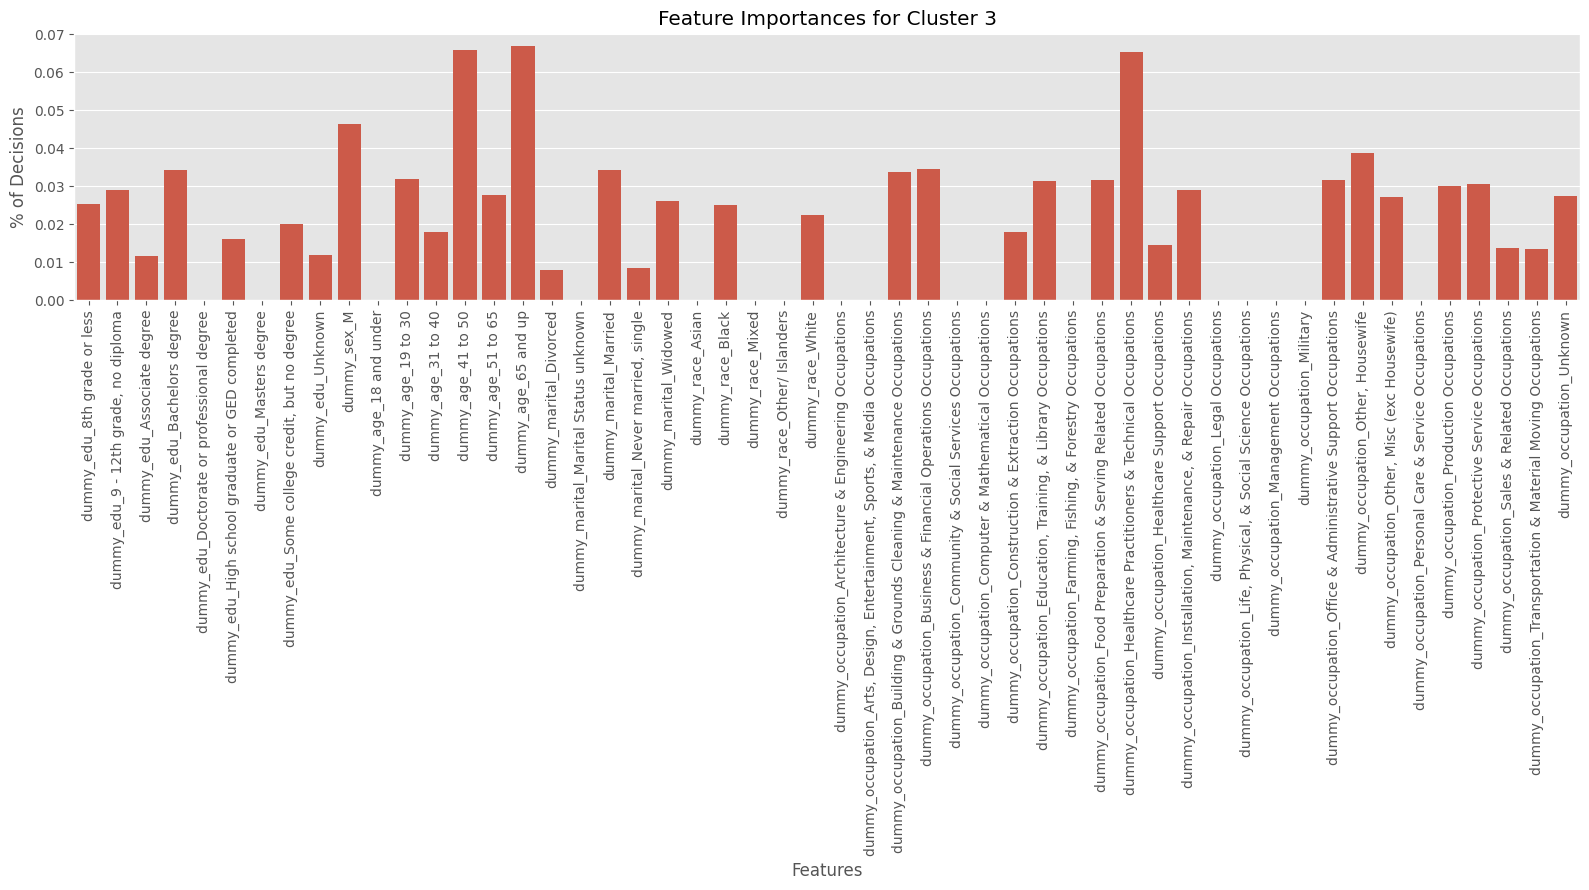

In [152]:
clus3_features = xgb3.feature_importances_

feature_importance(x_train3, clus3_features, 3)

In [153]:
#Tablular format of feature importances and the features being used to make decions for our XGBoost decision tree model
clus3_feature_importances_table = pd.DataFrame(data = {"Features": x_train3.columns, "Data": clus3_features})
clus3_feature_importances_table[clus3_feature_importances_table["Data"] > 0]

Features      Data
0                         dummy_edu_8th grade or less  0.025410
1                dummy_edu_9 - 12th grade, no diploma  0.029096
2                          dummy_edu_Associate degree  0.011510
3                          dummy_edu_Bachelors degree  0.034290
5     dummy_edu_High school graduate or GED completed  0.016157
7        dummy_edu_Some college credit, but no degree  0.019962
8                                   dummy_edu_Unknown  0.011944
9                                         dummy_sex_M  0.046308
11                                 dummy_age_19 to 30  0.031858
12                                 dummy_age_31 to 40  0.018016
13                                 dummy_age_41 to 50  0.065912
14                                 dummy_age_51 to 65  0.027590
15                                dummy_age_65 and up  0.066836
16                             dummy_marital_Divorced  0.008051
18                              dummy_marital_Married  0.034155
19                dummy_marital_Never married, single  0.008552
20                              dummy_marital_Widowed  0.026021
22                                   dummy_race_Black  0.024907
25                                   dummy_race_White  0.022362
28  dummy_occupation_Building & Grounds Cleaning &...  0.033816
29  dummy_occupation_Business & Financial Operatio...  0.034531
32  dummy_occupation_Construction & Extraction Occ...  0.017955
33  dummy_occupation_Education, Training, & Librar...  0.031442
35  dummy_occupation_Food Preparation & Serving Re...  0.031573
36  dummy_occupation_Healthcare Practitioners & Te...  0.065363
37    dummy_occupation_Healthcare Support Occupations  0.014407
38  dummy_occupation_Installation, Maintenance, & ...  0.029069
43  dummy_occupation_Office & Administrative Suppo...  0.031740
44                  dummy_occupation_Other, Housewife  0.038793
45       dummy_occupation_Other, Misc (exc Housewife)  0.027097
47            dummy_occupation_Production Occupations  0.030095
48    dummy_occupation_Protective Service Occupations  0.030503
49       dummy_occupation_Sales & Related Occupations  0.013739
50  dummy_occupation_Transportation & Material Mov...  0.013500
51                           dummy_occupation_Unknown  0.027437

# Cluster 4: XGBoost/ No oversample/ Tuned

In [83]:
cluster_4 = cluster_4.drop('Clusters', axis=1)
cluster_4.head()

Education Sex AgeCategory  \
0  High school graduate or GED completed   M    19 to 30   
1  High school graduate or GED completed   M    19 to 30   
2                       Bachelors degree   M    19 to 30   
3     Some college credit, but no degree   M    19 to 30   
4             9 - 12th grade, no diploma   M    19 to 30   

          Marital Status              Race  \
0  Never married, single  Other/ Islanders   
1  Never married, single             White   
2  Never married, single             Black   
3  Never married, single             White   
4  Never married, single  Other/ Islanders   

                                         Occupation                      Death  
0          Farming, Fishing, & Forestry Occupations  Accidental Drug Poisoning  
1          Farming, Fishing, & Forestry Occupations  Accidental Drug Poisoning  
2       Business & Financial Operations Occupations  Accidental Drug Poisoning  
3  Healthcare Practitioners & Technical Occupations  Accidental Drug Poisoning  
4                       Other, Misc (exc Housewife)  Accidental Drug Poisoning

In [84]:
cluster_4 = pd.get_dummies(cluster_4, columns=['Education', 'Sex', 'AgeCategory', 'Marital Status', 'Race', 'Occupation', 'Death'], prefix=['dummy_edu','dummy_sex','dummy_age', 'dummy_marital', 'dummy_race', 'dummy_occupation', 'dummy_death'])
cluster_4.head()

dummy_edu_8th grade or less  dummy_edu_9 - 12th grade, no diploma  \
0                            0                                     0   
1                            0                                     0   
2                            0                                     0   
3                            0                                     0   
4                            0                                     1   

   dummy_edu_Associate degree  dummy_edu_Bachelors degree  \
0                           0                           0   
1                           0                           0   
2                           0                           1   
3                           0                           0   
4                           0                           0   

   dummy_edu_Doctorate or professional degree  \
0                                           0   
1                                           0   
2                                           0   
3                                           0   
4                                           0   

   dummy_edu_High school graduate or GED completed  dummy_edu_Masters degree  \
0                                                1                         0   
1                                                1                         0   
2                                                0                         0   
3                                                0                         0   
4                                                0                         0   

   dummy_edu_Some college credit, but no degree  dummy_edu_Unknown  \
0                                             0                  0   
1                                             0                  0   
2                                             0                  0   
3                                             1                  0   
4                                             0                  0   

   dummy_sex_F  ...  dummy_occupation_Other, Housewife  \
0            0  ...                                  0   
1            0  ...                                  0   
2            0  ...                                  0   
3            0  ...                                  0   
4            0  ...                                  0   

   dummy_occupation_Other, Misc (exc Housewife)  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             1   

   dummy_occupation_Personal Care & Service Occupations  \
0                                                  0      
1                                                  0      
2                                                  0      
3                                                  0      
4                                                  0      

   dummy_occupation_Production Occupations  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

   dummy_occupation_Protective Service Occupations  \
0                                                0   
1                                                0   
2                                                0   
3                                                0   
4                                                0   

   dummy_occupation_Sales & Related Occupations  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             0   

   dummy_occupation_Transportation & Material Moving Occupations  \
0                 

In [85]:
# Death and Sex attribute has two values only so we can drop one of them since they are considered redundant. 
#We are predicting Accidental or not, so only 1 column is sufficient. 

cluster_4.drop('dummy_death_Other', axis=1, inplace=True)
cluster_4.rename(columns={'dummy_death_Accidental Drug Poisoning': 'Death'}, inplace=True)
cluster_4.drop('dummy_sex_F', axis=1, inplace=True)

#1 = Accidental, 0 = Other

In [86]:
clus4_train, clus4_test = train_test_split(cluster_4, test_size=0.25, random_state=34)
print(clus4_train.shape)
print(clus4_test.shape)

(11271, 52)
(3758, 52)


In [87]:
print(clus4_train["Death"].count())
print(clus4_train["Death"].value_counts(normalize = True))
clus4_train["Death"].value_counts()

11271
1    0.948097
0    0.051903
Name: Death, dtype: float64


1    10686
0      585
Name: Death, dtype: int64

In [88]:
x_train4 = clus4_train.drop('Death', axis=1)
y_train4 = clus4_train['Death']

In [89]:
x_test4 = clus4_test.drop('Death', axis=1)
y_test4 = clus4_test['Death']

In [90]:
print(f'Our baseline model for Cluster 4 is {y_train4.value_counts(normalize = True)[0] * 100}% accurate')
print(f'Our baseline model for Cluster 4 based on the testing partition is {y_test4.value_counts(normalize = True)[0] * 100}% accurate')

Our baseline model for Cluster 4 is 5.190311418685121% accurate
Our baseline model for Cluster 4 based on the testing partition is 5.401809473124002% accurate


In [91]:
#Using CrossValidation for model selection: 
clus4_models_dict = {'RandomForest': RandomForestClassifier(n_estimators = 10, criterion='gini', random_state = 34), 
                     'NaiveBayes': MultinomialNB(alpha=1.0, fit_prior=True), 
                     'XGBoost': XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic'),
                     'Decision Tree': DecisionTreeClassifier(criterion="entropy",max_leaf_nodes=5, random_state = 34)}

clus4_model_cv_score = {}

for name, model in clus4_models_dict.items():
    score4 = cross_val_score(model, x_train4, y_train4, cv=kfold)
    clus4_model_cv_score[name] = score4.mean()

print(f'Model Scores: {clus4_model_cv_score}')

Model Scores: {'RandomForest': 0.9460554758443619, 'NaiveBayes': 0.9480960561838057, 'XGBoost': 0.9480960561838057, 'Decision Tree': 0.9480960561838057}


In [92]:
#We are going to use XGBoost or DecisionTree as they have the highest accuracies (using stratified k fold cv)
clus4_params = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [3, 5, 7],
    'scale_pos_weight': [15, 18, 20]
}

grid4 = GridSearchCV(XGBClassifier(), param_grid = clus4_params, cv = kfold, n_jobs = -1, verbose = 1)
grid4.fit(x_train4, y_train4)

print("Best Parameters found for Cluster 4: ", grid4.best_params_)
print("Best Accuracy through grid search for Cluster 4: %.3f"%grid4.best_score_)

Fitting 10 folds for each of 8748 candidates, totalling 87480 fits
Best Parameters found for Cluster 4:  {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'scale_pos_weight': 15, 'subsample': 0.7}
Best Accuracy through grid search for Cluster 4: 0.948


In [154]:
#BEST SCORE:
xgb4 = XGBClassifier(colsample_bytree = 0.7, gamma = 0, learning_rate = 0.01, max_depth = 3,
                    min_child_weight = 3, n_estimators = 100, scale_pos_weight = 15, subsample = 0.7, random_state = 34).fit(x_train4, y_train4)

xgb4_score = cross_val_score(xgb4, x_train4, y_train4, cv=kfold)

In [155]:
print(f"Our XGBoost with the best optimized parameters on the Testing set for Cluster 4 is: {xgb4.score(x_test4, y_test4) * 100}% accurate")
print(f"Our XGBoost Classification model with optimized parameters with k-fold cross validation on the training dataset for Cluster 4 is: {xgb4_score.mean() * 100}% accurate")

Our XGBoost with the best optimized parameters on the Testing set for Cluster 4 is: 94.598190526876% accurate
Our XGBoost Classification model with optimized parameters with k-fold cross validation on the training dataset for Cluster 4 is: 94.80960561838057% accurate


In [156]:
prediction_xgb4 = xgb4.predict(x_test4)

print("Classification Report for Cluster 4:")
print(classification_report(y_test4, prediction_xgb4))
print("===========")
print("Confusion Matrix")
print(confusion_matrix(y_test4, prediction_xgb4))
print("============")
print("Accuracy Score: ", accuracy_score(prediction_xgb4, y_test4))
print("==============")

test4_predictions_proba = xgb4.predict_proba(x_test4)
log_4 = log_loss(y_test4, test4_predictions_proba)
print("Log Loss: {:.4}".format(log_4))
print("===============")

Classification Report for Cluster 4:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       203
           1       0.95      1.00      0.97      3555

    accuracy                           0.95      3758
   macro avg       0.47      0.50      0.49      3758
weighted avg       0.89      0.95      0.92      3758

Confusion Matrix
[[   0  203]
 [   0 3555]]
Accuracy Score:  0.94598190526876
Log Loss: 0.2108


/home/aryan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aryan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/aryan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


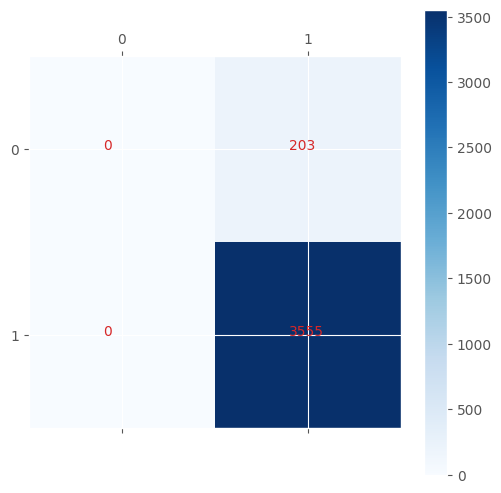

In [157]:
#Visualization for our XGBoost model confusion matrix 
plot_confusion_matrix(y_test4, prediction_xgb4)

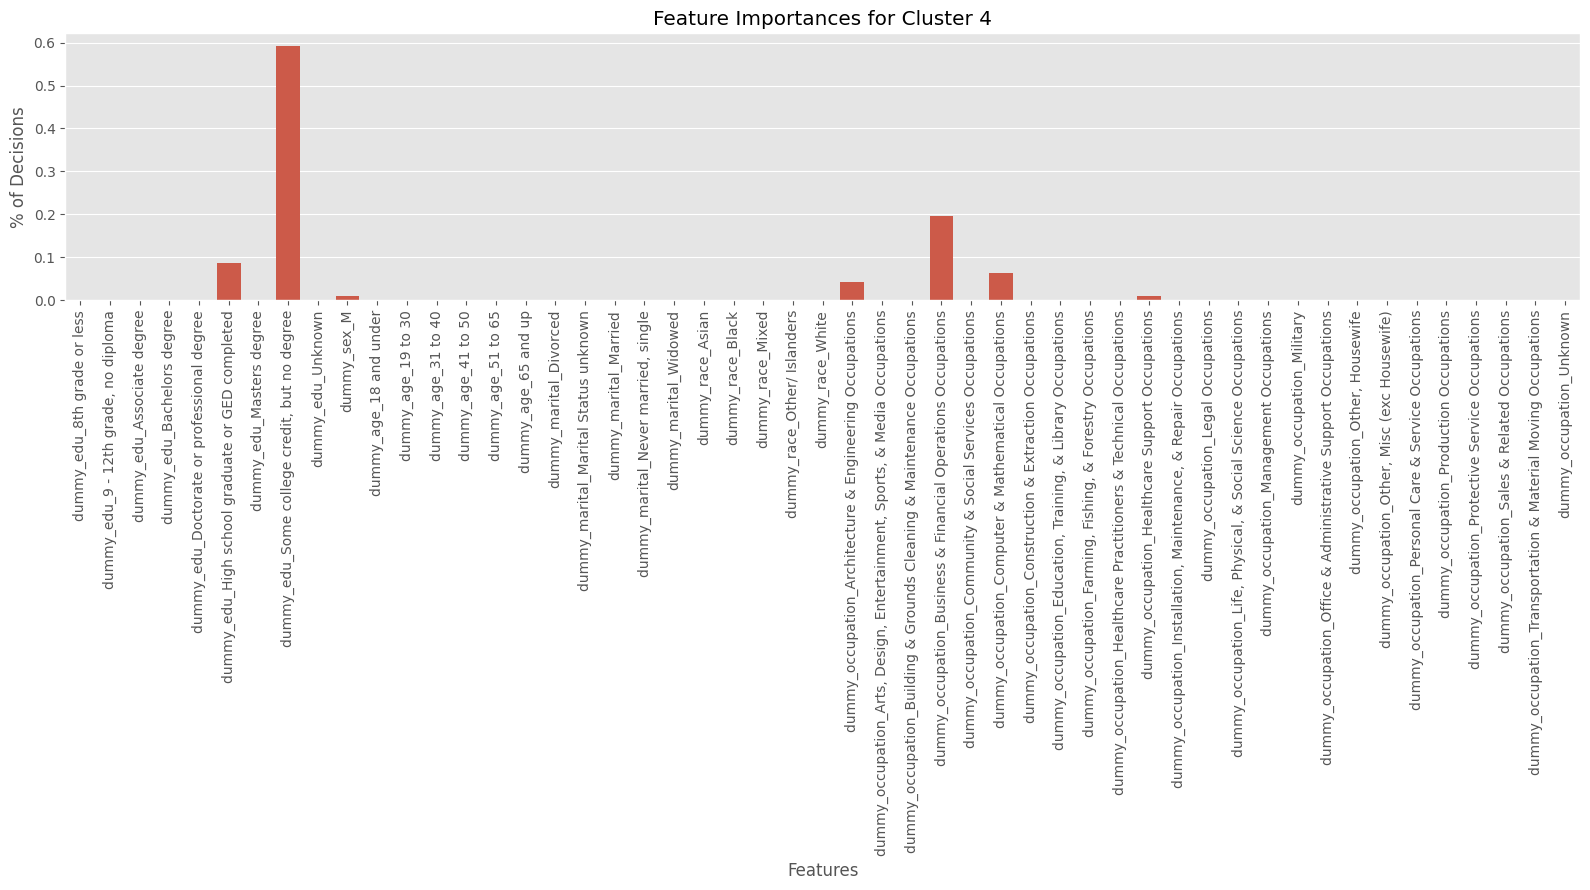

In [158]:
clus4_features = xgb4.feature_importances_

feature_importance(x_train4, clus4_features, 4)

In [159]:
#Tablular format of feature importances and the features being used to make decions for our XGBoost decision tree model
clus4_feature_importances_table = pd.DataFrame(data = {"Features": x_train4.columns, "Data": clus4_features})
clus4_feature_importances_table[clus4_feature_importances_table["Data"] > 0]

Features      Data
5     dummy_edu_High school graduate or GED completed  0.087044
7        dummy_edu_Some college credit, but no degree  0.591980
9                                         dummy_sex_M  0.009232
26  dummy_occupation_Architecture & Engineering Oc...  0.042643
29  dummy_occupation_Business & Financial Operatio...  0.195905
31  dummy_occupation_Computer & Mathematical Occup...  0.063964
36    dummy_occupation_Healthcare Support Occupations  0.009232

# OLD Train/Test split, rebalancing and making models on entire dataframe.

In [310]:
#STRATIFIED K FOLD 
fen_train, fen_test = train_test_split(fen_df2, test_size =0.25, random_state = 10)

In [311]:
print(fen_train.shape)
print(fen_test.shape)

(54167, 55)
(18056, 55)


In [312]:
#Lets resample the Manner of Death as the majority of them are Accidental and recreate the baseline
print(fen_train["Death"].count())
print(fen_train["Death"].value_counts(normalize = True))
fen_train["Death"].value_counts()

54167
Accidental Drug Poisoning      0.939816
Undetermined Drug Poisoning    0.035760
Unknown                        0.016634
Suicide Drug Poisoning         0.007791
Name: Death, dtype: float64


Accidental Drug Poisoning      50907
Undetermined Drug Poisoning     1937
Unknown                          901
Suicide Drug Poisoning           422
Name: Death, dtype: int64

In [313]:
#Defining a function to find the required number of resampled records
def determine_num_samples(records, unique_records, proportion):
    x = int((proportion * records - unique_records) / (1 - proportion))
    return x

In [314]:
#Number of samples determined based on our desired proprtions
num_samples_long_duration = determine_num_samples(len(fen_train), 1937, 0.3)
print("Long Duration Upsample samples to add: ", num_samples_long_duration)

Long Duration Upsample samples to add:  20447


In [315]:
# find all the records that match the criteria for the resampling
to_resample = fen_train.loc[fen_train['Death'] =="Undetermined Drug Poisoning"]

In [316]:
our_resample = to_resample.sample(n = 20447 , replace = True)
fen_train_rebal = pd.concat([fen_train, our_resample])

In [317]:
# resampled distribution of race
fen_train_rebal['Death'].value_counts()

Accidental Drug Poisoning      50907
Undetermined Drug Poisoning    22384
Unknown                          901
Suicide Drug Poisoning           422
Name: Death, dtype: int64

In [318]:
x_train = fen_train_rebal.drop('Death', axis=1)
y_train = fen_train_rebal['Death']

In [319]:
x_test = fen_test.drop('Death', axis=1)
y_test = fen_test['Death']

In [320]:
#Baseline for Accidental
print((((y_train.value_counts().max())/len(y_train))*100), end='%')

68.22714235934275%

In [321]:
s_base = y_train.value_counts()['Undetermined Drug Poisoning']
print(((s_base/len(y_train))*100), end='%')

29.99973195378883%

In [322]:
#Let's train a Decision Tree classifier to establish a baseline before we start creating profiles using clustering. GridSearch for parameter tuning
rf01 = RandomForestClassifier(n_estimators = 30,criterion="gini").fit(x_train,y_train)

prediction_rf01 = rf01.predict(x_train)
print(rf01.score(x_test,y_test))

0.856723526805494
